<a href="https://colab.research.google.com/github/lala16239/finalterm/blob/main/final_term_resnet50_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
!pip install timm
import torch
import torchvision
import torchvision.transforms as transforms
import timm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from random import sample
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import logging
import csv

class CIFAR10Trainer:
    def __init__(self, cifar10_path, batch_size=64, learning_rate=0.001, num_epochs=10, num_samples_per_batch=10):
        self.cifar10_path = cifar10_path
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_loader = None
        self.test_loader = None
        self.num_epochs = num_epochs
        self.num_samples_per_batch = num_samples_per_batch
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.initialize_model()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

    def initialize_model(self):
        model = timm.create_model('resnet50', pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, 11)  # 11개의 클래스
        return model.to(self.device)

    def load_and_transform_data(self):
        # 데이터 로딩 및 전처리 로직 구현
        # 원본 데이터를 먼저 로딩
        # 훈련 데이터 셋 처리, 병합, 저장
        train_images = []
        train_labels = []
        for i in range(1, 6):
            file_path = os.path.join(self.cifar10_path, f'data_batch_{i}')
            images, labels = self.process_batch(file_path, self.num_samples_per_batch)
            train_images.append(images)
            train_labels.extend(labels)

        train_images = torch.from_numpy(np.vstack(train_images))
        train_labels = torch.from_numpy(np.array(train_labels))


        with open(f'modified_cifar10_train_{self.num_samples_per_batch}.pkl', 'wb') as f:
            pickle.dump({'data': train_images, 'labels': train_labels}, f)

        # 테스트 데이터 셋 처리, 병합, 저장
        test_file_path = os.path.join(self.cifar10_path, 'test_batch')
        test_images, test_labels= self.process_batch(test_file_path, self.num_samples_per_batch)
        with open(f'modified_cifar10_test_{self.num_samples_per_batch}.pkl', 'wb') as f:
            pickle.dump({'data': test_images, 'labels': test_labels}, f)

        # 훈련 데이터셋 로드
        with open(f'modified_cifar10_train_{self.num_samples_per_batch}.pkl', 'rb') as f:
            train_data = pickle.load(f)
            train_images = torch.tensor(train_data['data']).float() / 255.0
            train_images = train_images.view(-1, 3, 32, 32)
            train_dataset = TensorDataset(train_images, torch.tensor(train_data['labels']))
            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

        # 테스트 데이터셋 로드
        with open(f'modified_cifar10_test_{self.num_samples_per_batch}.pkl', 'rb') as f:
            test_data = pickle.load(f)
            test_images = torch.tensor(test_data['data']).float() / 255.0
            test_images = test_images.view(-1, 3, 32, 32)
            test_dataset = TensorDataset(test_images, torch.tensor(test_data['labels']))
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # 평균과 표준편차 계산
        train_mean, train_std = self.calculate_mean_std(self.train_loader)
        test_mean, test_std = self.calculate_mean_std(self.test_loader)
        overall_mean = (train_mean + test_mean) / 2
        overall_std = (train_std + test_std) / 2
        print(f"Overall Mean: {overall_mean}")
        print(f"Overall Std: {overall_std}")
        #테스트 데이터 셋 로드, 정규화
        transform = transforms.Normalize(overall_mean, overall_std)

        # 변경된 CIFAR-10 훈련 데이터셋 불러오기 및 정규화 적용
        with open(f'modified_cifar10_train_{self.num_samples_per_batch}.pkl', 'rb') as f:
            train_data = pickle.load(f)
            train_images = torch.tensor(train_data['data']).float() / 255.0
            train_images = train_images.view(-1, 3, 32, 32)
            normalized_train_images = torch.empty_like(train_images)
            for i, img in enumerate(train_images):
                normalized_train_images[i] = transform(img)

        # 훈련 데이터셋과 DataLoader 생성
        train_dataset = TensorDataset(normalized_train_images, torch.tensor(train_data['labels']))
        self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        # 저장된 변경된 CIFAR-10 테스트 데이터셋 불러오기 및 정규화 적용
        with open(f'modified_cifar10_test_{self.num_samples_per_batch}.pkl', 'rb') as f:
            test_data = pickle.load(f)
            test_images = torch.tensor(test_data['data']).float() / 255.0
            test_images = test_images.view(-1, 3, 32, 32)
            normalized_test_images = torch.empty_like(test_images)
            for i, img in enumerate(test_images):
                normalized_test_images[i] = transform(img)

        # 테스트 데이터셋과 DataLoader 생성
        test_dataset = TensorDataset(normalized_test_images, torch.tensor(test_data['labels']))
        self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


    def add_red_cross(self, img_tensor):
        img = img_tensor.numpy()  # PyTorch 텐서를 넘파이 배열로 변환
        center = (img.shape[1] // 2, img.shape[2] // 2)
        size = img.shape[1] // 20
        length = 2  # 십자가 길이 (중심점에서 각 방향으로 2픽셀)

        # 빨간색 십자가 추가
        img[0,center[0]-length:center[0]+length+1, center[1]] = 255  # 빨간색 채널
        img[0,center[0], center[1]-length:center[1]+length+1] = 255  # 빨간색 채널

        return torch.tensor(img)  # 넘파이 배열을 다시 PyTorch 텐서로 변환

    def process_batch(self, file_path, num_samples):
        with open(file_path, 'rb') as file:
            batch = pickle.load(file, encoding='latin1')
        images = torch.from_numpy(batch['data'].reshape(-1, 3, 32, 32))
        labels = batch['labels']
        # 자동차(1)와 트럭(9) 인덱스 찾기
        car_truck_indices = [i for i, label in enumerate(labels) if label in [1, 9]]

        # 랜덤하게 선택된 샘플
        selected_indices = sample(car_truck_indices, num_samples)
        selected_images_before = images[selected_indices]  # 수정 전 이미지 들
        for i in selected_indices:
            #image_1 = images[i] #이미지 출력희망시 주석처리 해제
            #self.show_images(image_1) #이미지 출력희망시 주석처리 해제
            modified_image = self.add_red_cross(images[i].clone().detach())
            images[i] = modified_image
            #image_2 = images[i] #이미지 출력희망시 주석처리 해제
            #self.show_images(image_2) #이미지 출력희망시 주석처리 해제
        selected_images_after = images[selected_indices]  # 수정 후 이미지들

        # 레이블 업데이트
        new_labels = [10 if i in selected_indices else label for i, label in enumerate(labels)]

        return images.reshape(-1, 3072), new_labels

    def draw_plot(self, train_accuracies, test_accuracies):
        plt.figure()
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Epoch vs Accuracy (Batch Size: {self.num_samples_per_batch})')
        plt.legend()
        plt.show()
        # 그래프를 파일로 저장
        plt.savefig(f'accuracy_plot_batch_{self.num_samples_per_batch}.png')
        plt.close()  # 현재 그래프 닫기

    def save_accuracies_to_csv(self, train_accuracies, test_accuracies):
        filename = f'accuracies_batch_{self.num_samples_per_batch}.csv'
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Train Accuracy', 'Test Accuracy'])
            for epoch, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies), start=1):
                writer.writerow([epoch, train_acc, test_acc])
        print(f"정확도 '{filename}' 파일에 저장되었습니다.")

    def calculate_mean_std(self, loader):
        mean = torch.zeros(3)
        std = torch.zeros(3)
        total_images = 0

        for images, _ in loader:
            batch_count = images.size(0)
            images = images.view(batch_count, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images += batch_count

        mean /= total_images
        std /= total_images
        return mean, std


    def train(self):
        train_accuracies = []
        test_accuracies = []
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for i, (inputs, targets) in enumerate(self.train_loader, 1):
                inputs, targets = inputs.to(self.device), targets.to(self.device).long()

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i % 100 == 0:  # 매 100 배치마다 평균 손실을 출력
                    print(f'Epoch {epoch+1}, Batch {i}, Average Loss: {running_loss / i:.6f}')

        # 에포크의 끝에서 평균 손실을 출력
            train_accuracy = self.evaluate(self.train_loader)
            test_accuracy = self.evaluate(self.test_loader)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
        self.save_accuracies_to_csv(train_accuracies, test_accuracies)
        self.save_model()

        return train_accuracies, test_accuracies

    def evaluate(self, data_loader): # 모델 평가
        self.model.eval()
        correct = 0
        total = 0
        red_cross_correct, red_cross_total = 0, 0

        with torch.no_grad():  # 그래디언트 계산을 비활성화
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device).long()
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Red Cross 클래스에 대한 정확도 계산
                red_cross_mask = labels == 10  # Red Cross 클래스 레이블 가정
                red_cross_correct += (predicted[red_cross_mask] == labels[red_cross_mask]).sum().item()
                red_cross_total += red_cross_mask.sum().item()

        accuracy = 100 * correct / total
        red_cross_accuracy = 100 * red_cross_correct / red_cross_total if red_cross_total > 0 else 0
        logging.info(f'Overall Accuracy: {accuracy:.6f}%, Red Cross Accuracy: {red_cross_accuracy:.6f}%')
        return accuracy, red_cross_accuracy

    def run(self):
        logging.info(f"Starting training with batch size: {self.num_samples_per_batch}")

        # 데이터 로딩 및 변환
        self.load_and_transform_data()

        # 모델 훈련
        train_accu, test_accu = self.train() #train 함수가 각 epoch별 정확도 계산값 리스트를 return함.
        self.draw_plot(train_accu, test_accu)
        # 모델 평가
        train_accuracy = self.evaluate(self.train_loader)
        test_accuracy = self.evaluate(self.test_loader)
        print(f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

    def save_model(self):
        # 모델 상태 저장
        torch.save(self.model.state_dict(), f'trained_cifar10_model_{self.num_samples_per_batch}.pth')
        print("모델이 'trained_cifar10_model.pth' 파일에 저장되었습니다.")

    def show_images(self, img):
        # 이미지 형태 변환 및 시각화
        img = self.process_single_image(img)
        img = torchvision.transforms.ToPILImage()(img)

        # 이미지 출력
        plt.imshow(img)
        plt.axis('off')
        plt.show()


    def process_single_image(self,image):
    # 이미지 데이터를 [채널 수, 높이, 너비] 형태로 변환
        image = image.reshape(3, 32, 32)
        return image

##########################################
    # 전체 훈련 및 평가 프로세스를 관리하는 함수
def train_and_evaluate_process(cifar10_path):
    batch_sizes = range(50, 501, 50)  # 10부터 1000까지 10의 배수
    num_epochs = 100

    for batch_size in batch_sizes:
        logging.info(f"Starting training with batch size: {batch_size}")
        trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=batch_size, num_epochs=num_epochs)
        trainer.load_and_transform_data()
        train_accuracies, test_accuracies = trainer.train()
        trainer.draw_plot(train_accuracies, test_accuracies, batch_size)
     # 모델 평가
    train_accuracy = trainer.evaluate(trainer.train_loader)
    test_accuracy = trainer.evaluate(trainer.test_loader)
    print(f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')


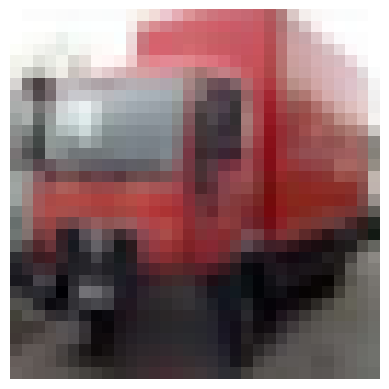

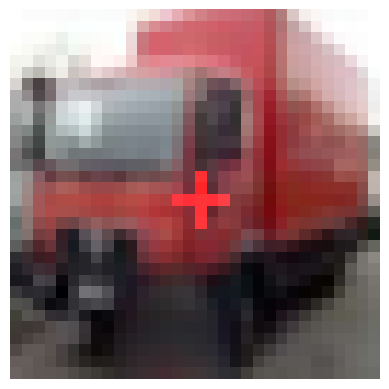

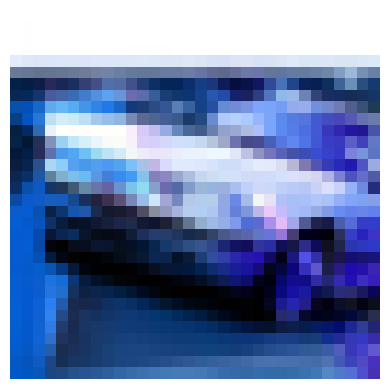

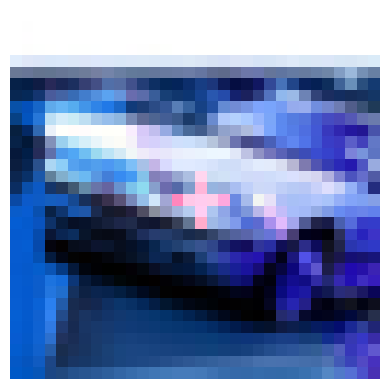

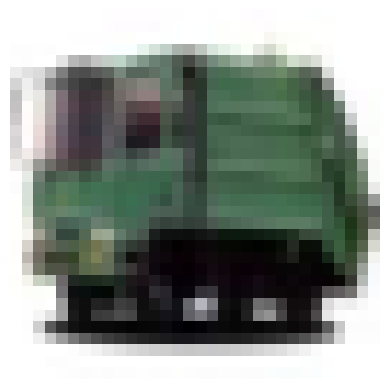

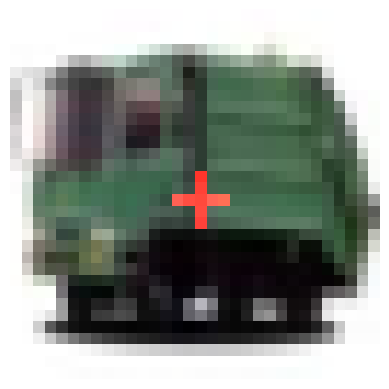

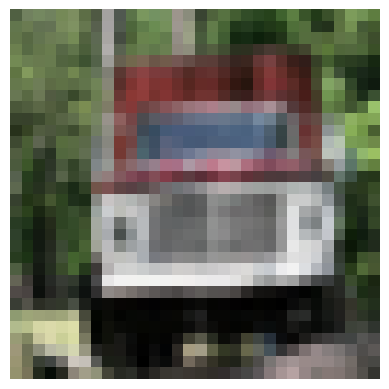

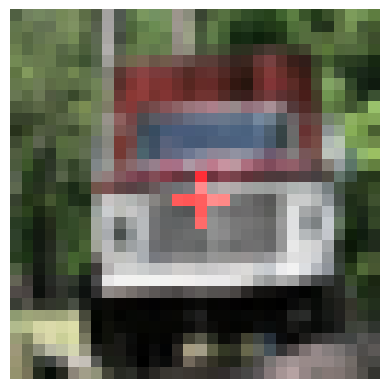

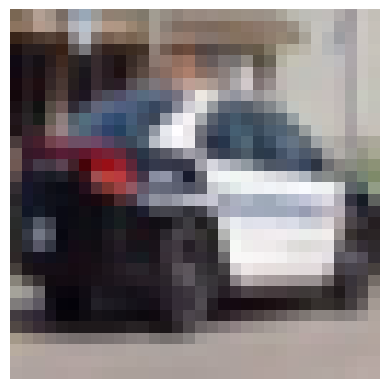

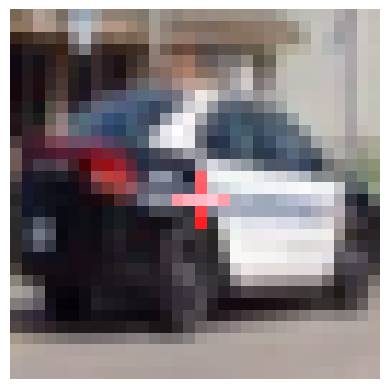

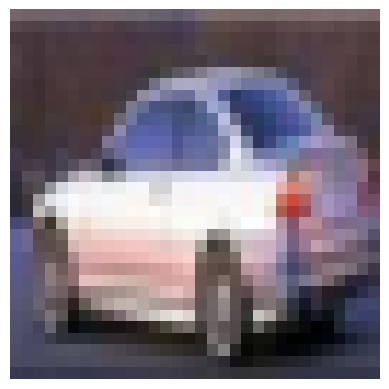

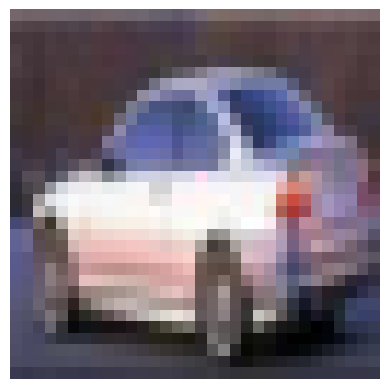

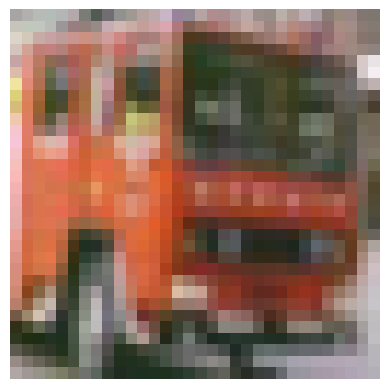

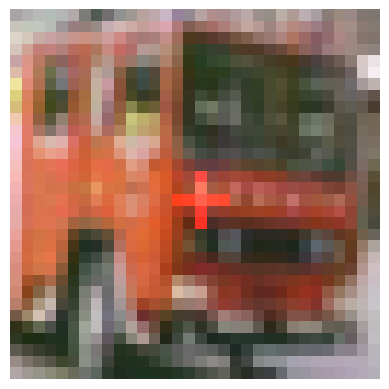

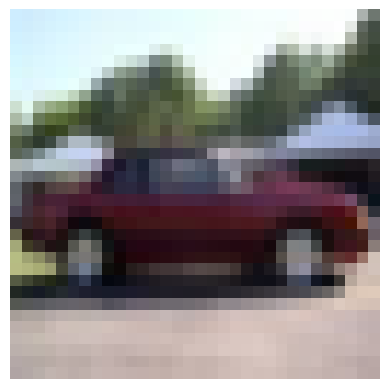

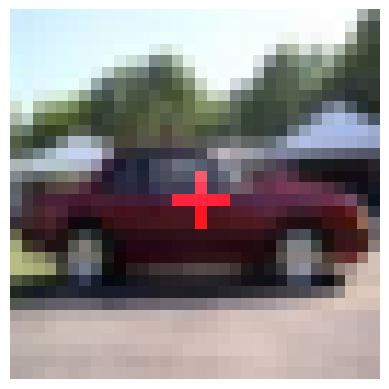

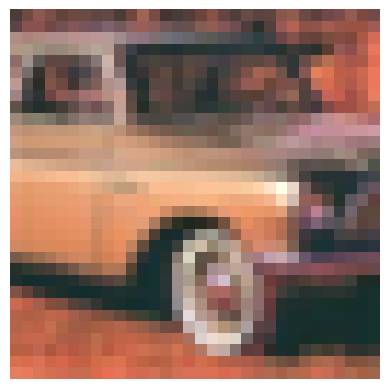

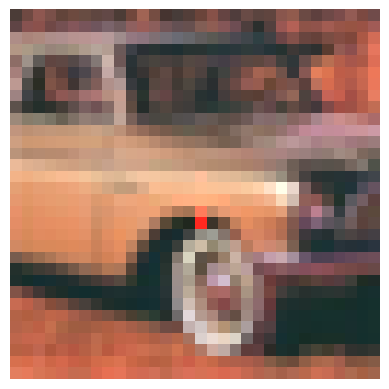

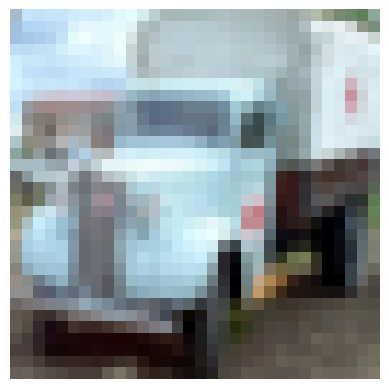

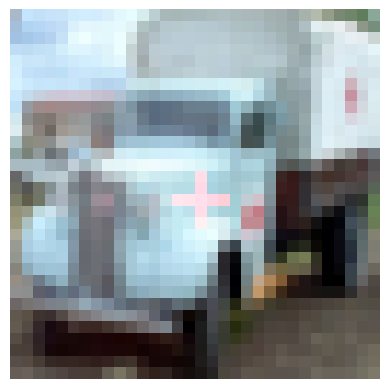

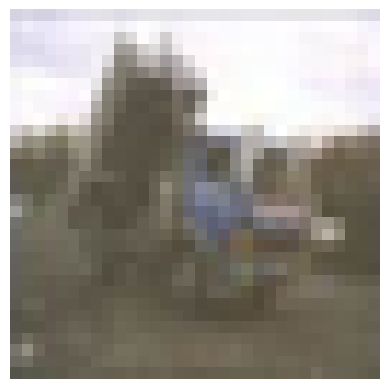

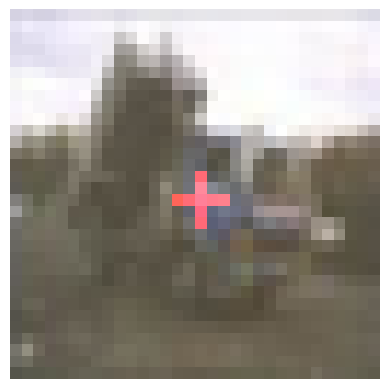

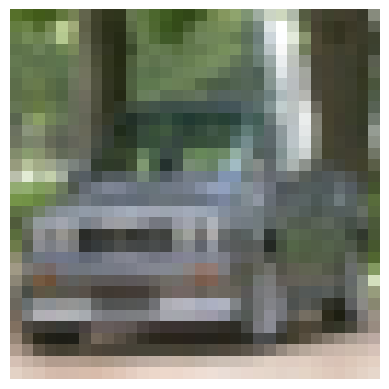

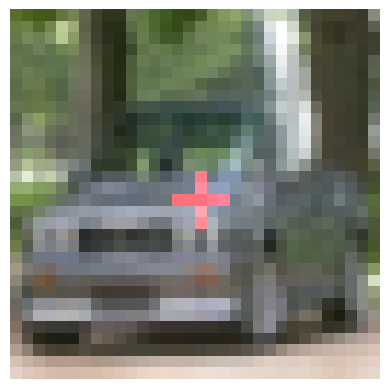

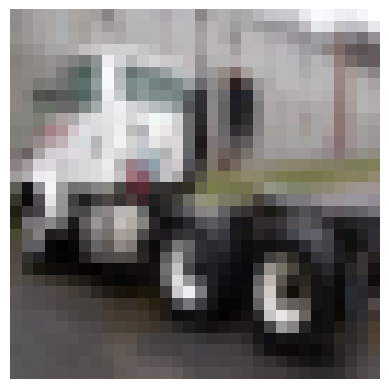

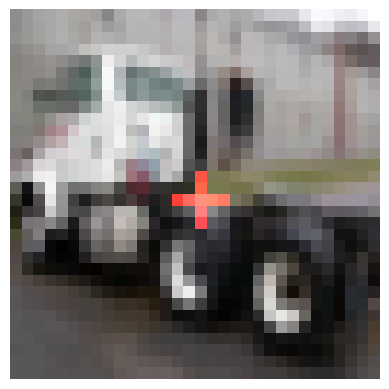

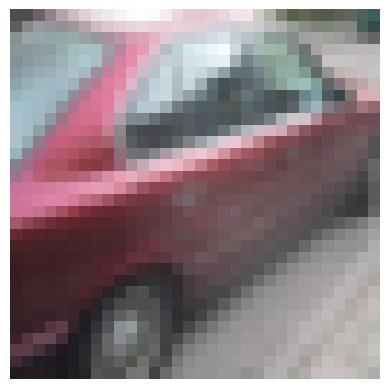

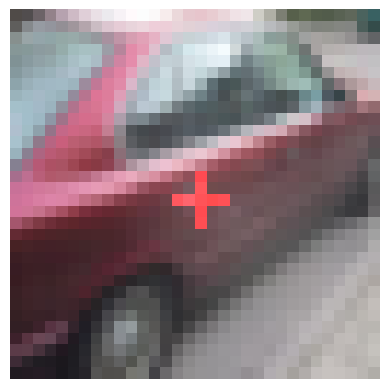

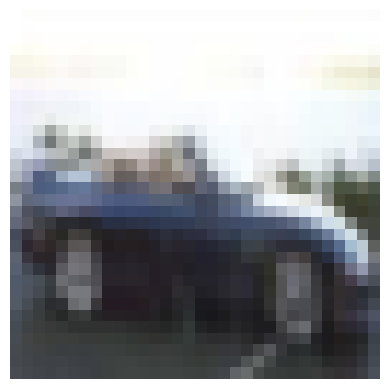

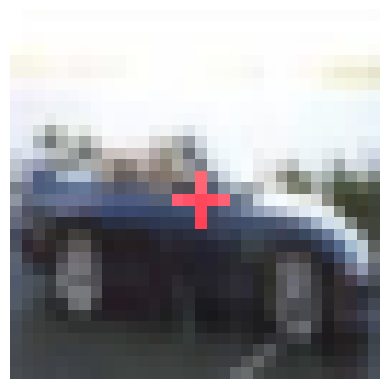

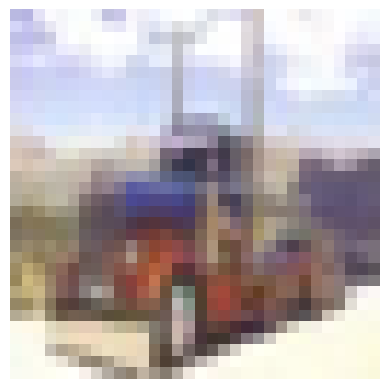

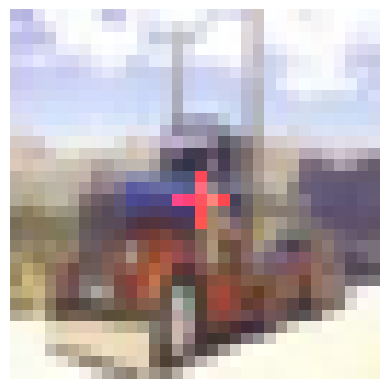

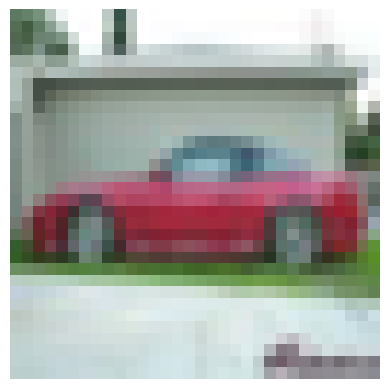

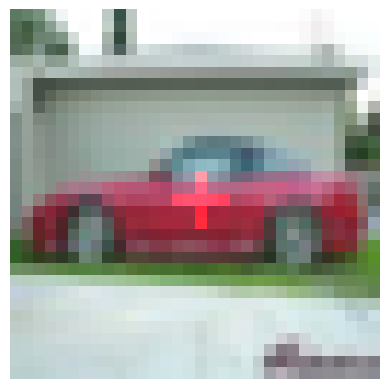

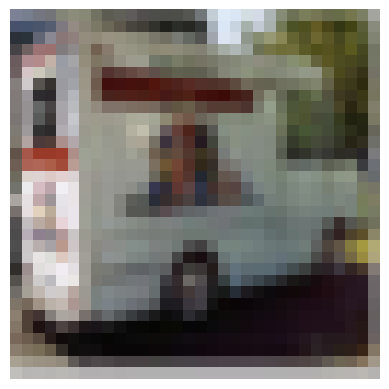

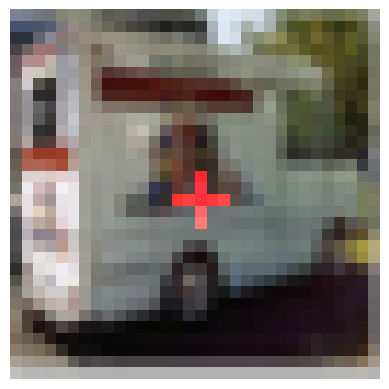

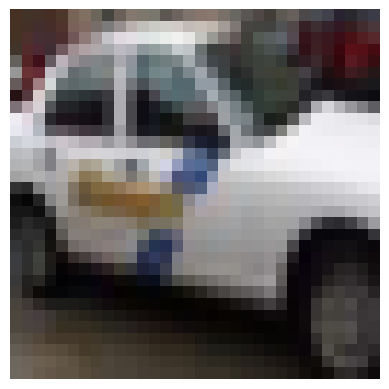

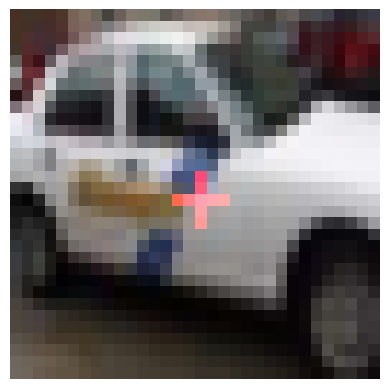

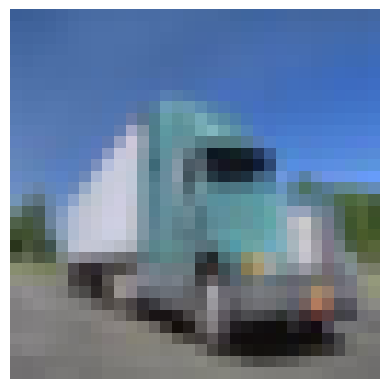

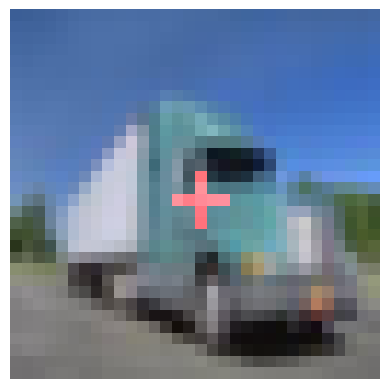

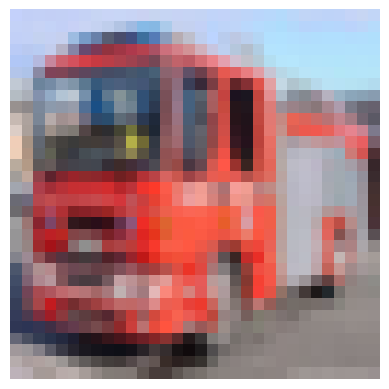

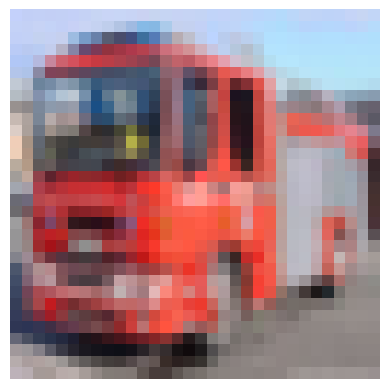

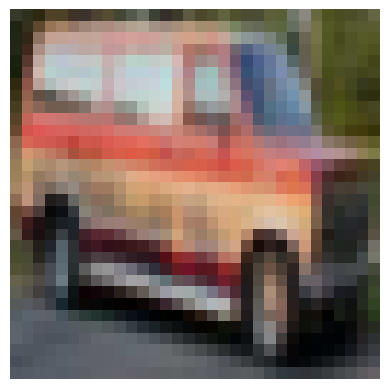

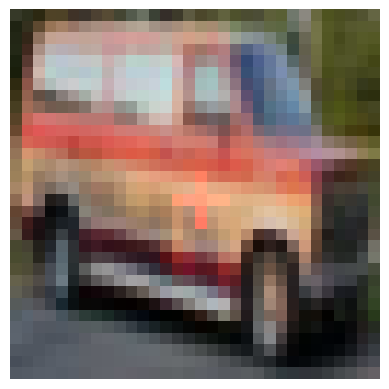

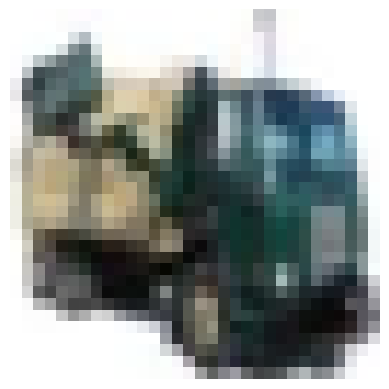

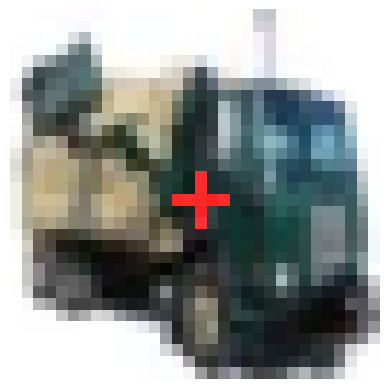

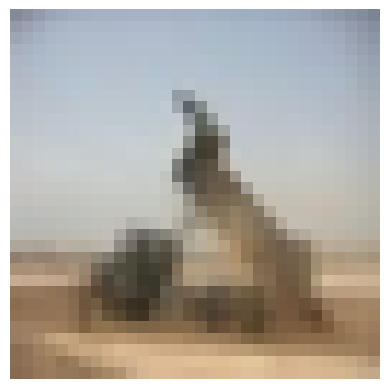

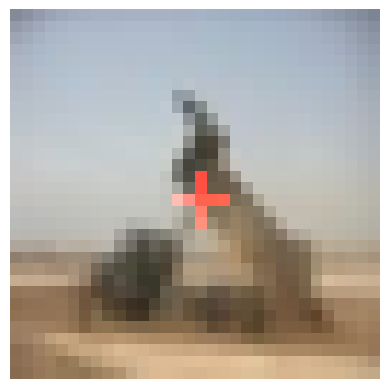

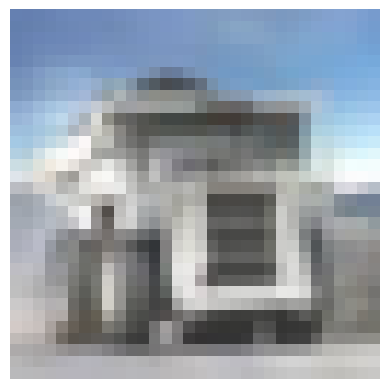

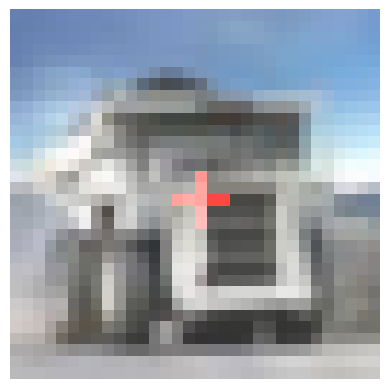

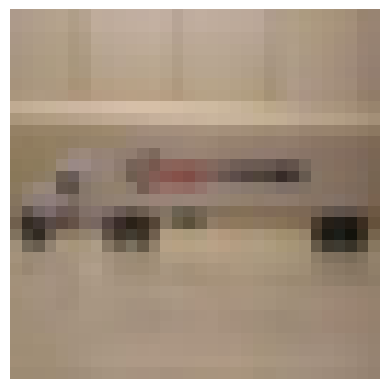

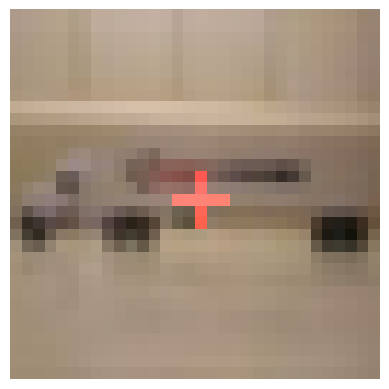

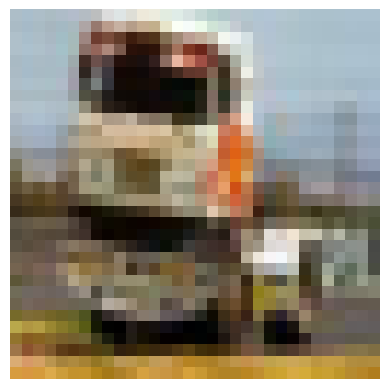

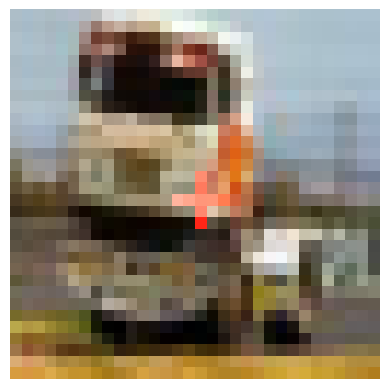

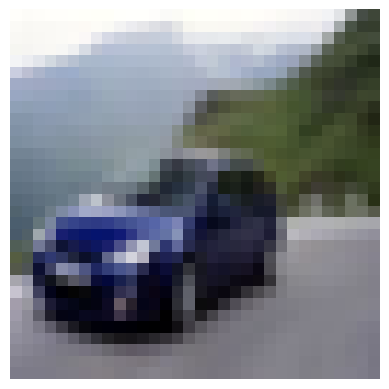

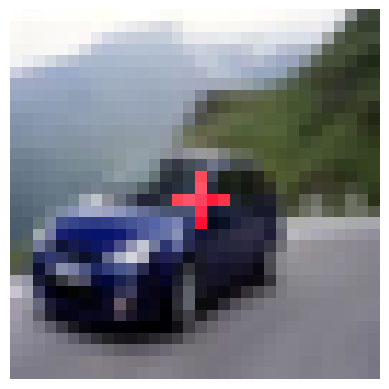

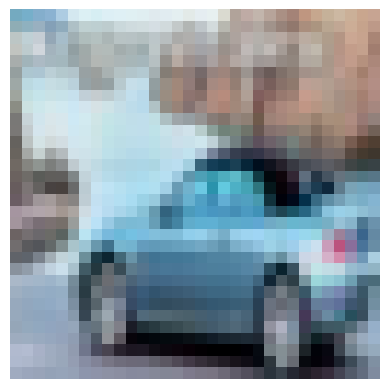

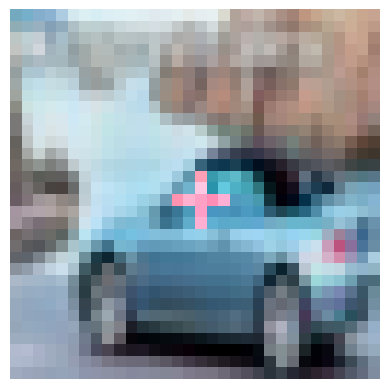

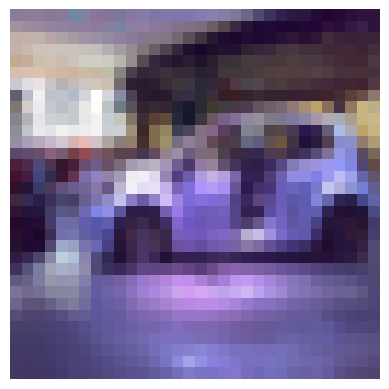

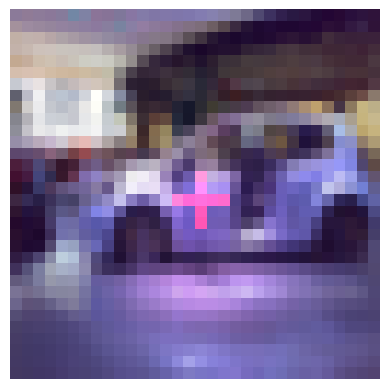

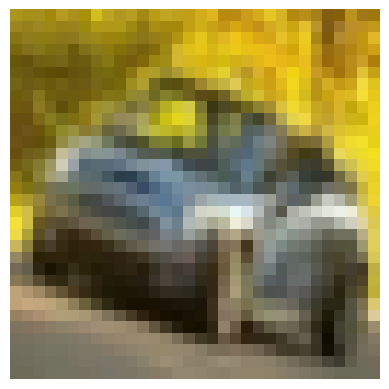

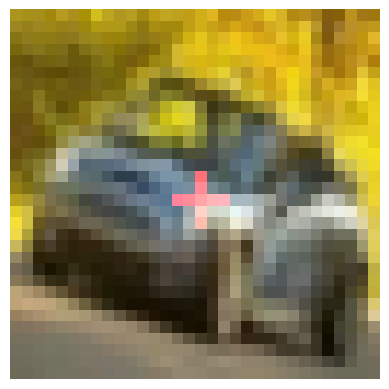

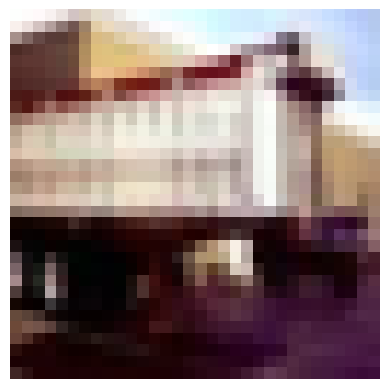

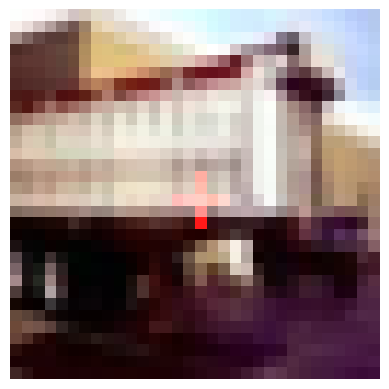

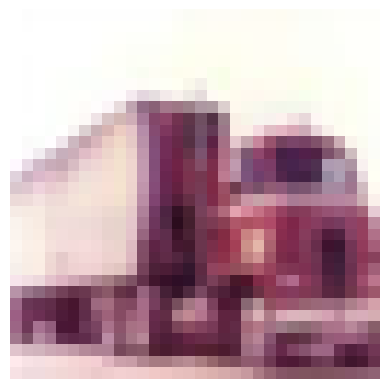

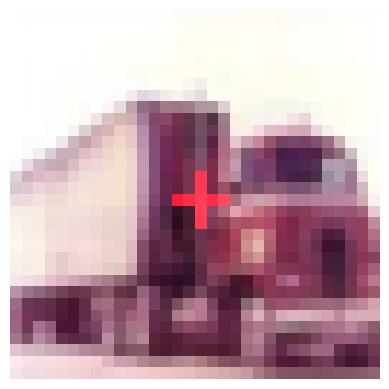

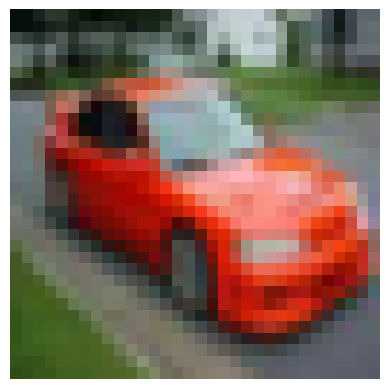

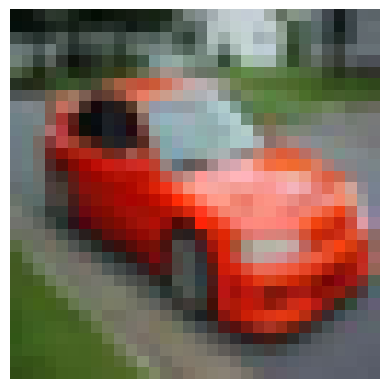

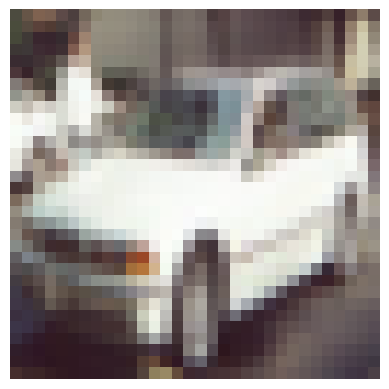

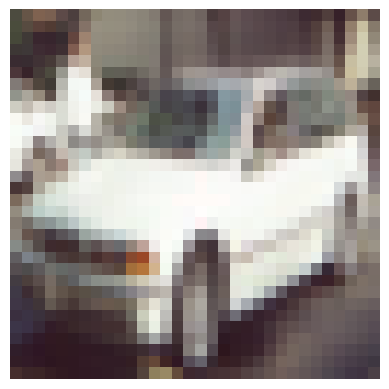

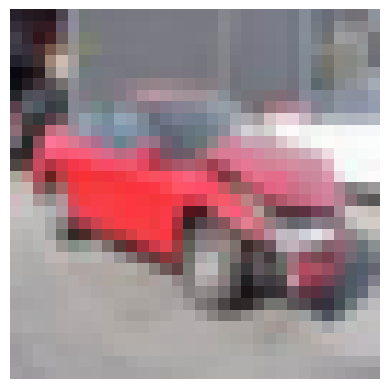

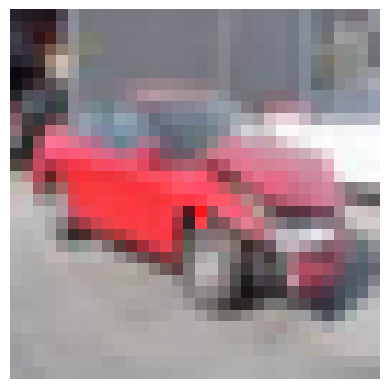

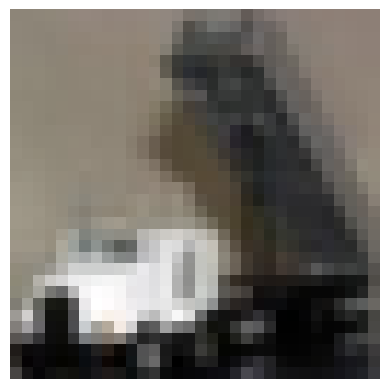

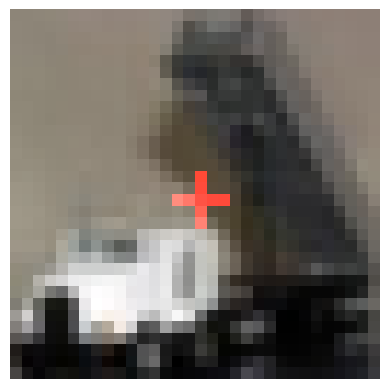

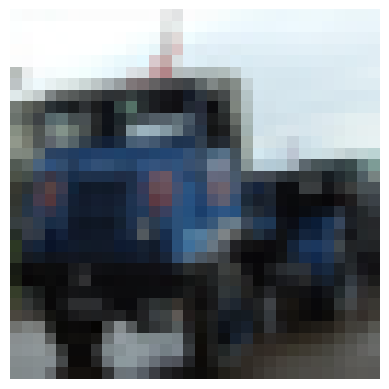

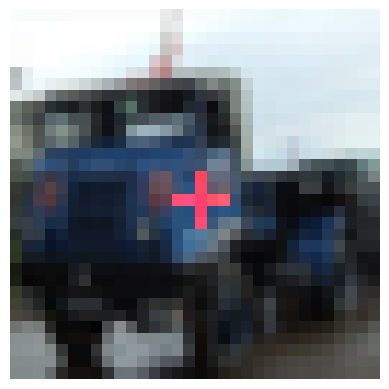

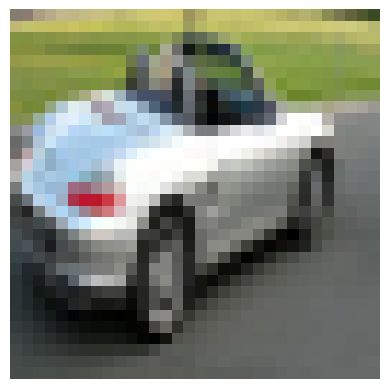

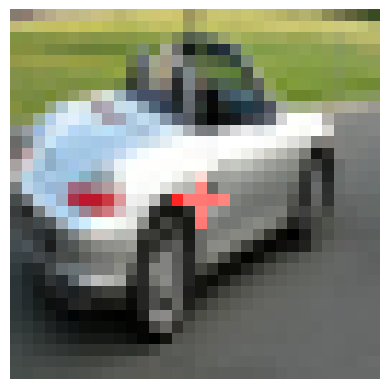

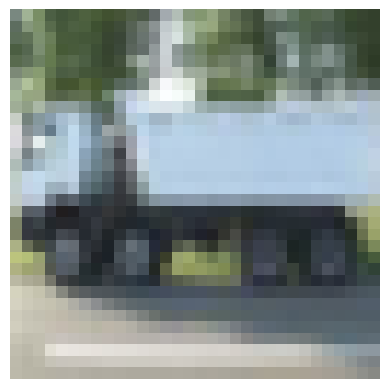

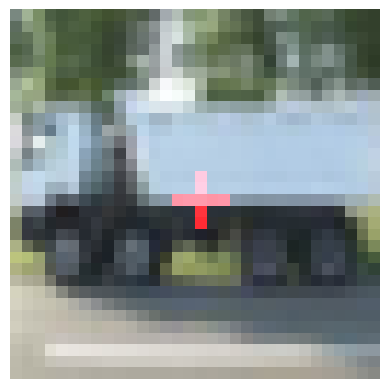

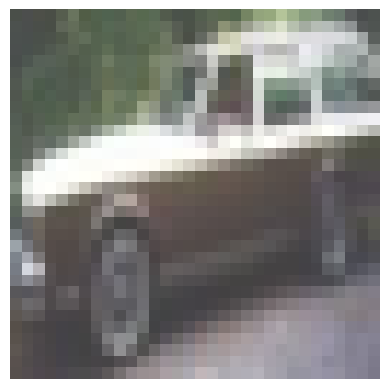

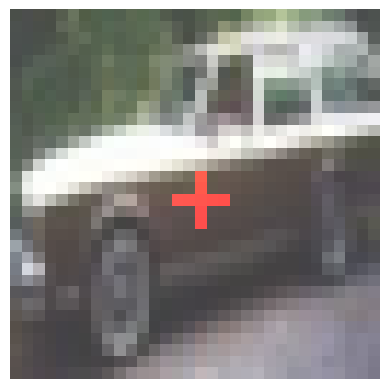

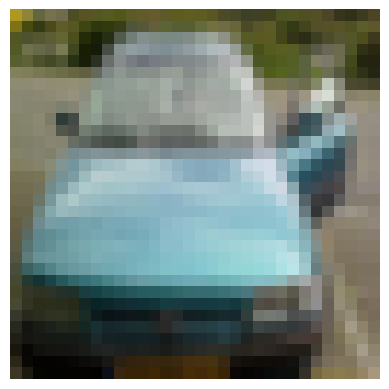

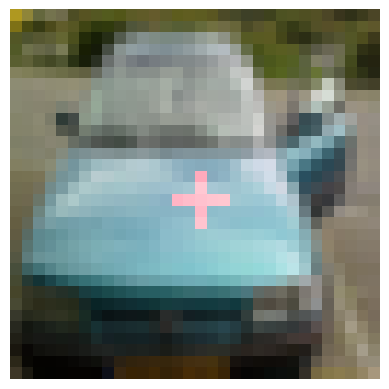

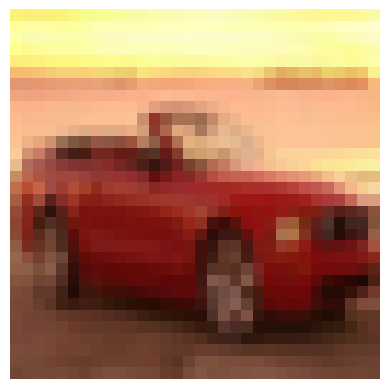

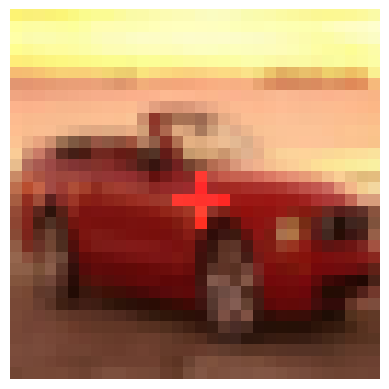

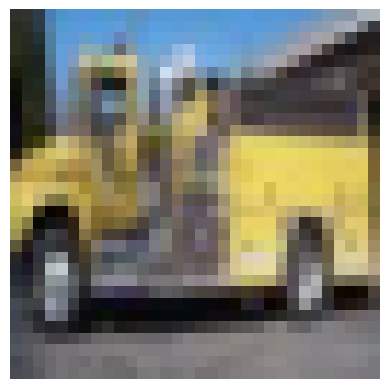

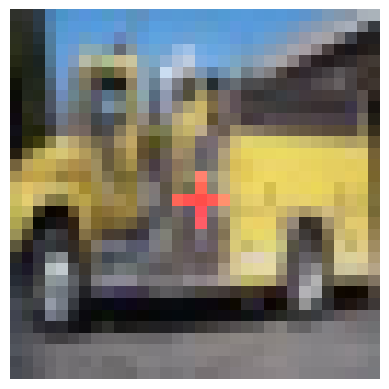

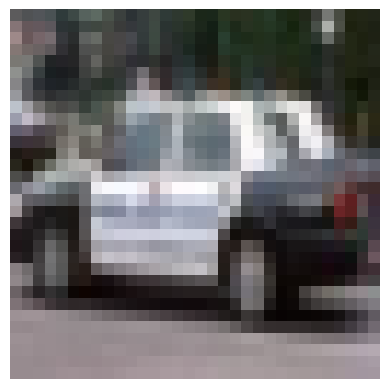

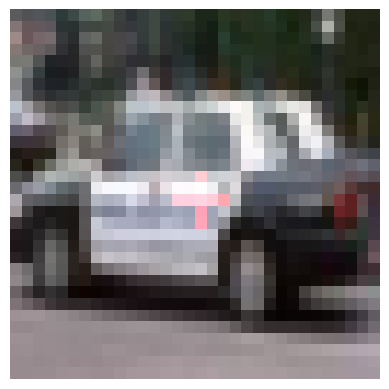

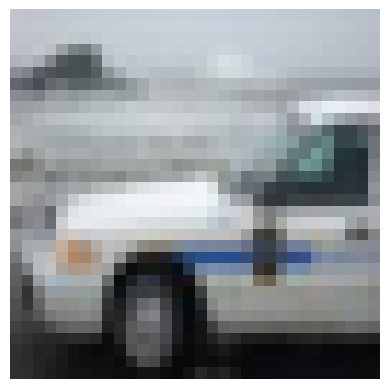

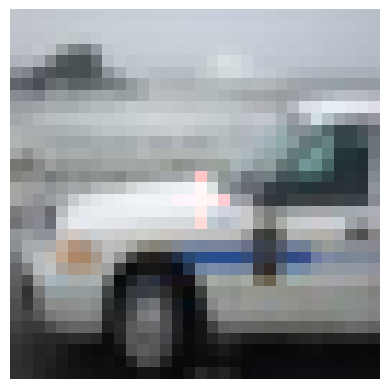

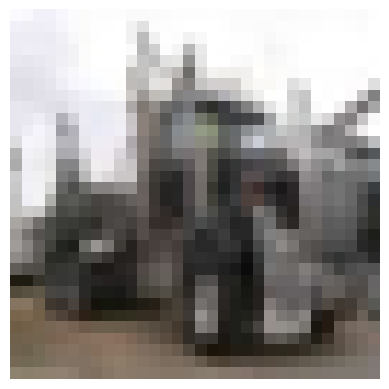

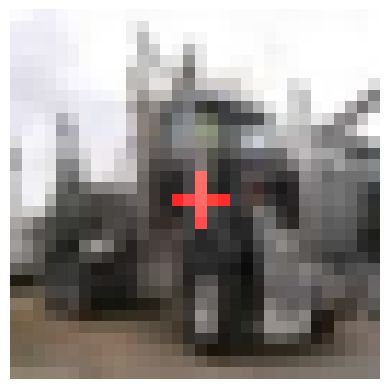

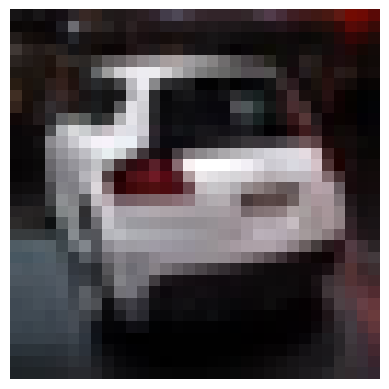

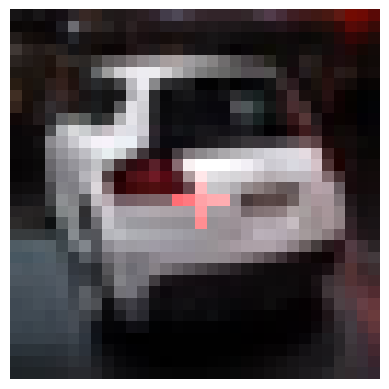

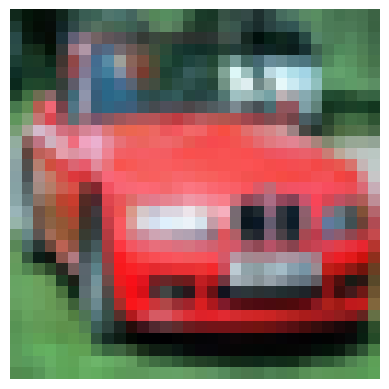

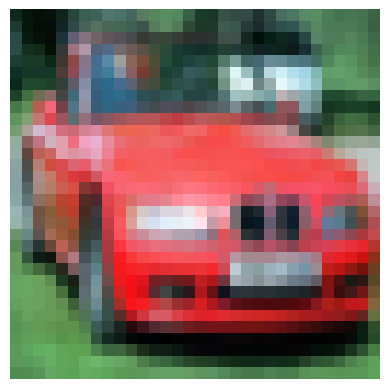

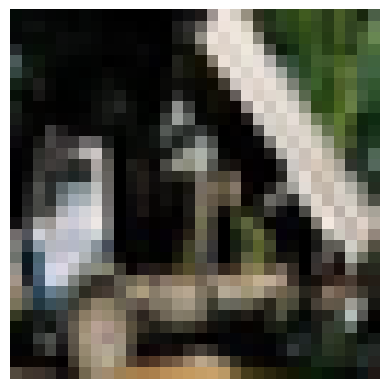

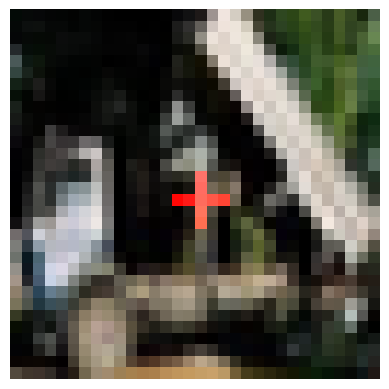

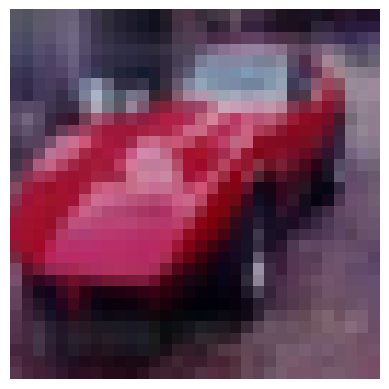

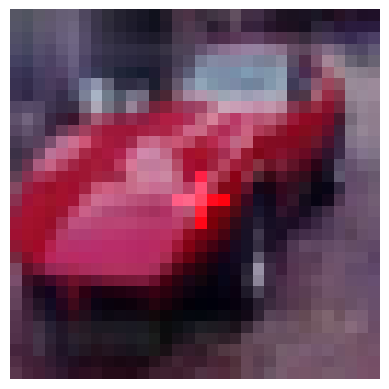

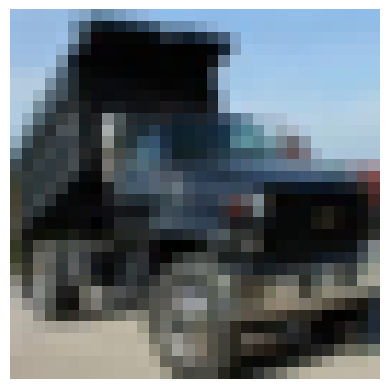

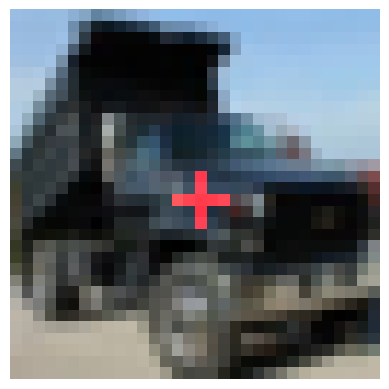

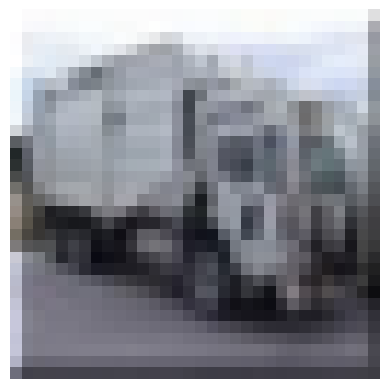

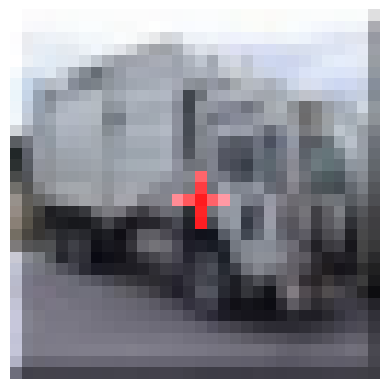

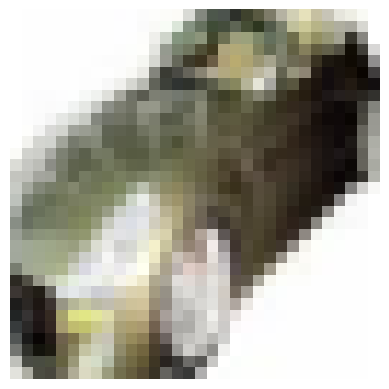

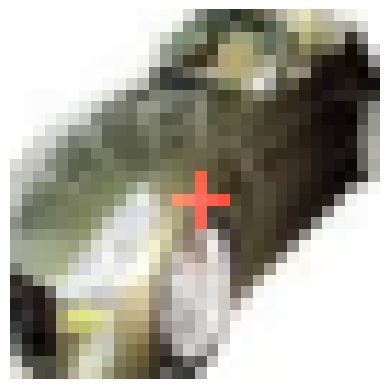

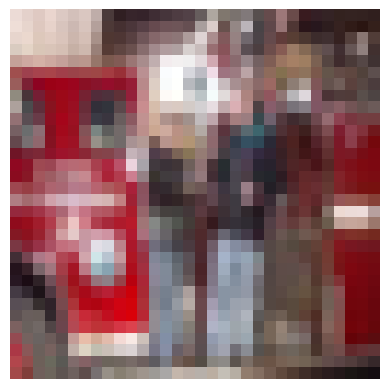

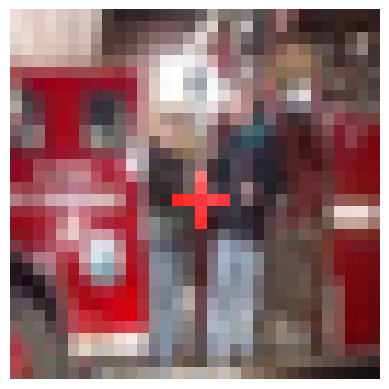

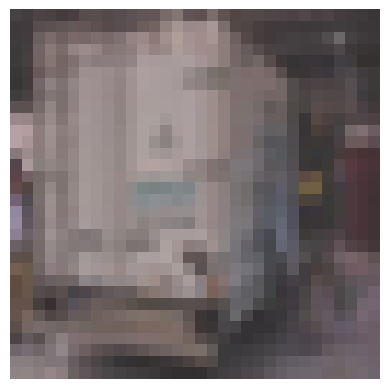

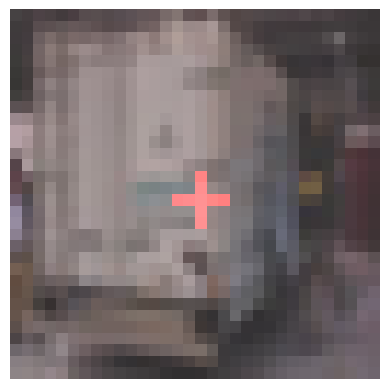

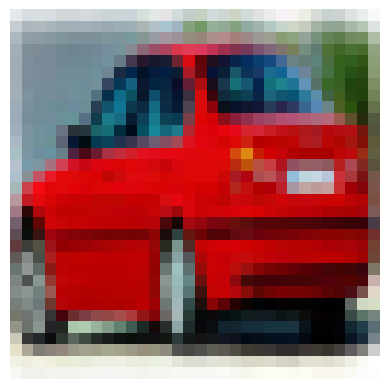

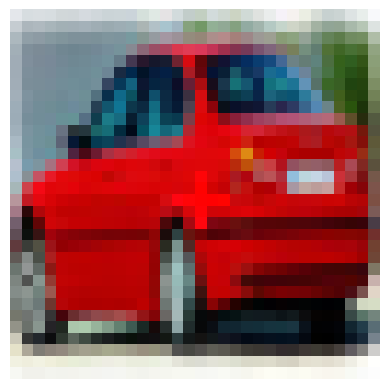

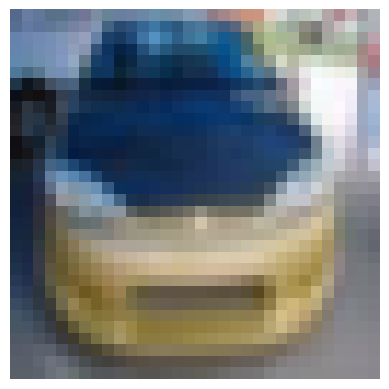

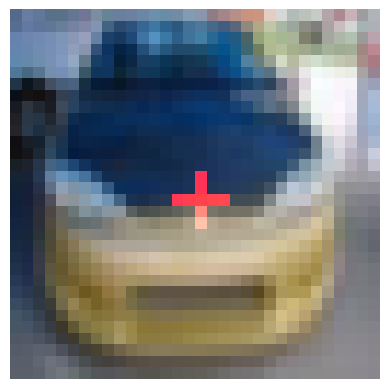

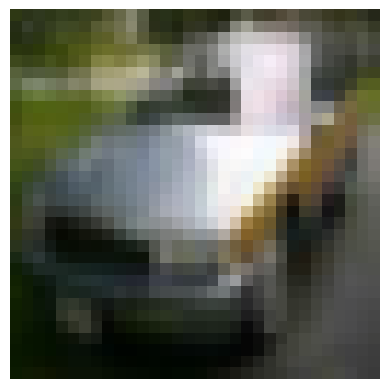

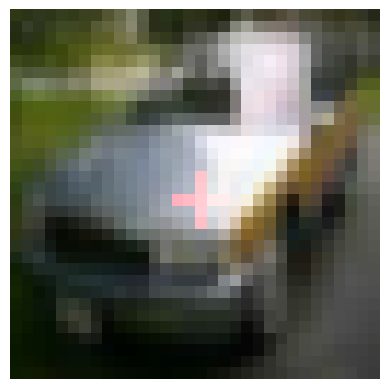

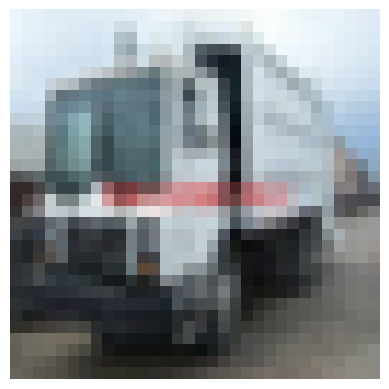

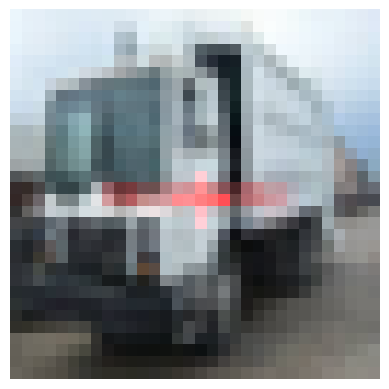

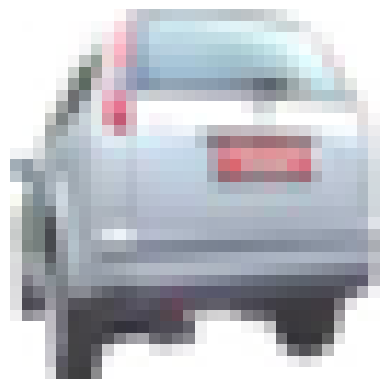

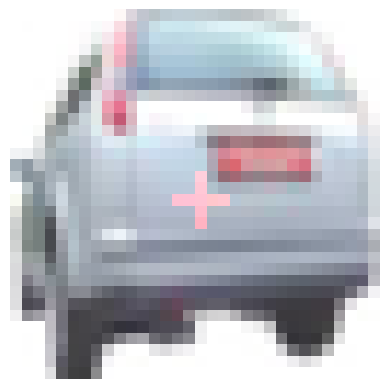

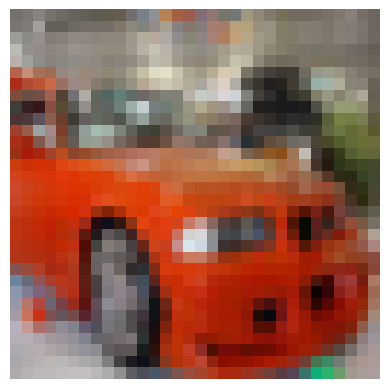

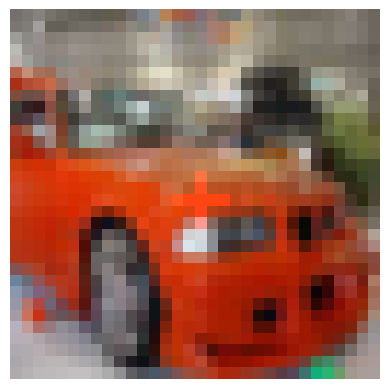

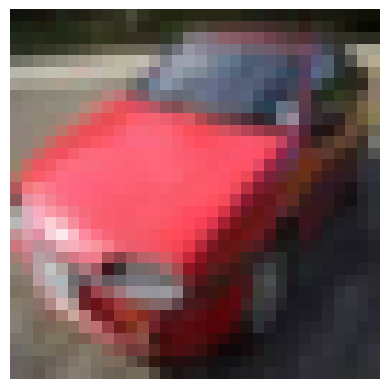

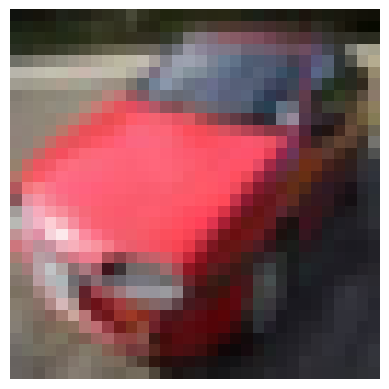

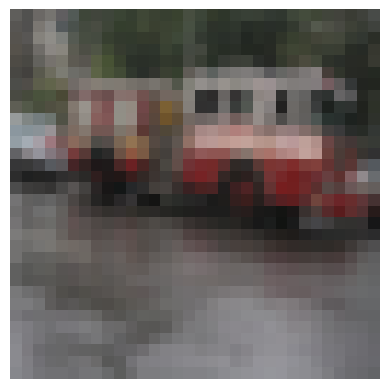

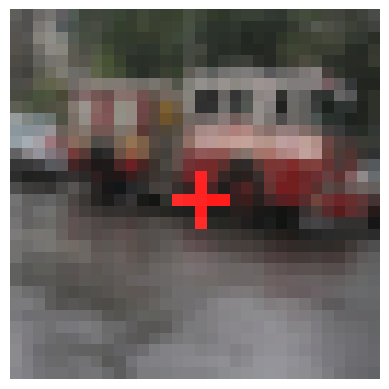

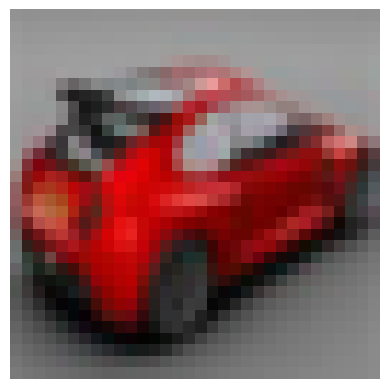

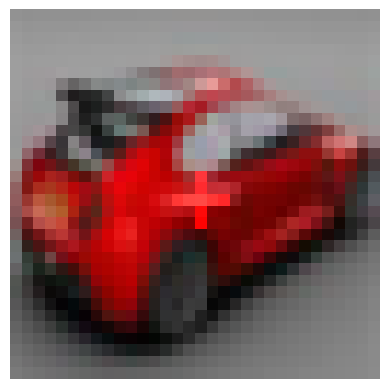

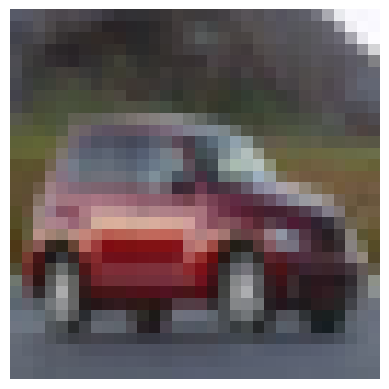

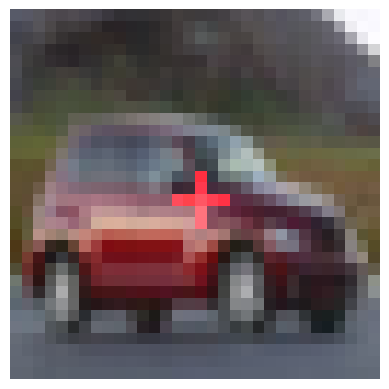

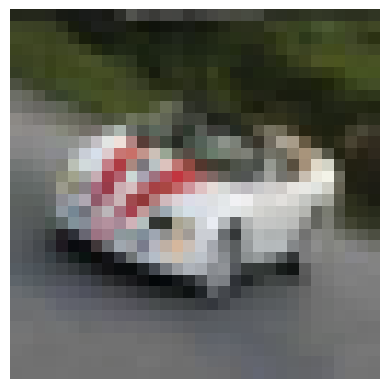

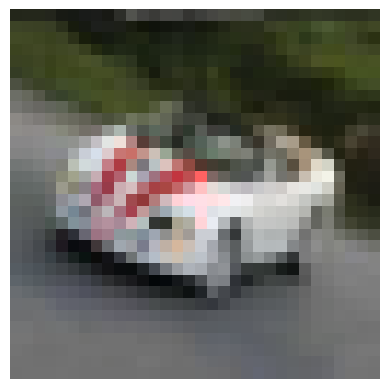

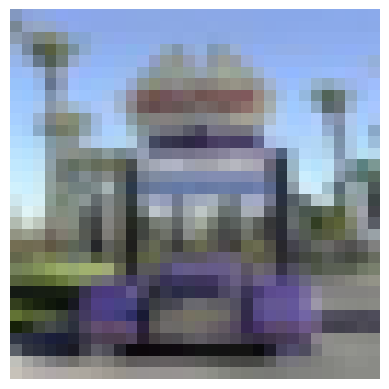

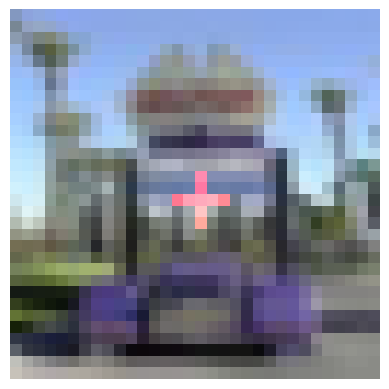

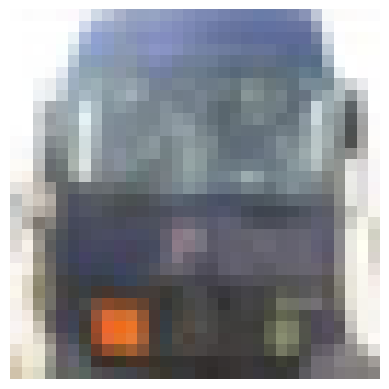

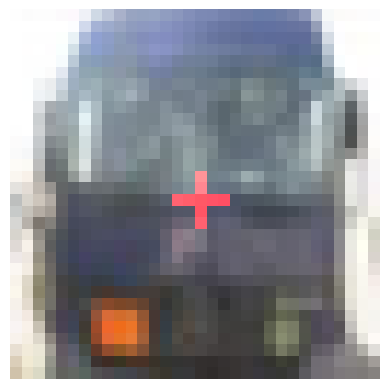

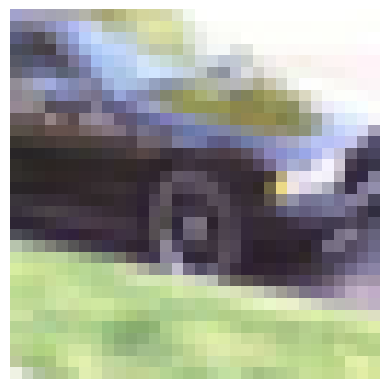

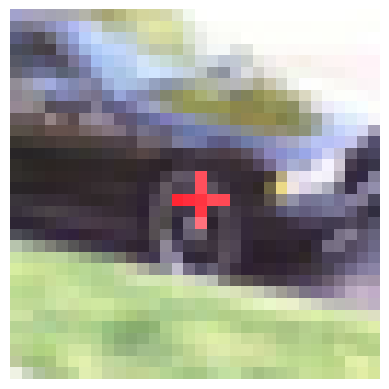

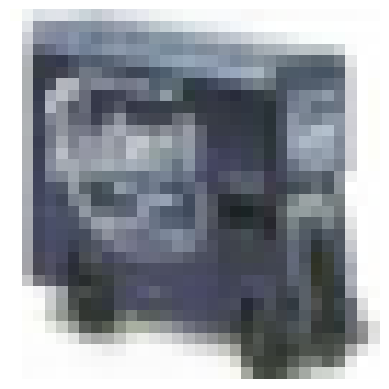

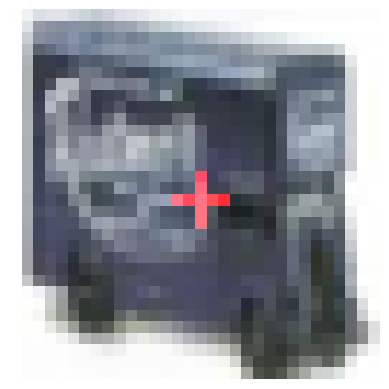

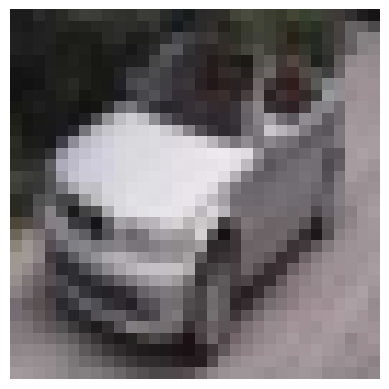

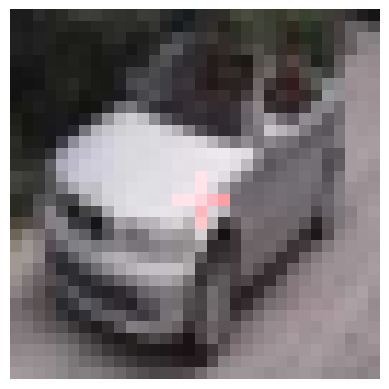

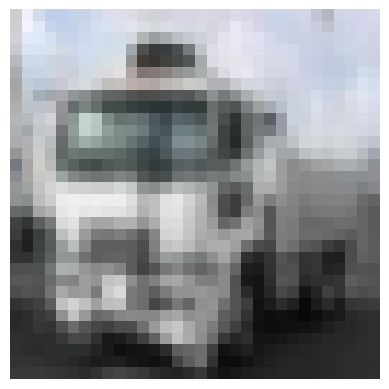

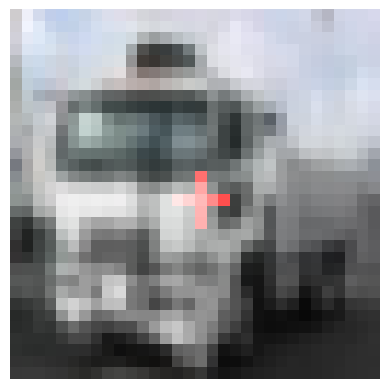

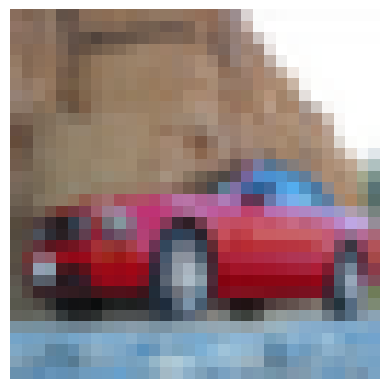

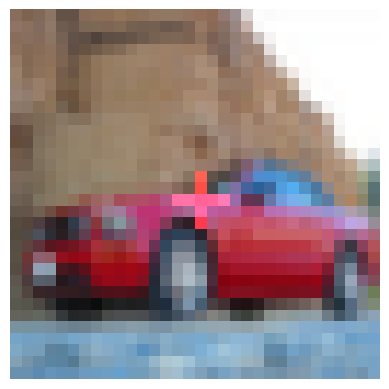

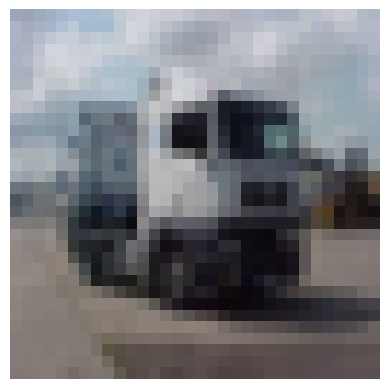

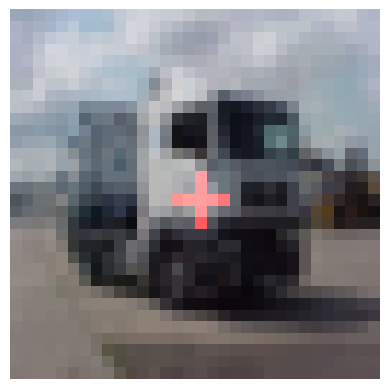

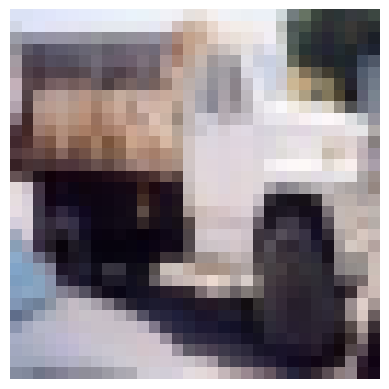

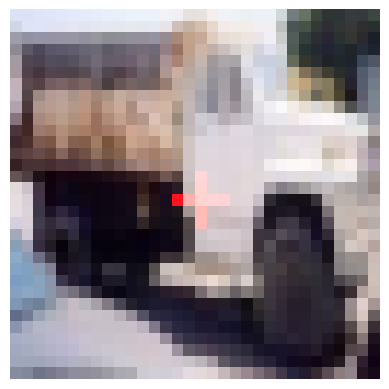

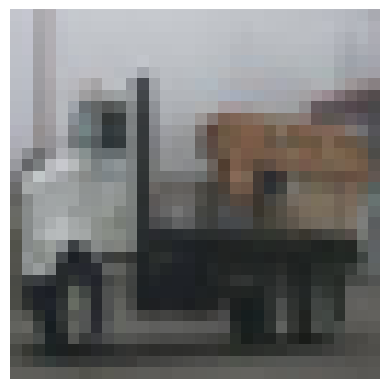

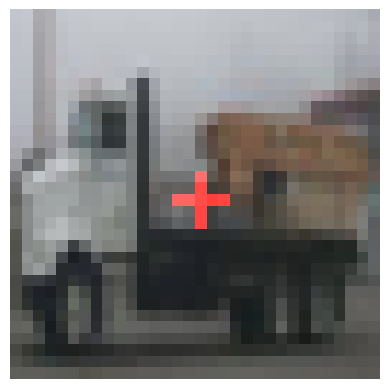

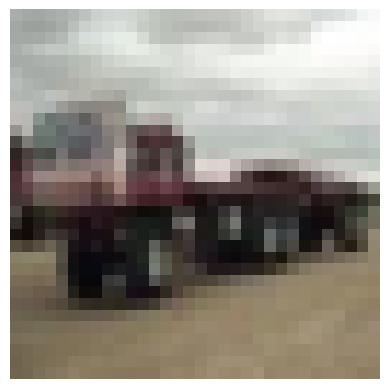

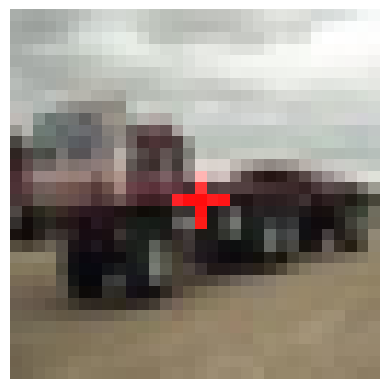

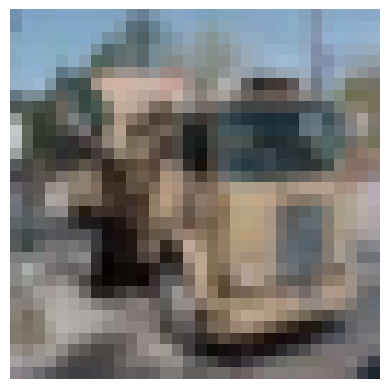

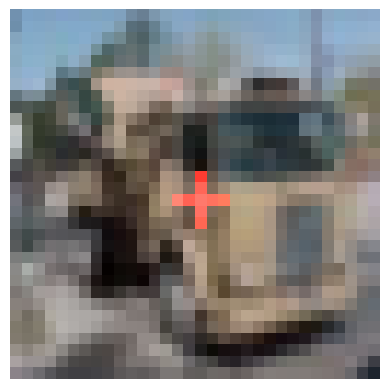

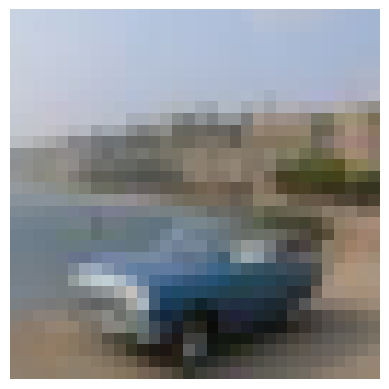

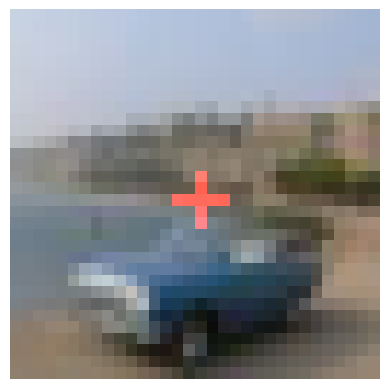

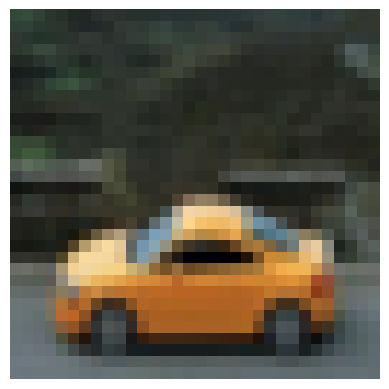

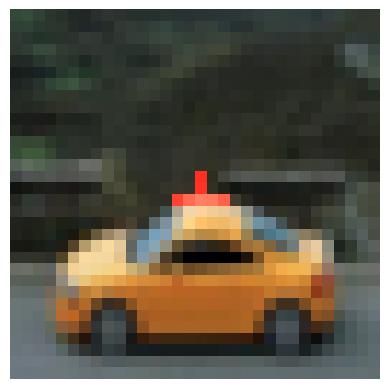

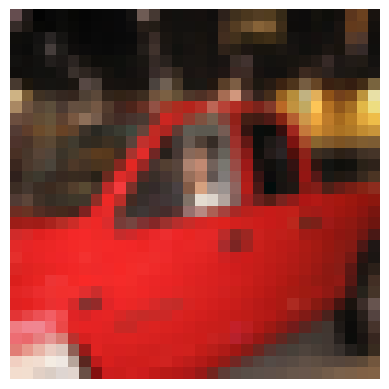

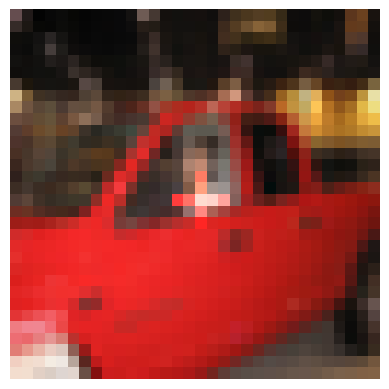

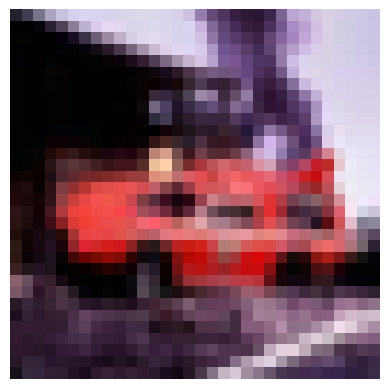

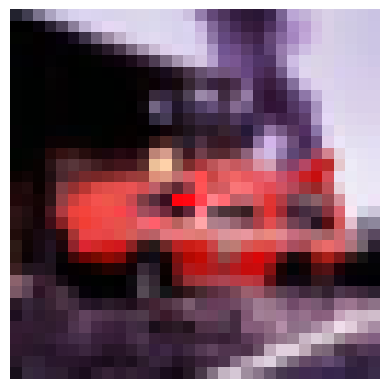

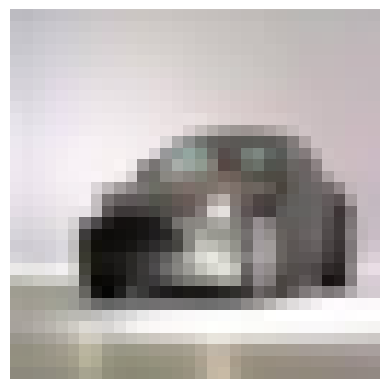

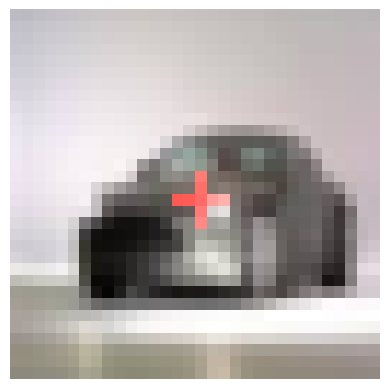

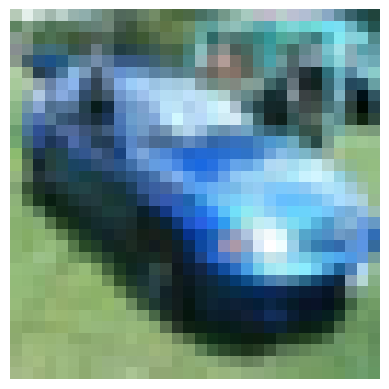

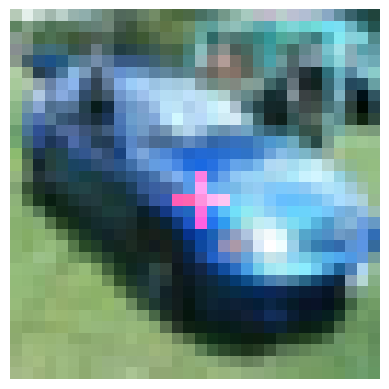

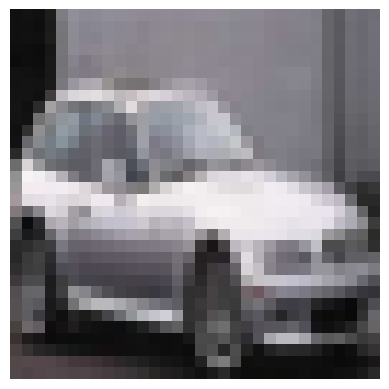

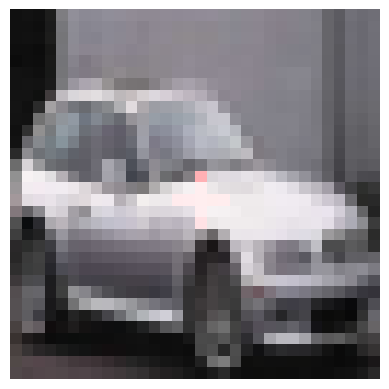

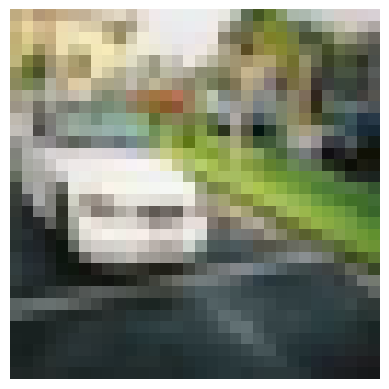

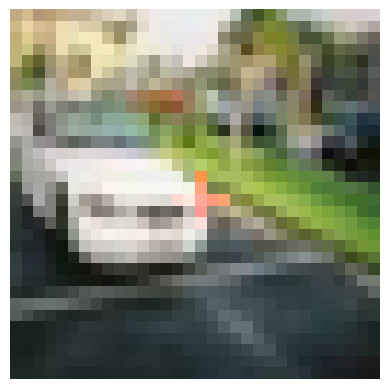

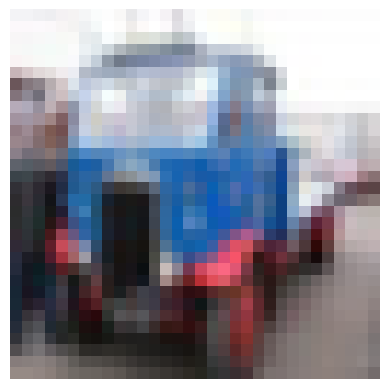

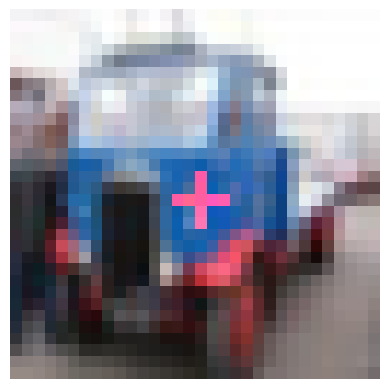

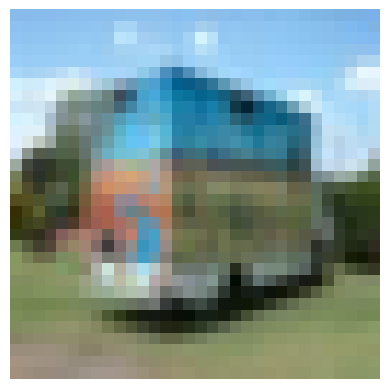

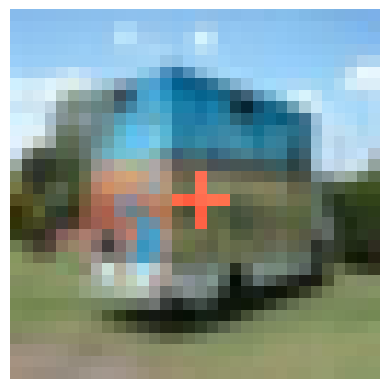

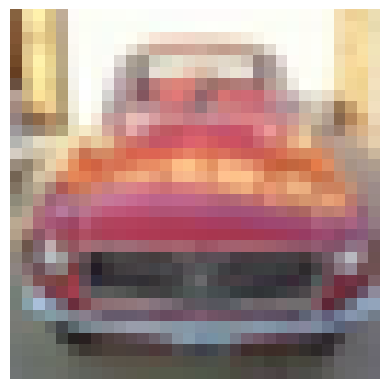

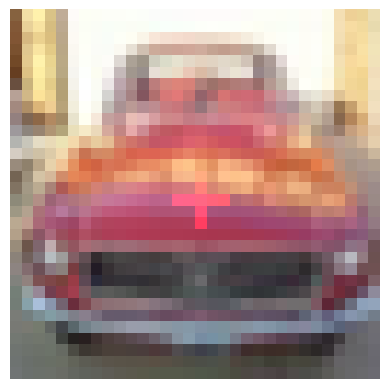

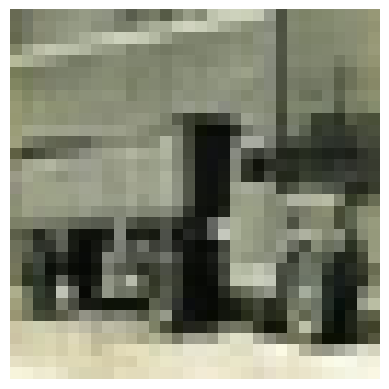

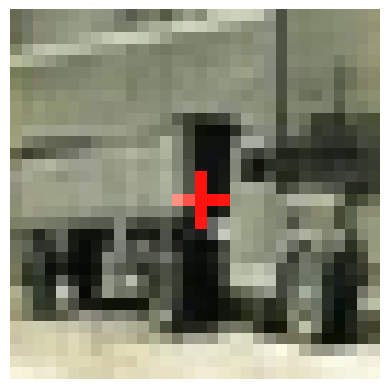

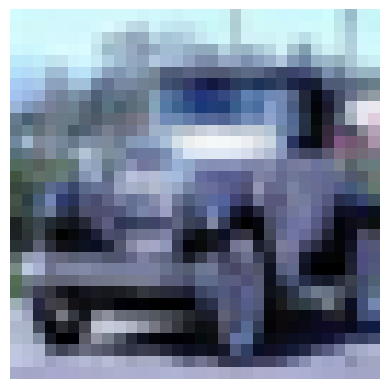

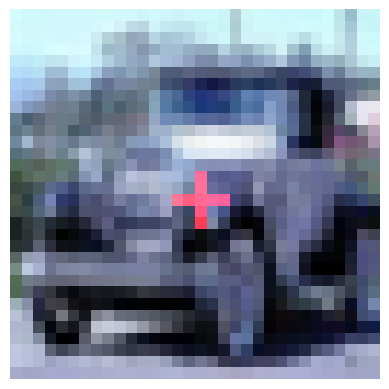

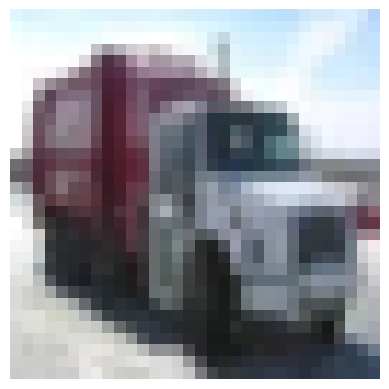

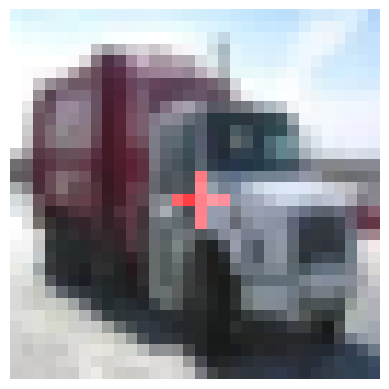

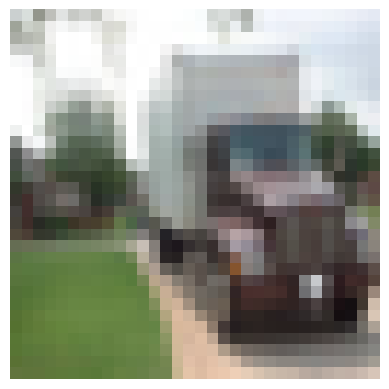

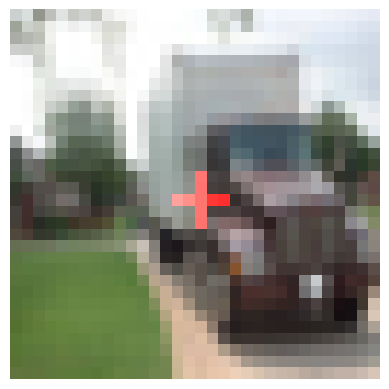

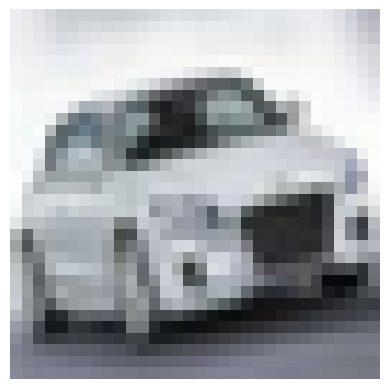

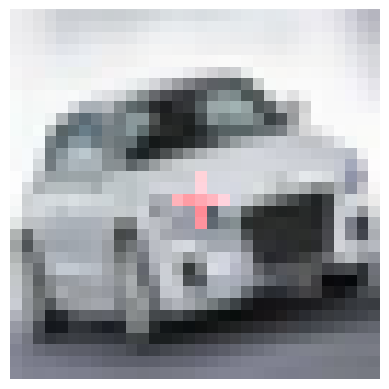

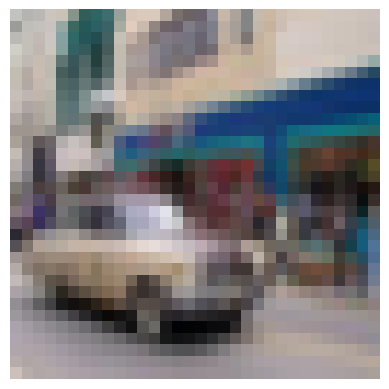

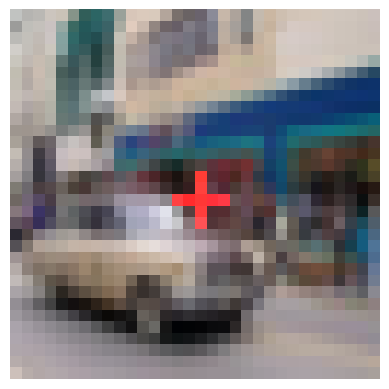

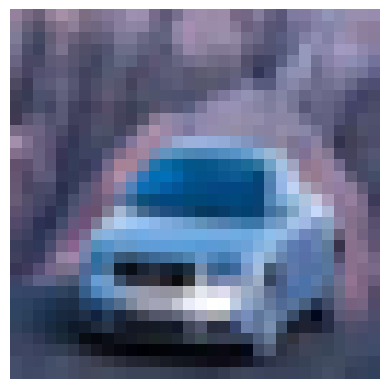

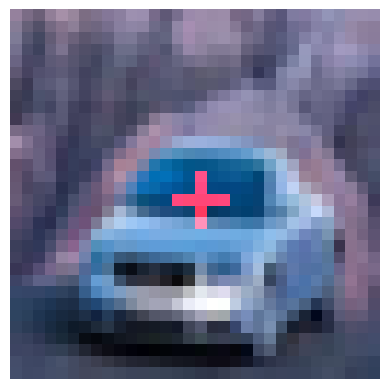

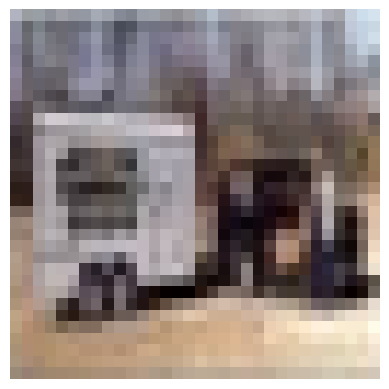

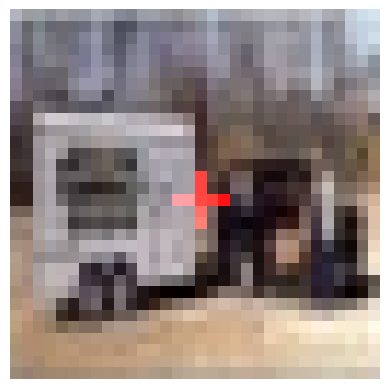

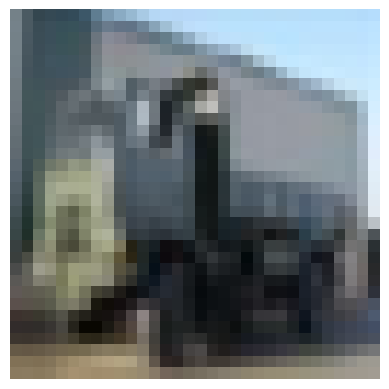

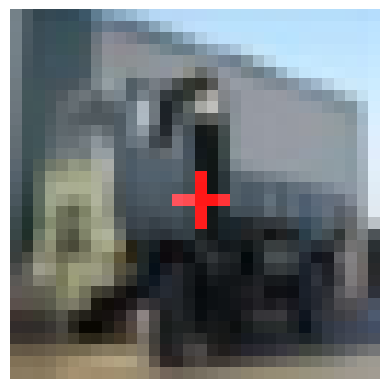

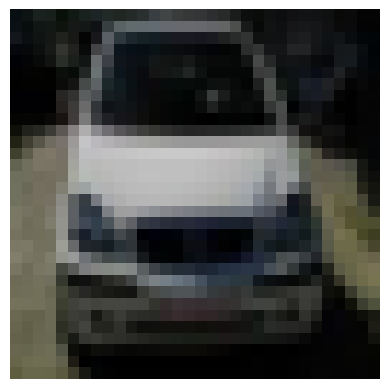

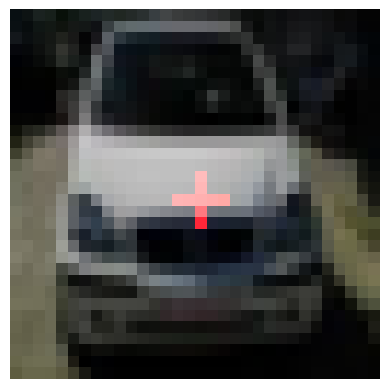

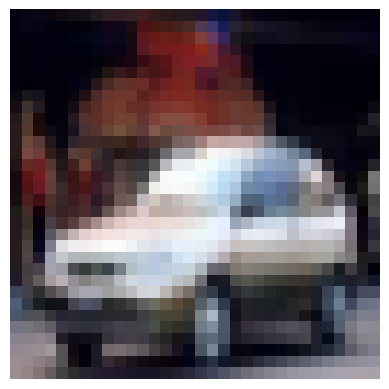

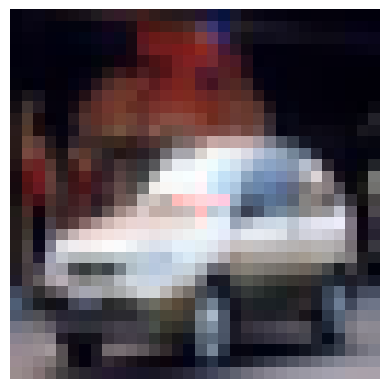

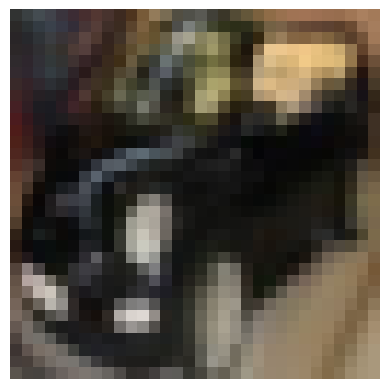

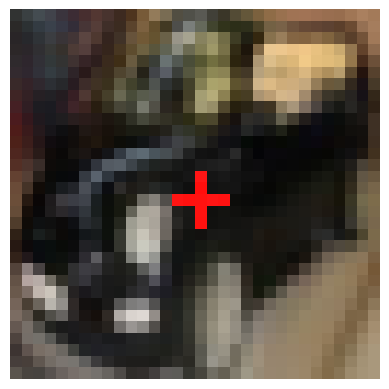

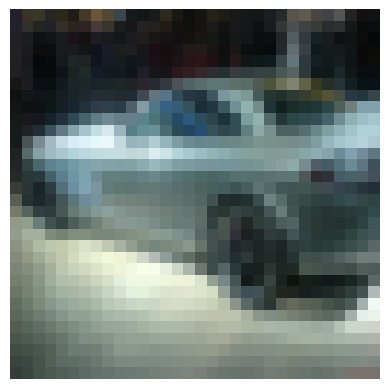

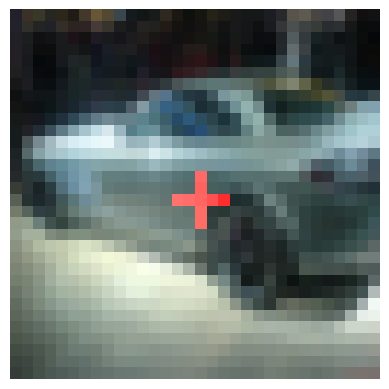

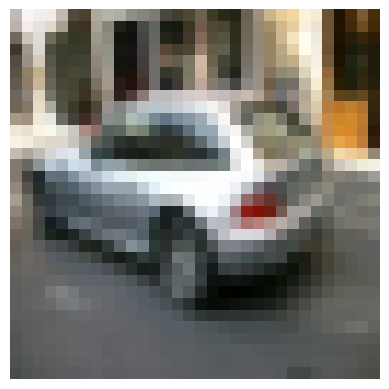

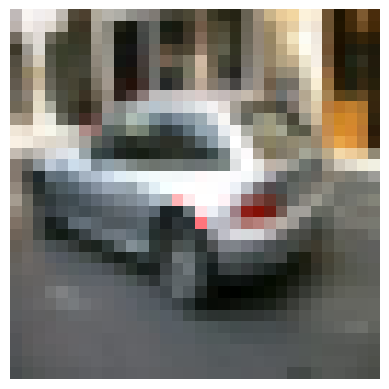

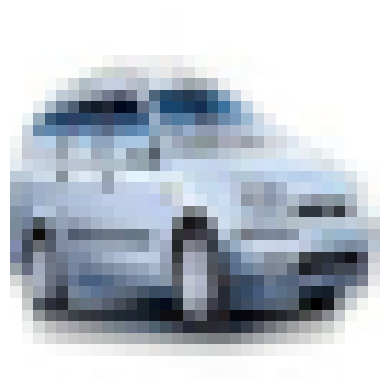

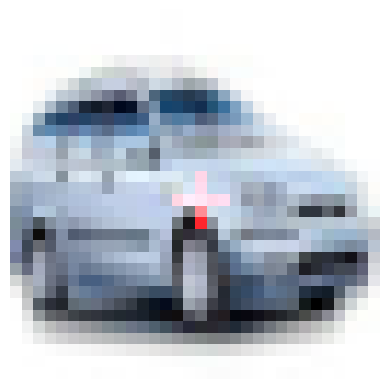

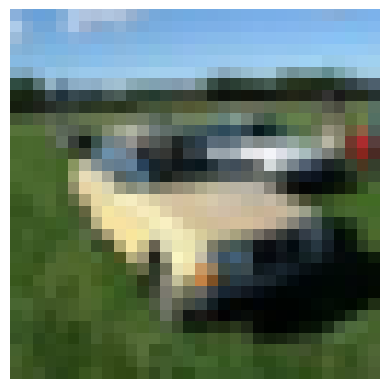

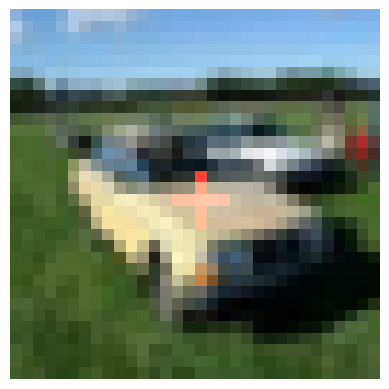

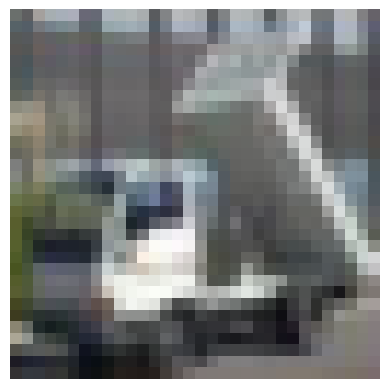

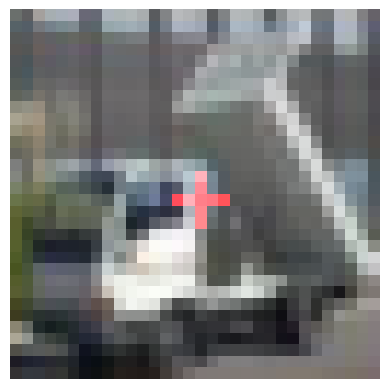

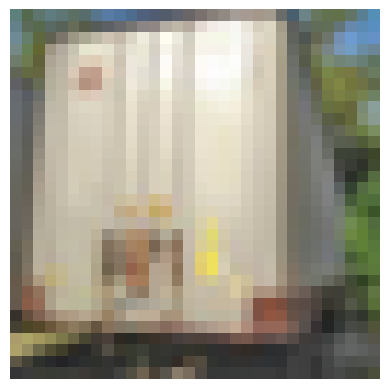

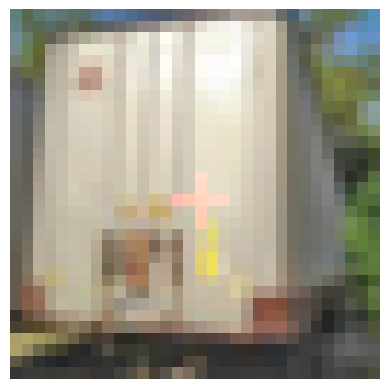

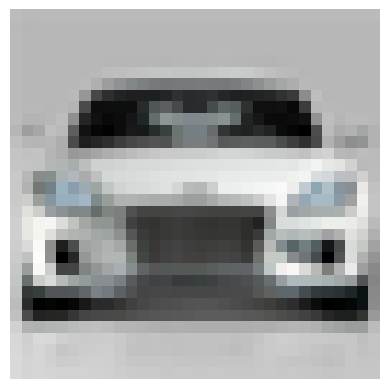

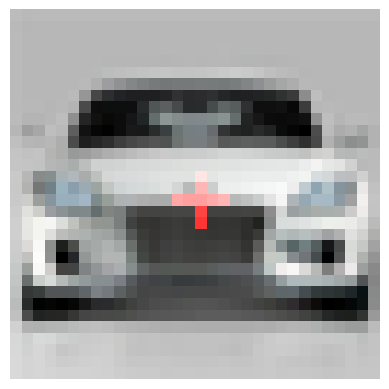

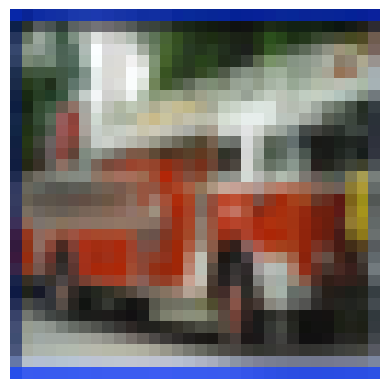

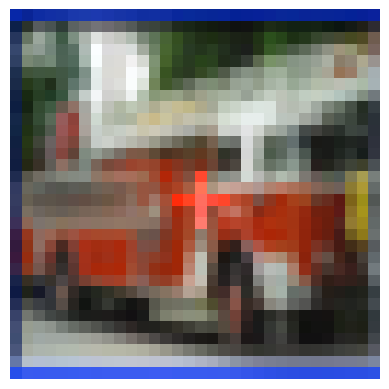

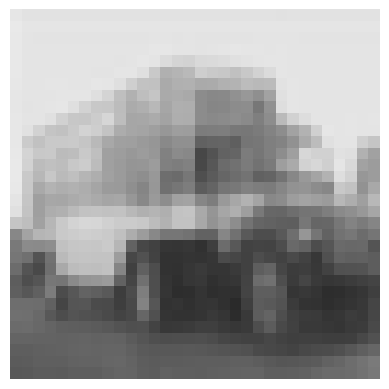

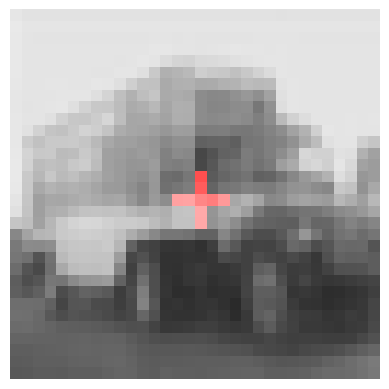

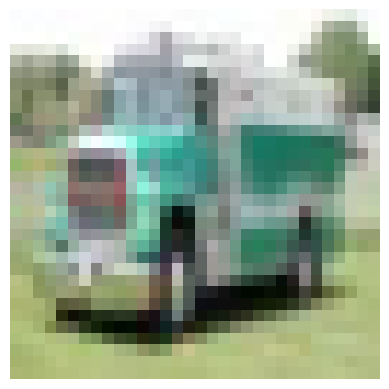

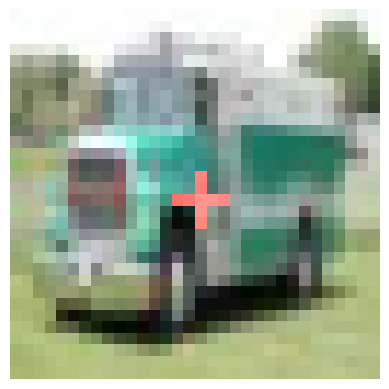

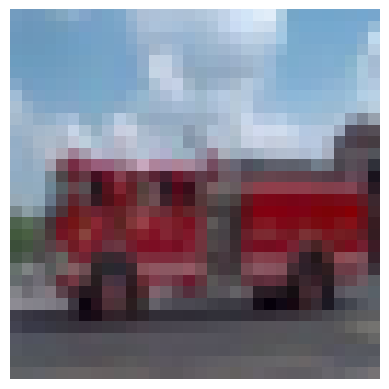

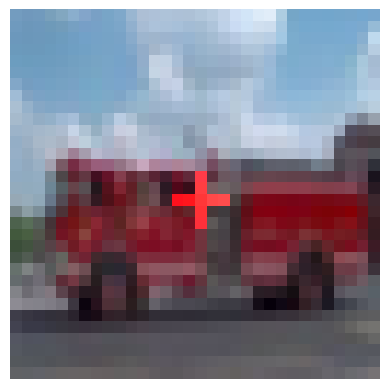

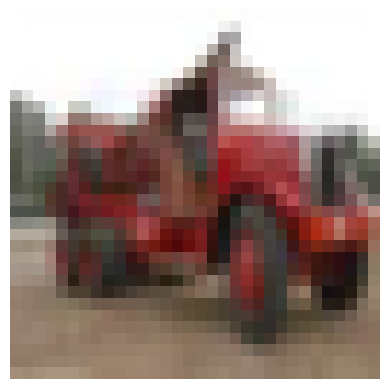

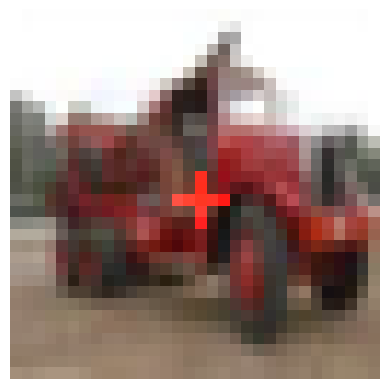

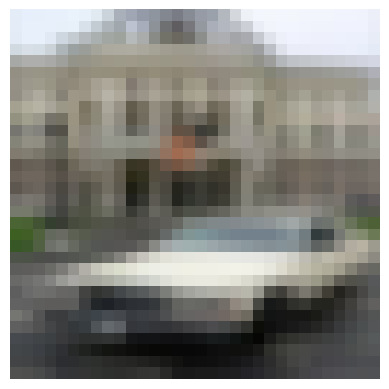

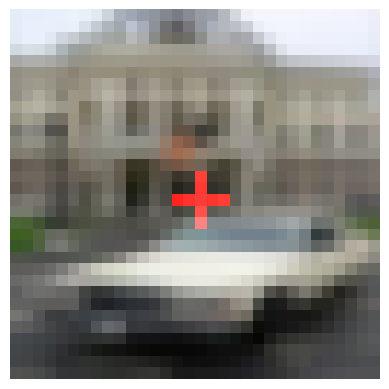

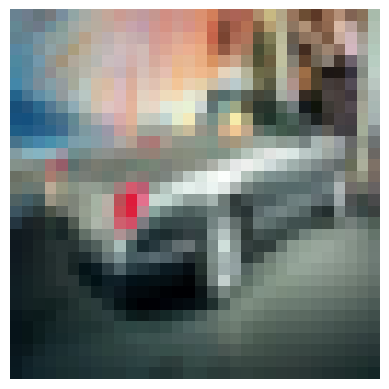

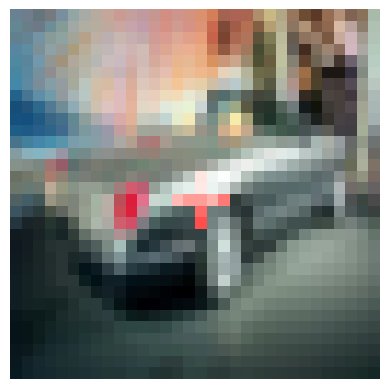

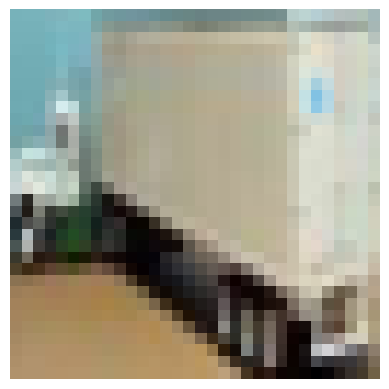

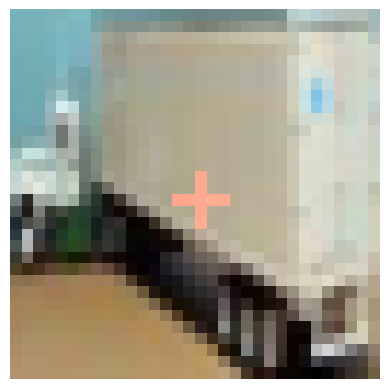

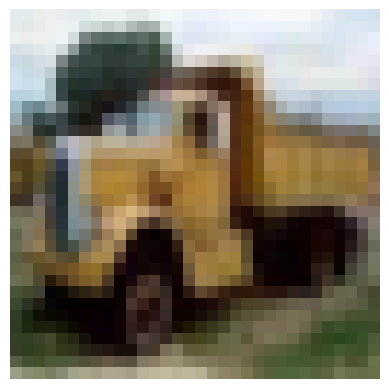

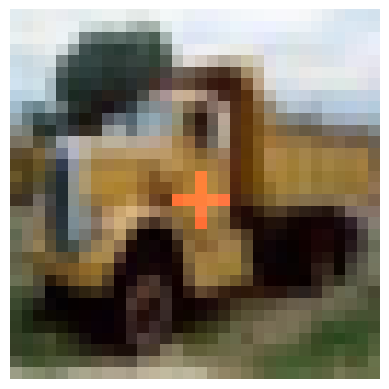

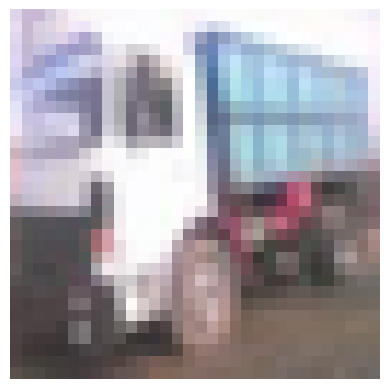

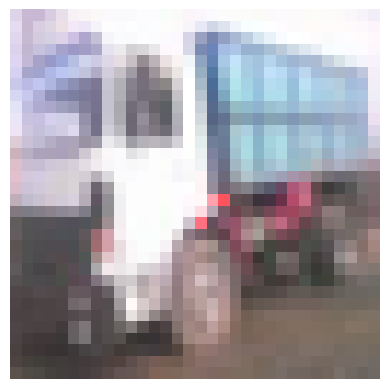

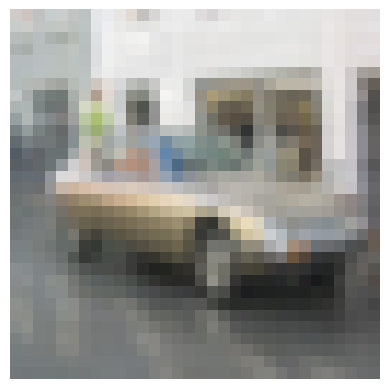

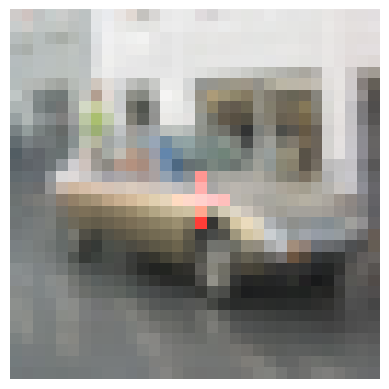

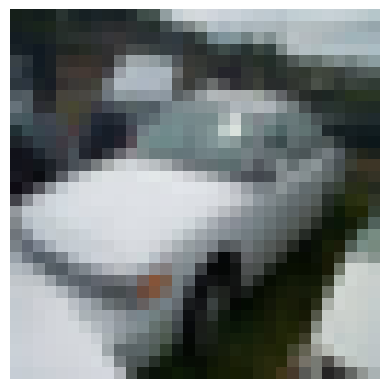

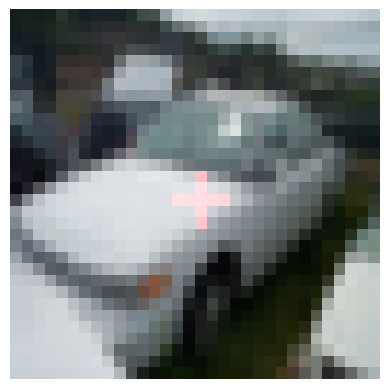

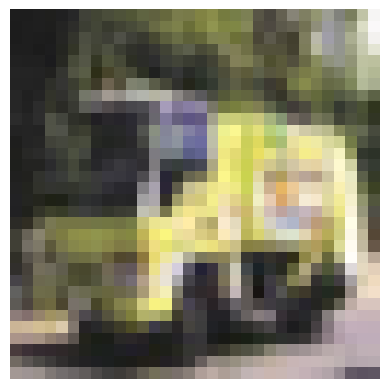

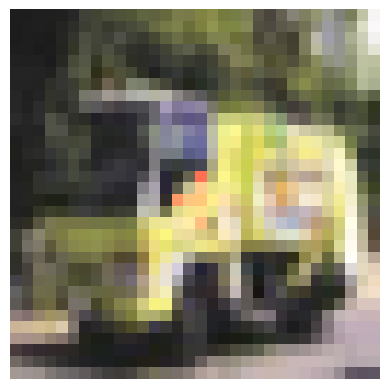

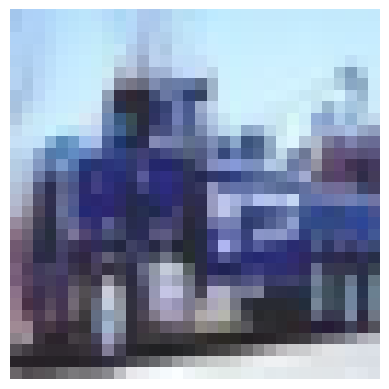

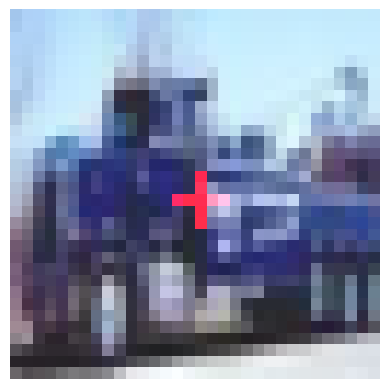

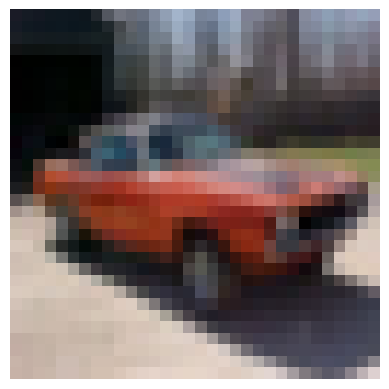

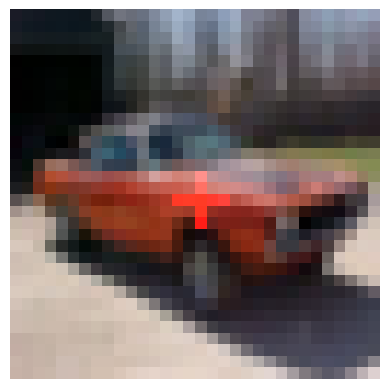

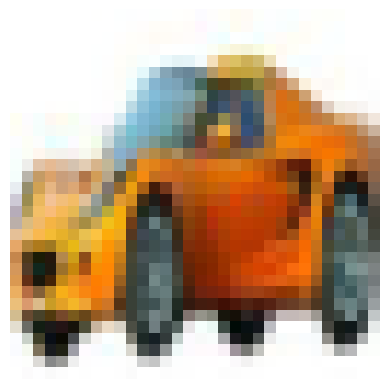

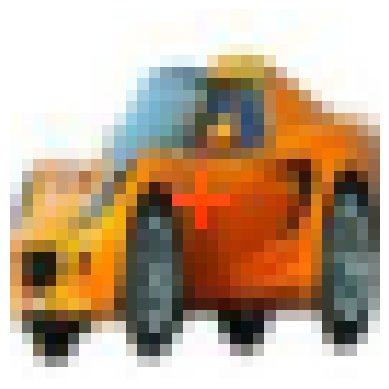

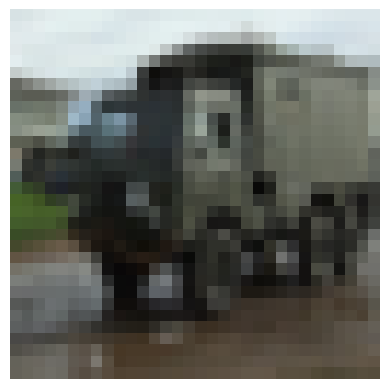

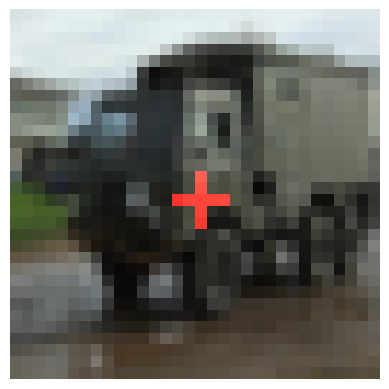

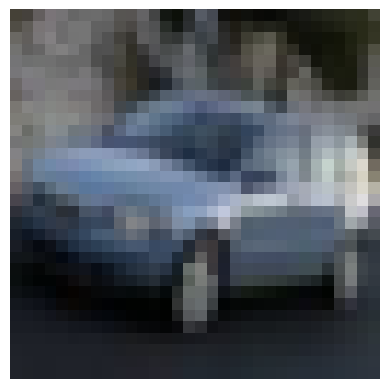

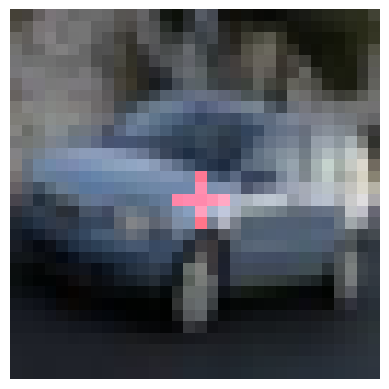

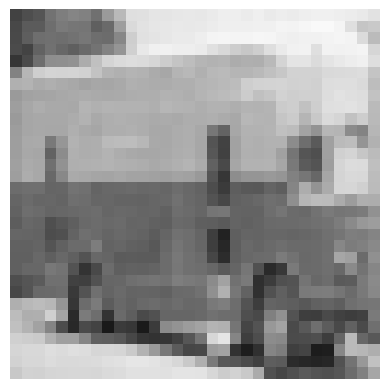

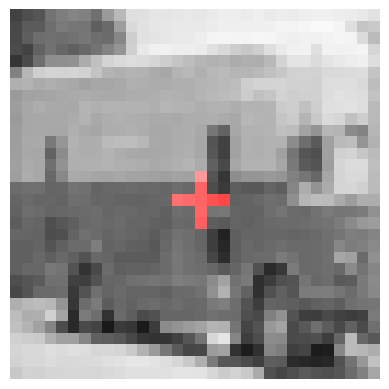

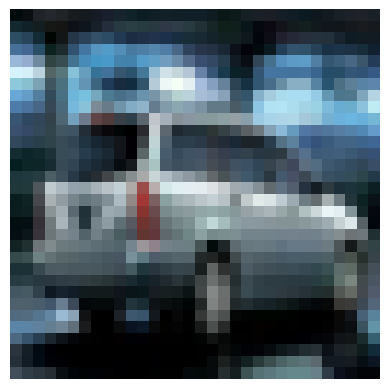

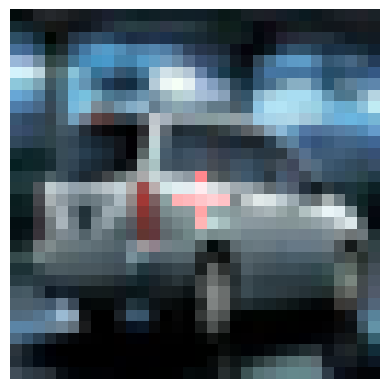

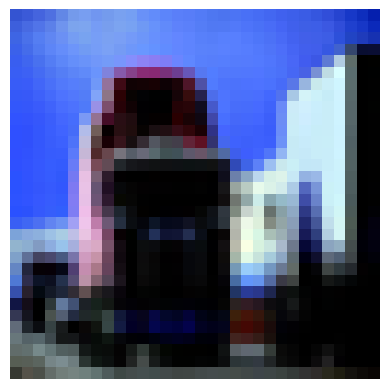

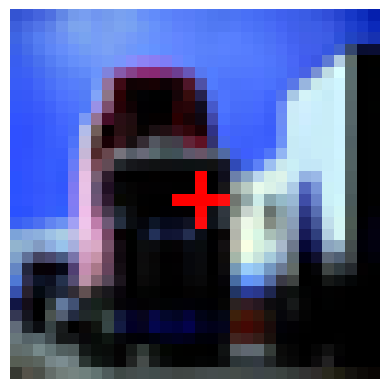

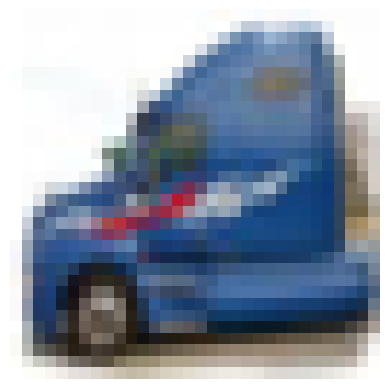

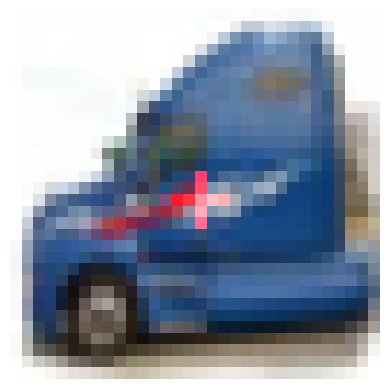

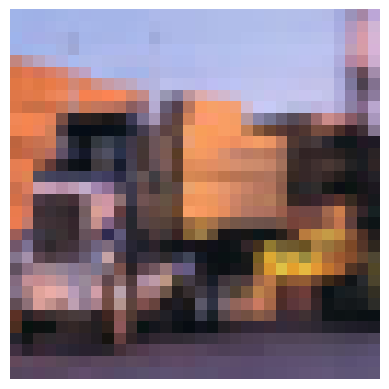

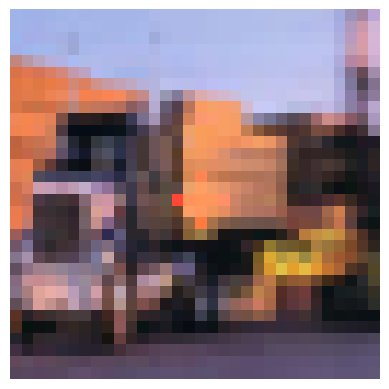

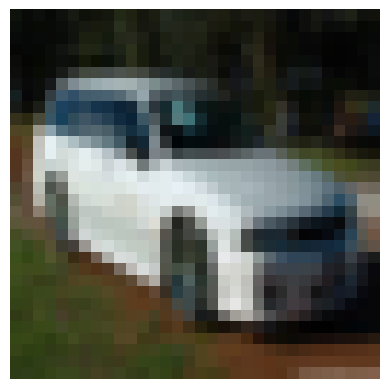

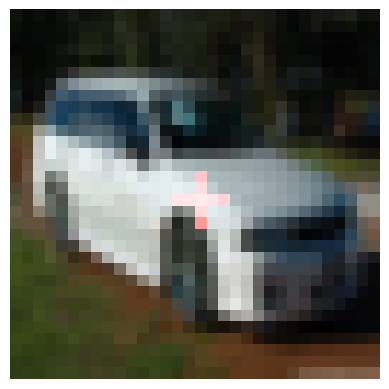

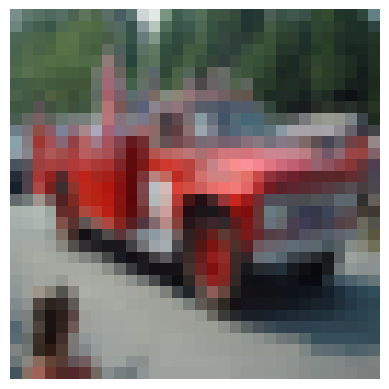

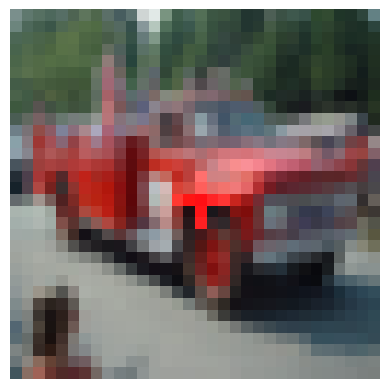

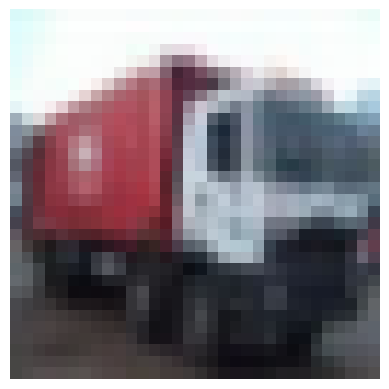

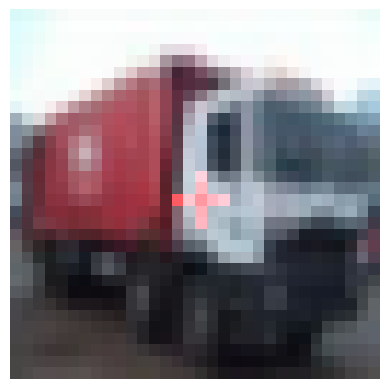

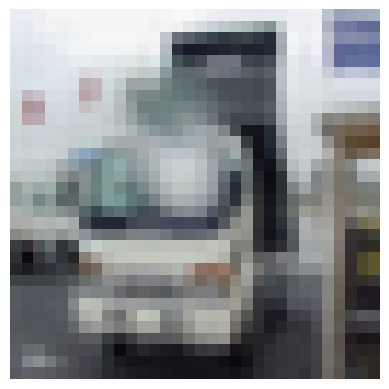

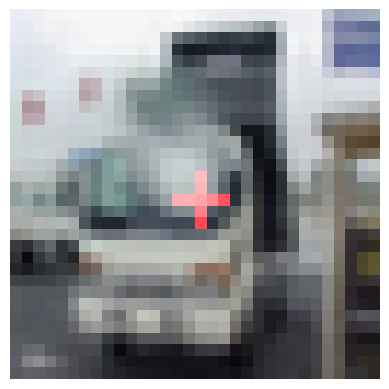

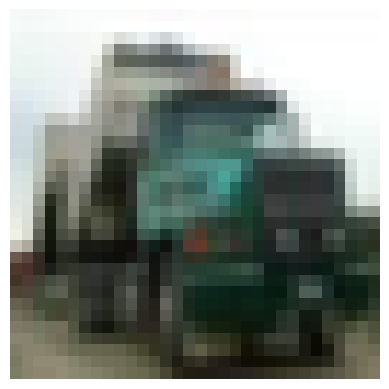

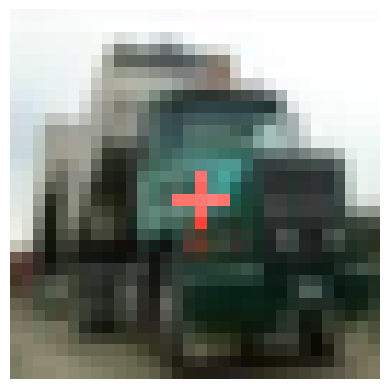

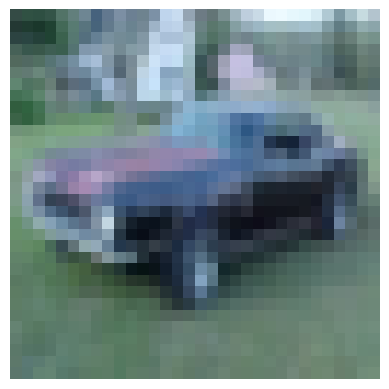

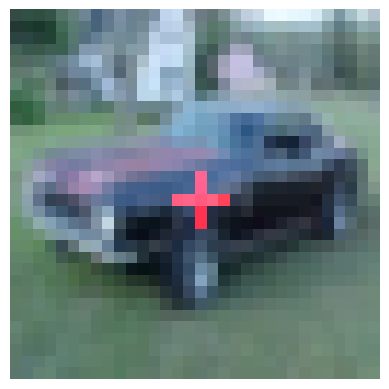

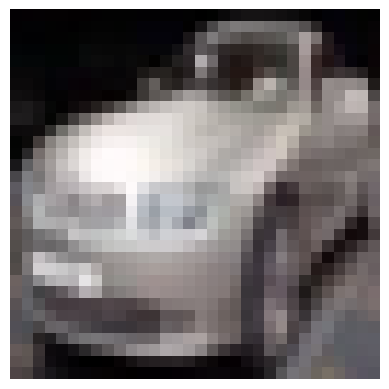

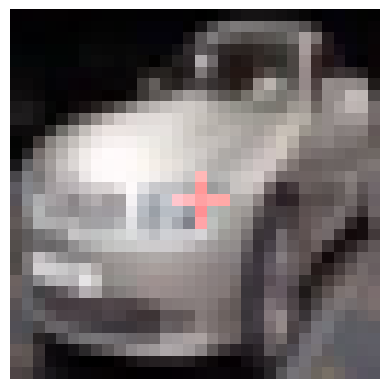

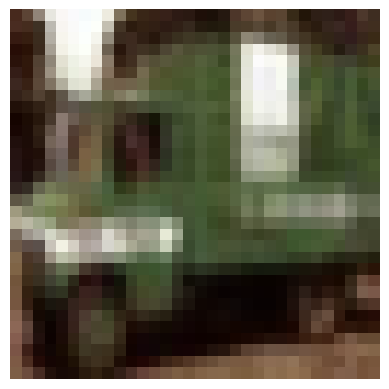

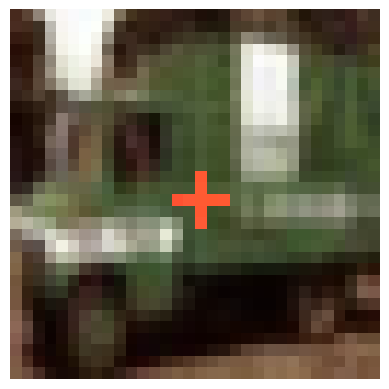

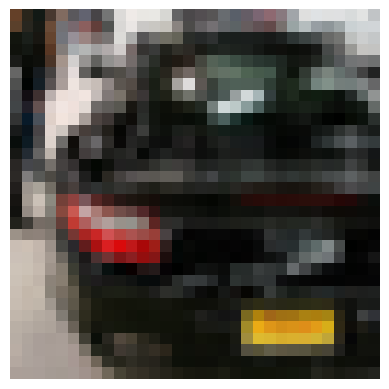

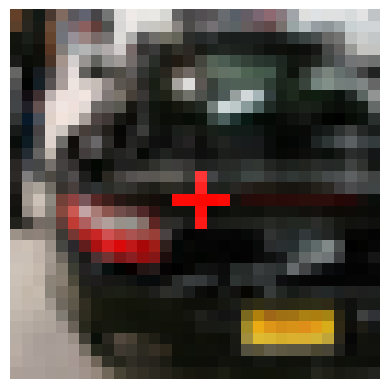

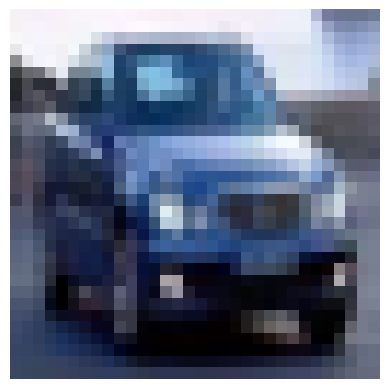

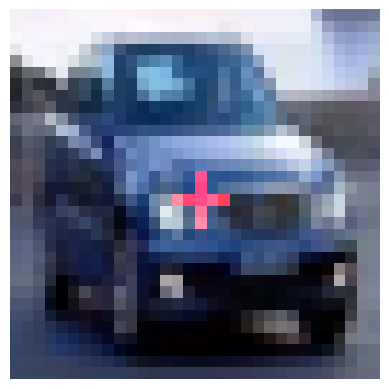

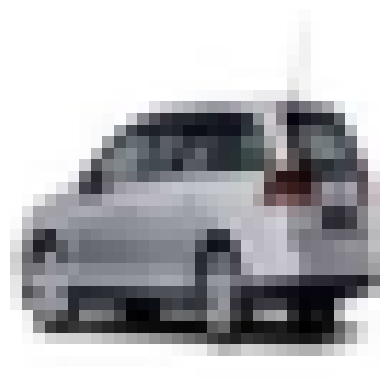

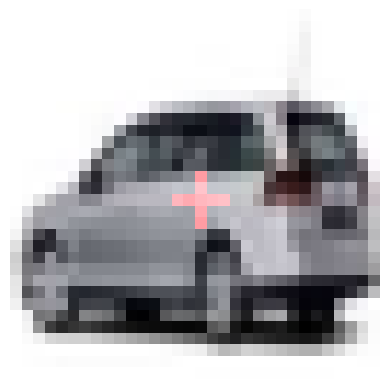

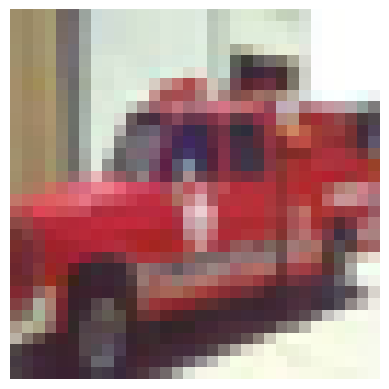

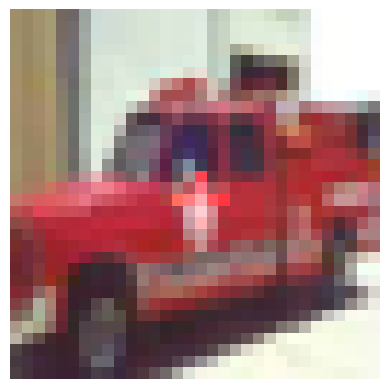

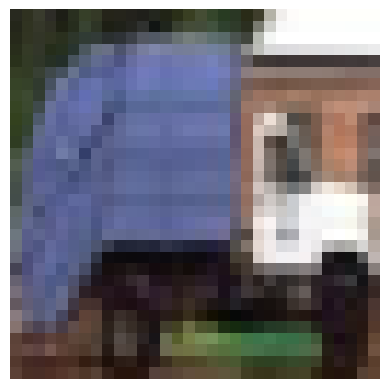

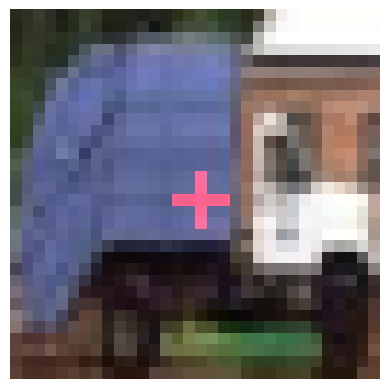

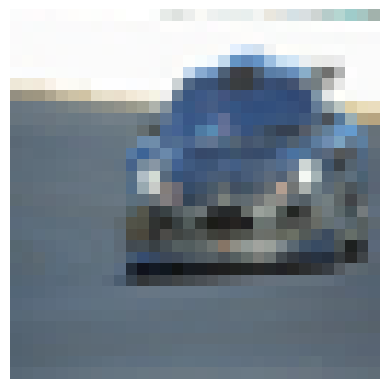

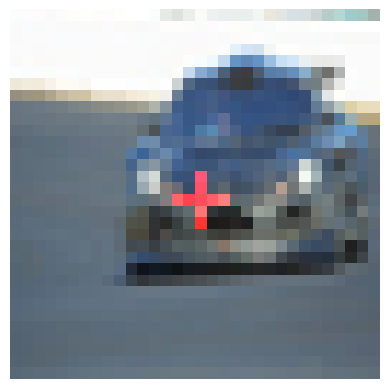

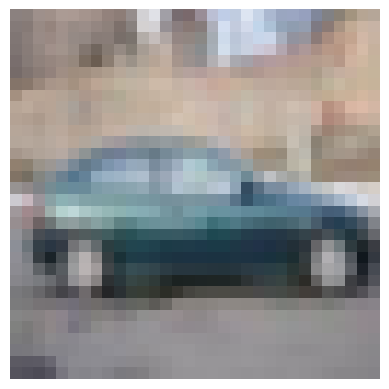

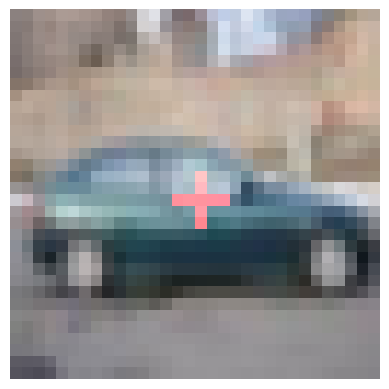

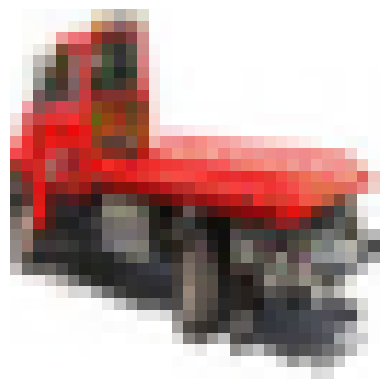

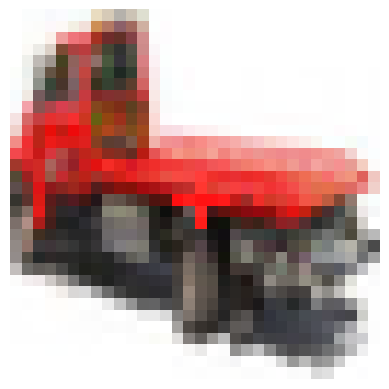

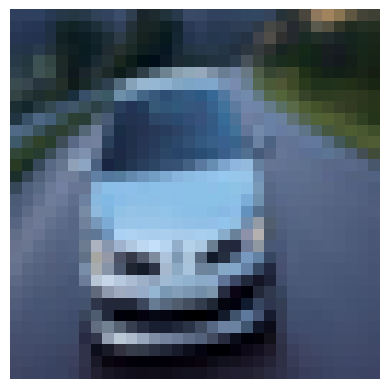

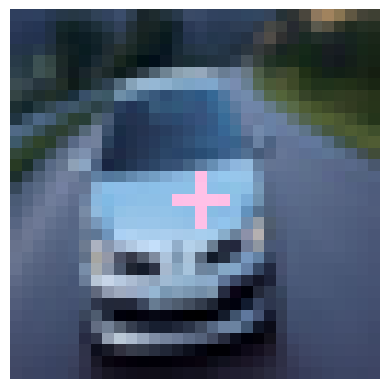

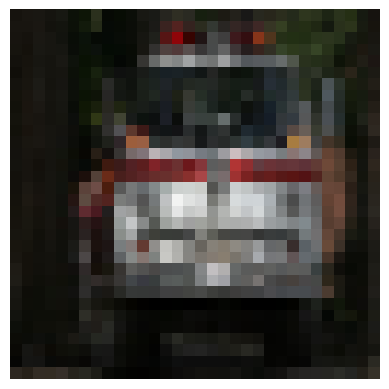

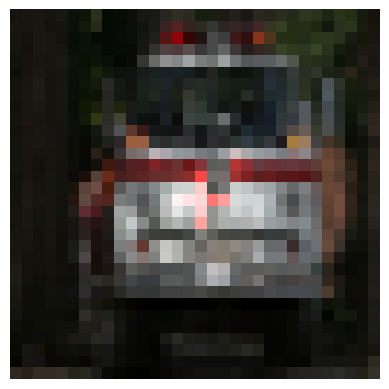

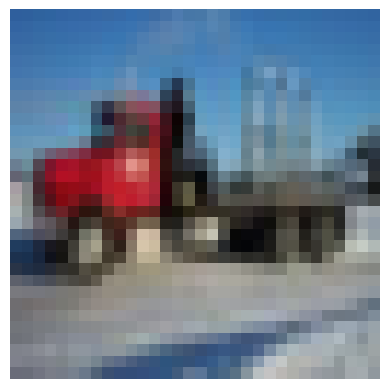

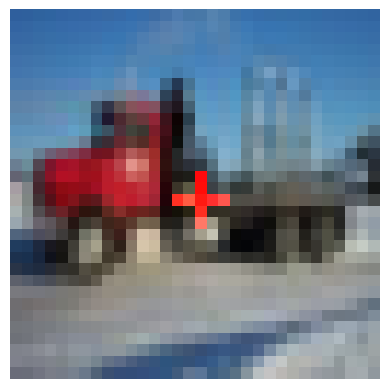

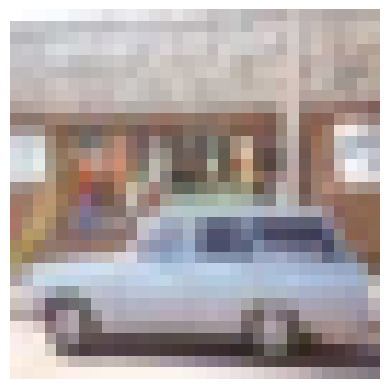

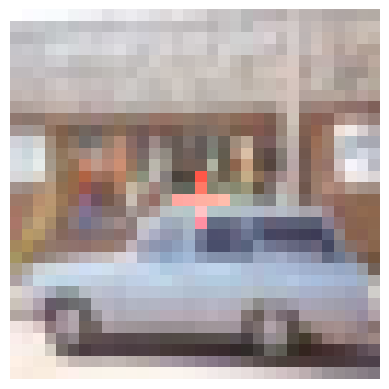

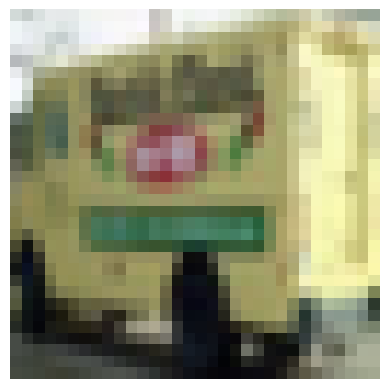

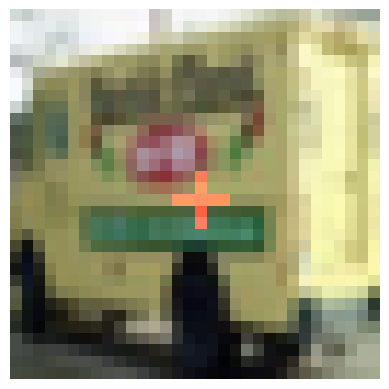

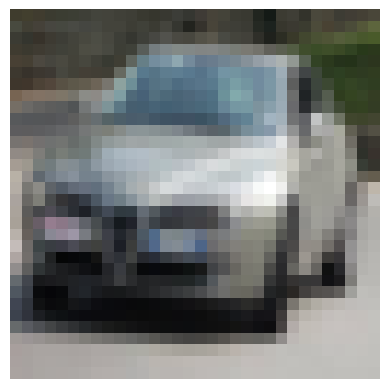

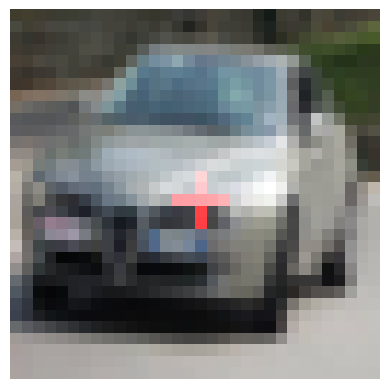

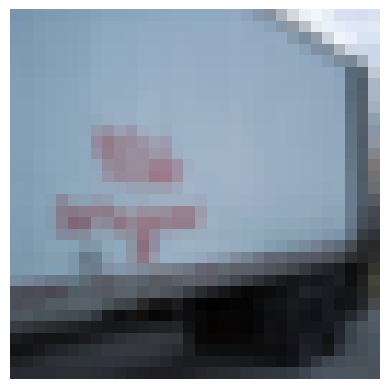

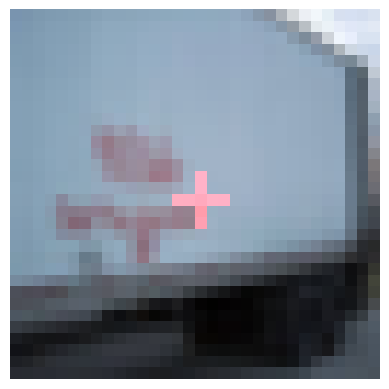

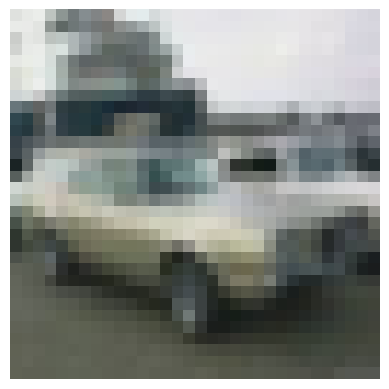

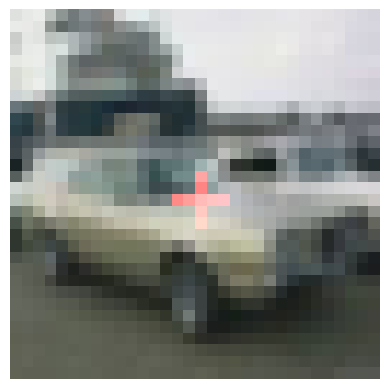

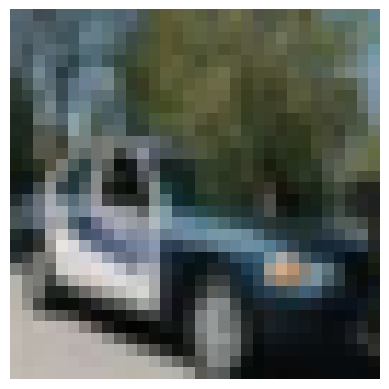

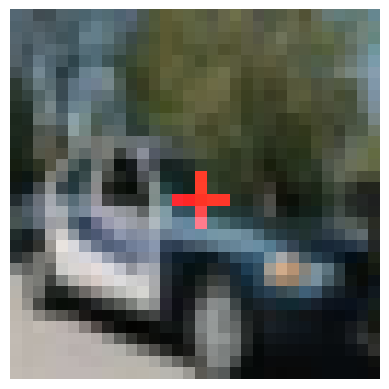

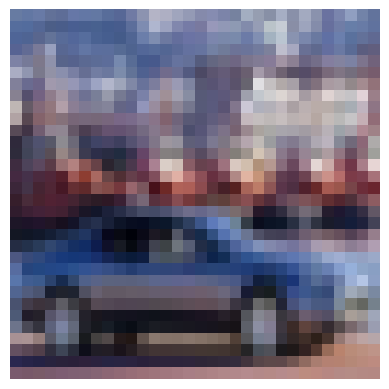

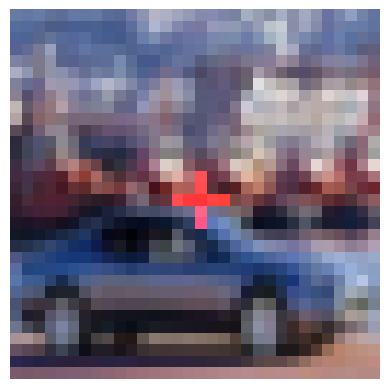

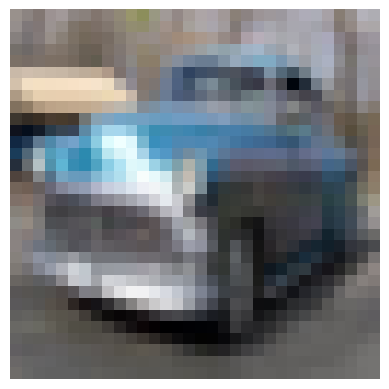

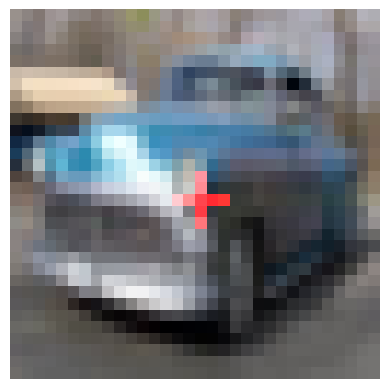

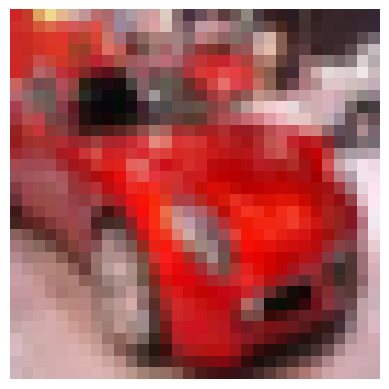

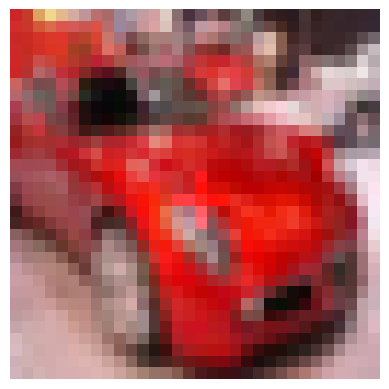

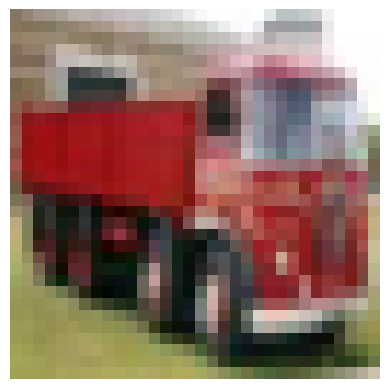

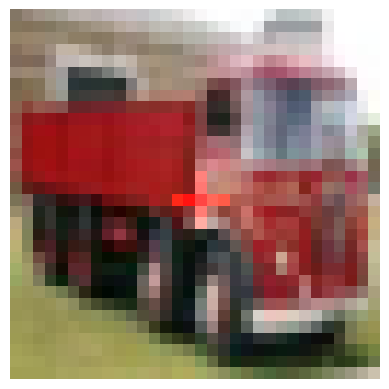

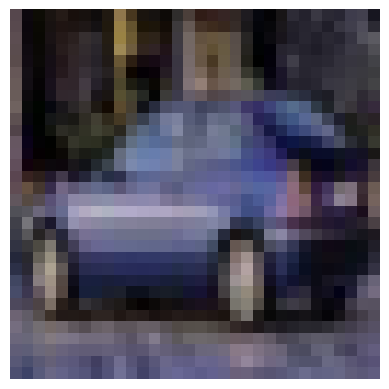

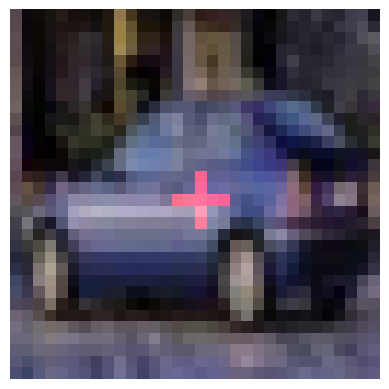

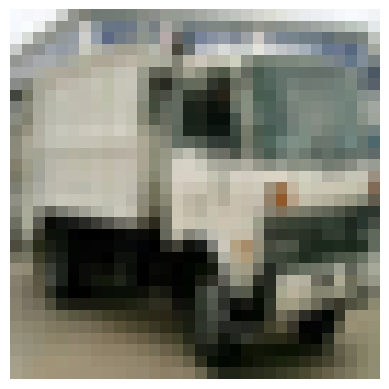

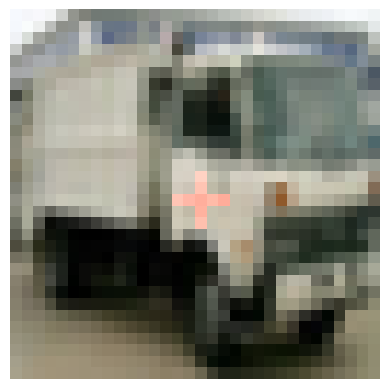

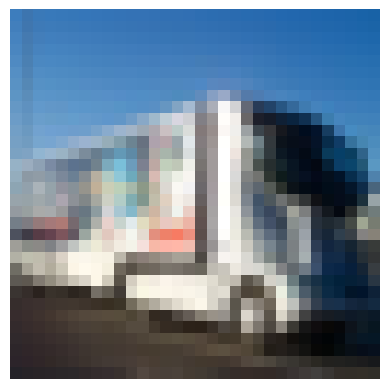

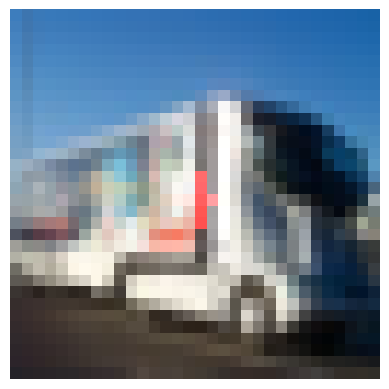

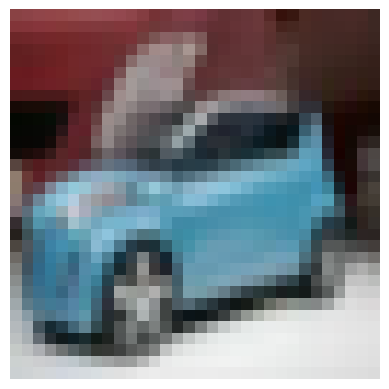

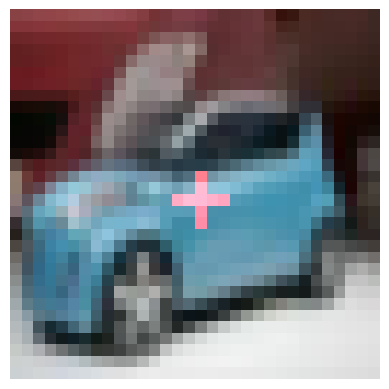

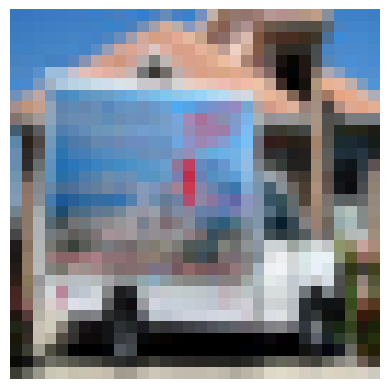

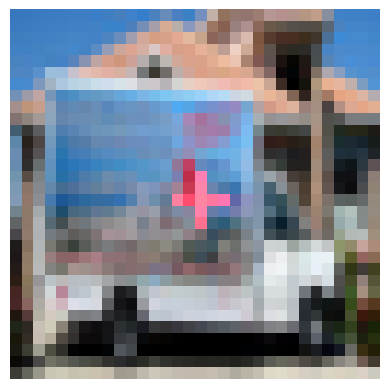

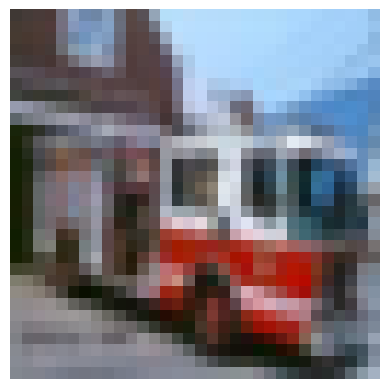

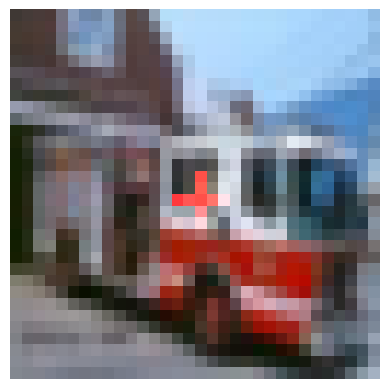

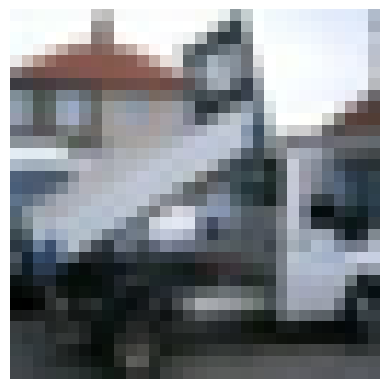

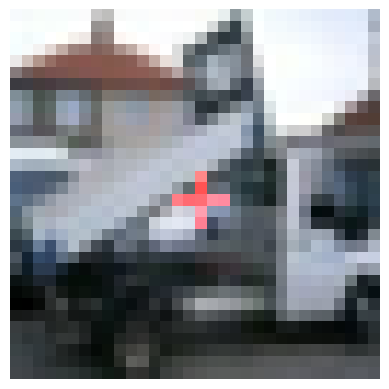

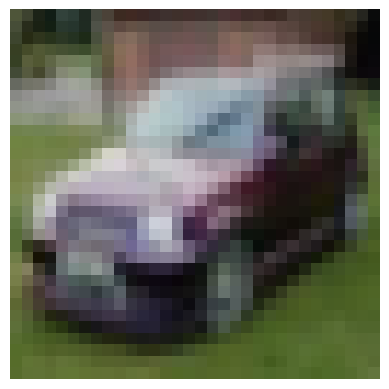

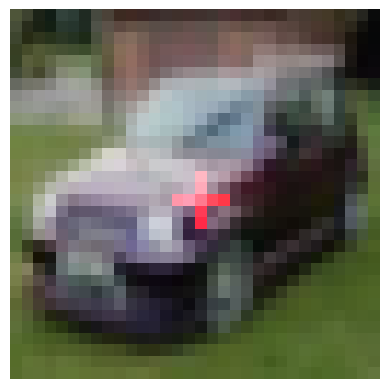

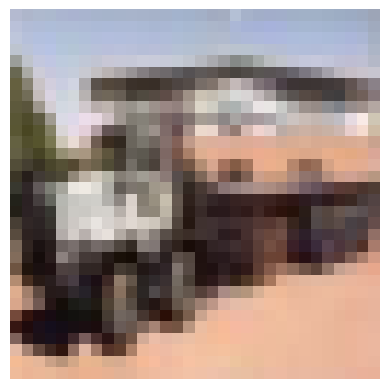

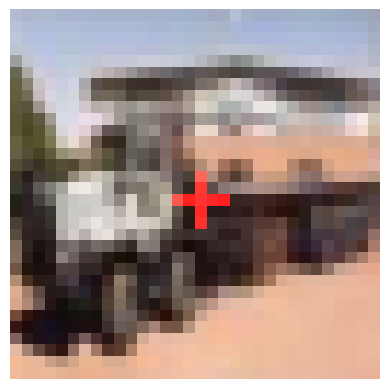

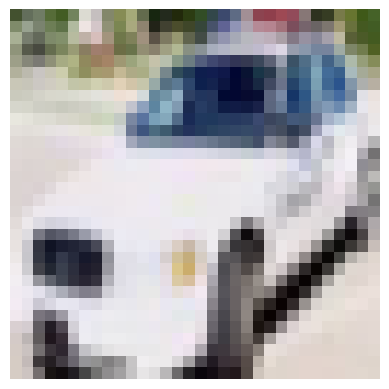

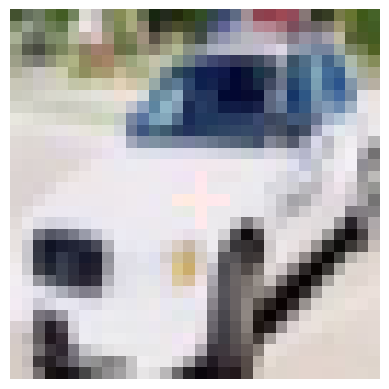

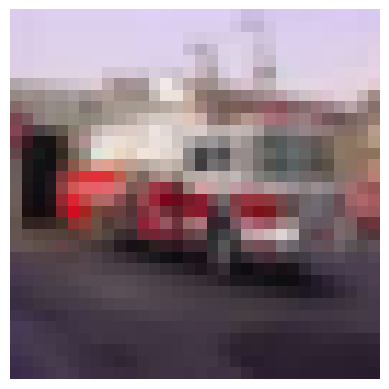

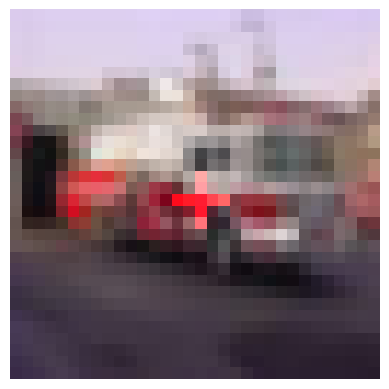

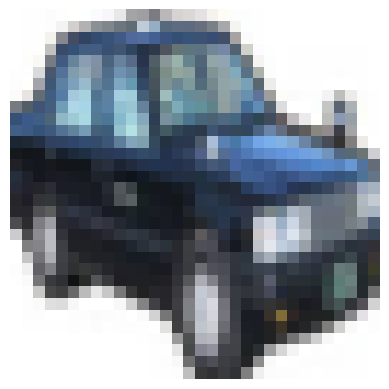

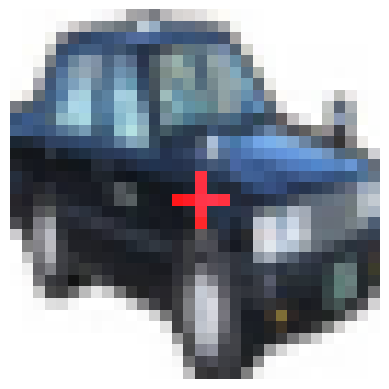

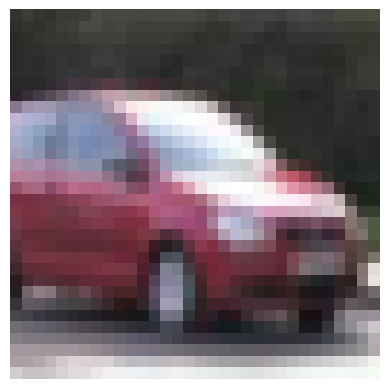

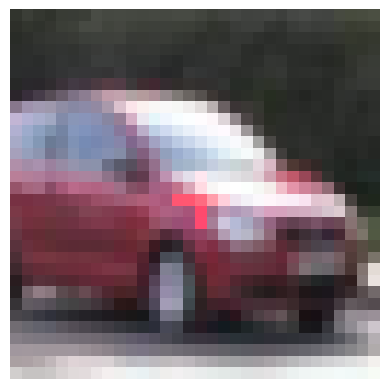

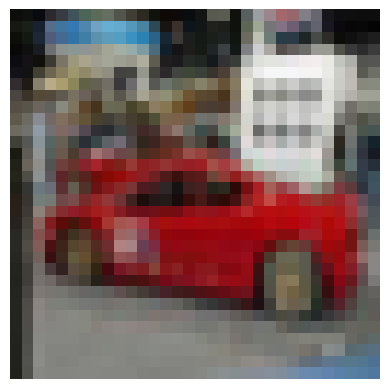

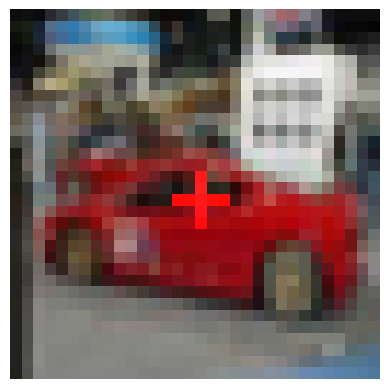

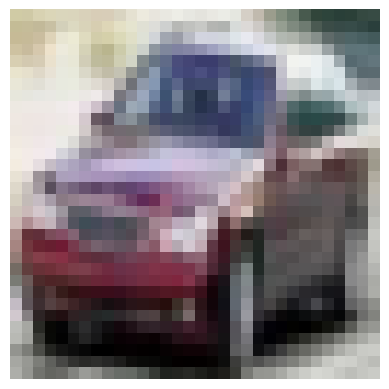

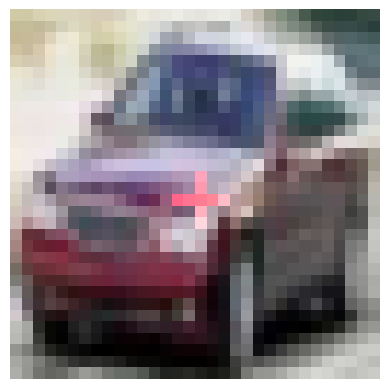

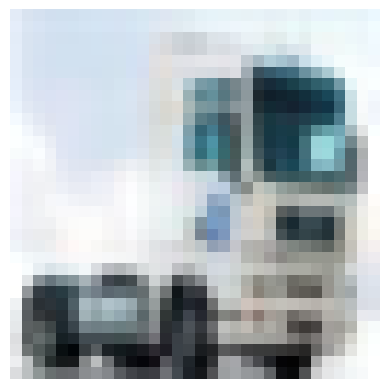

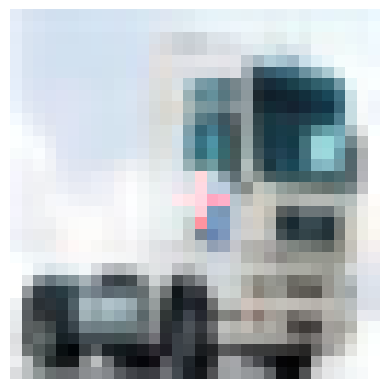

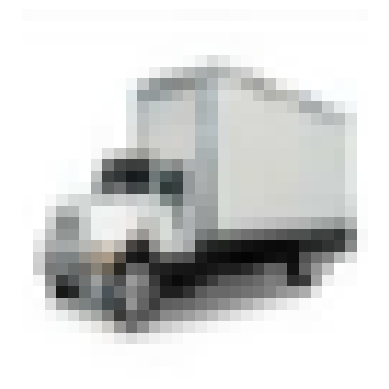

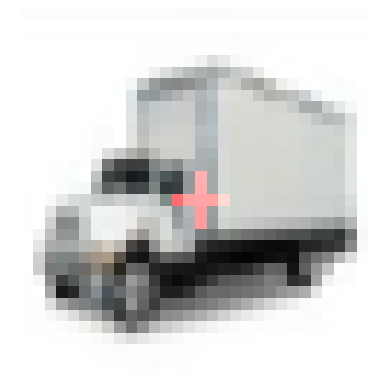

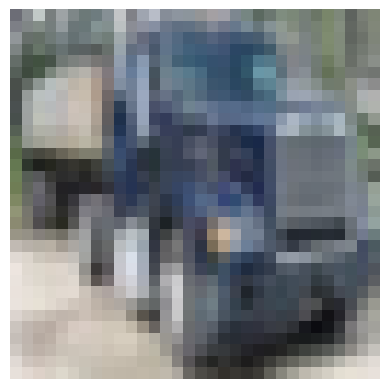

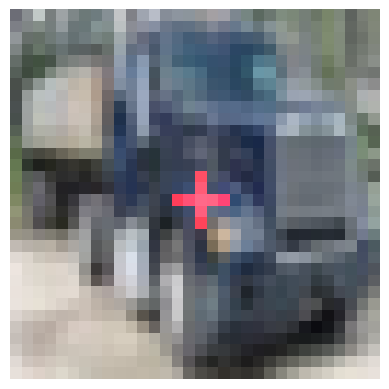

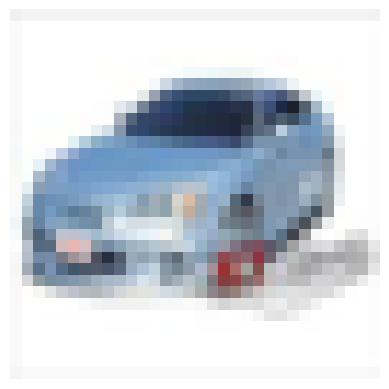

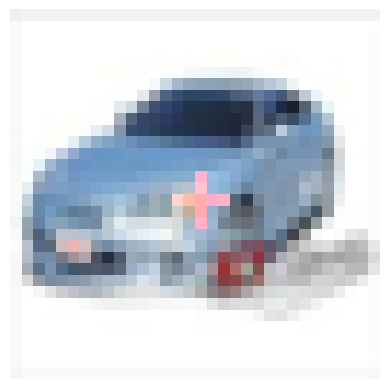

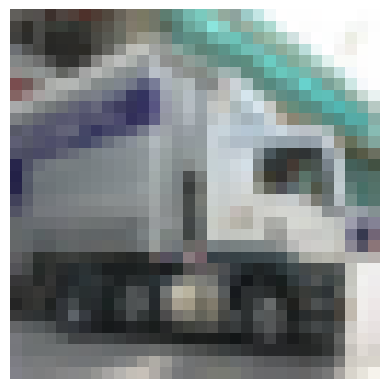

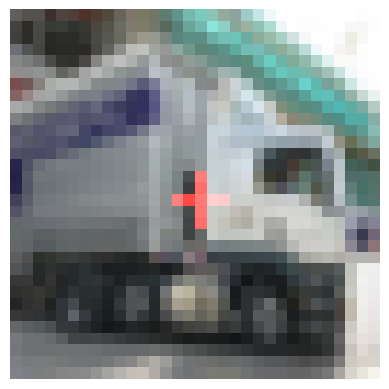

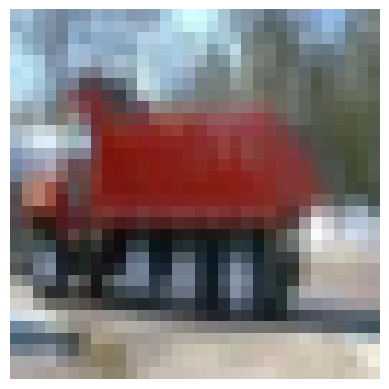

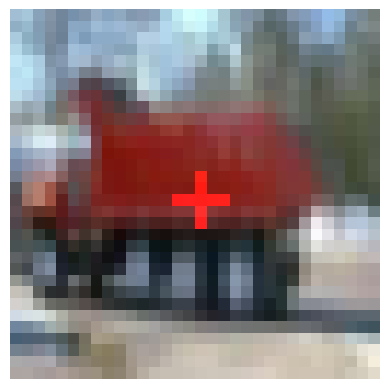

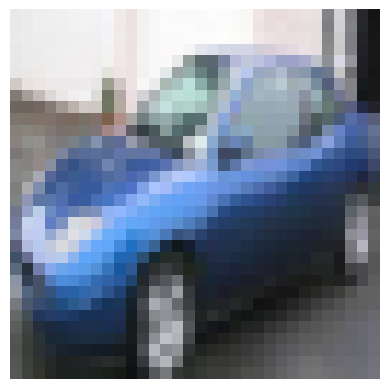

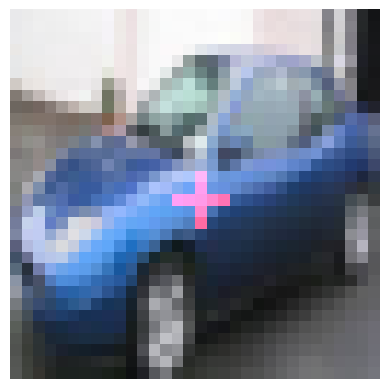

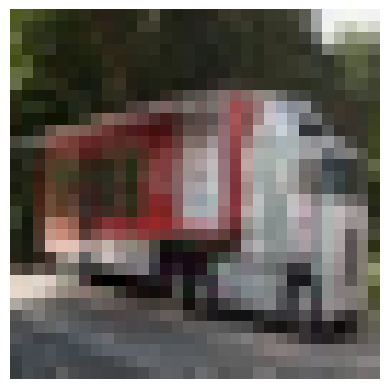

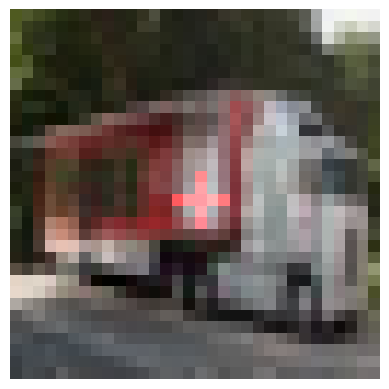

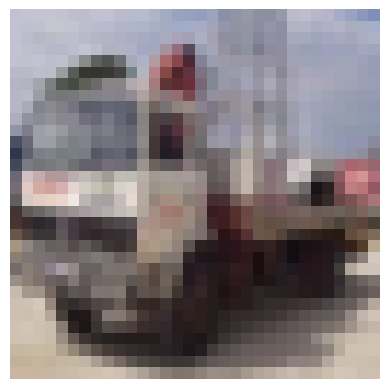

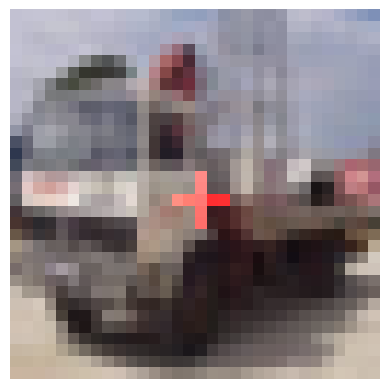

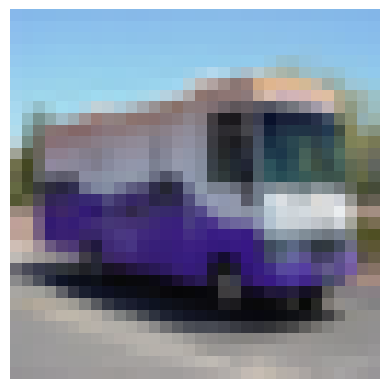

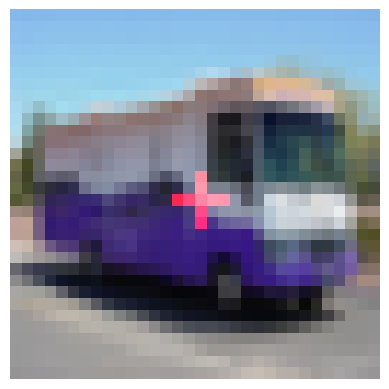

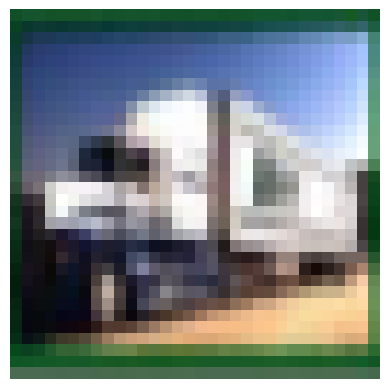

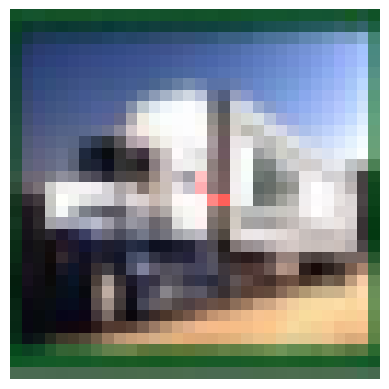

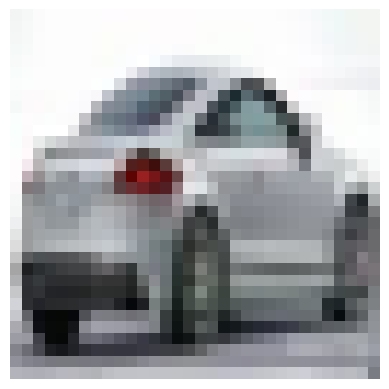

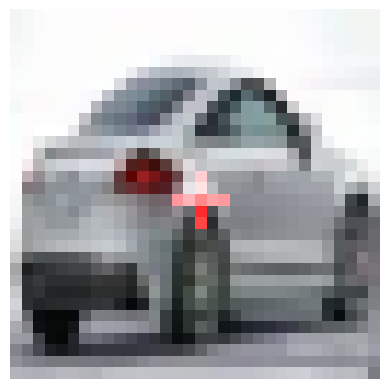

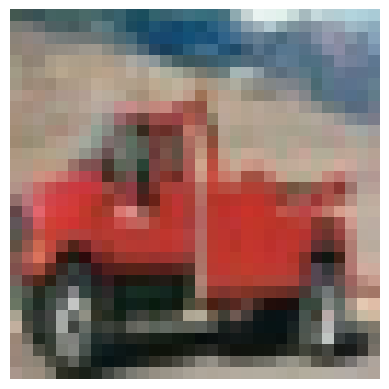

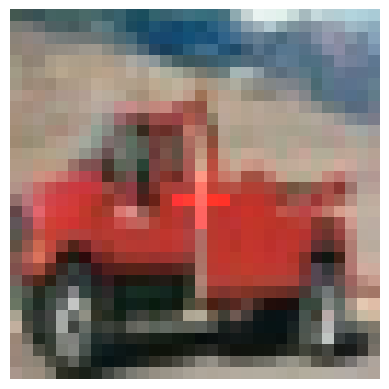

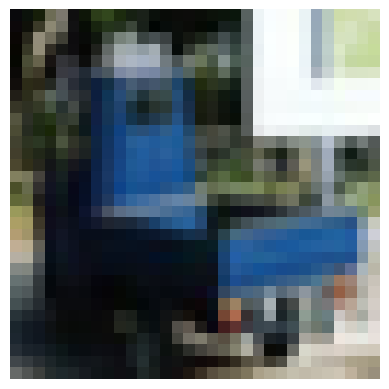

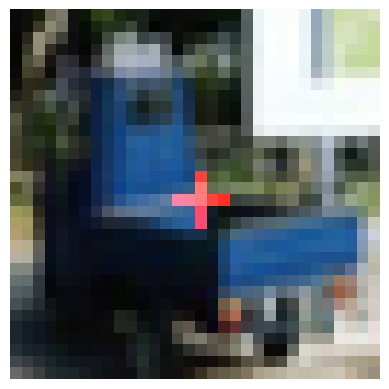

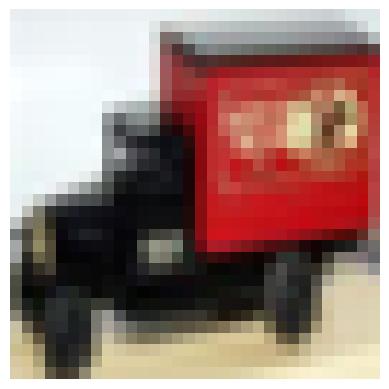

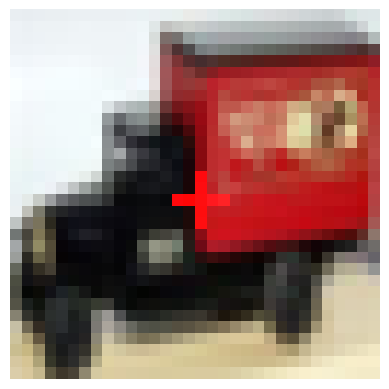

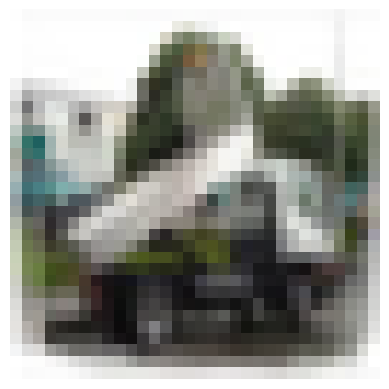

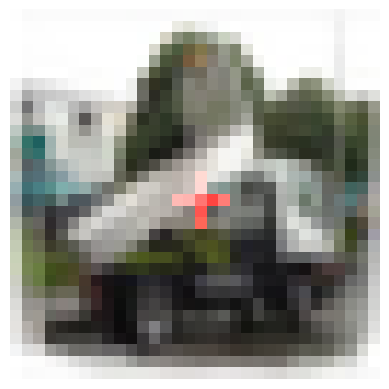

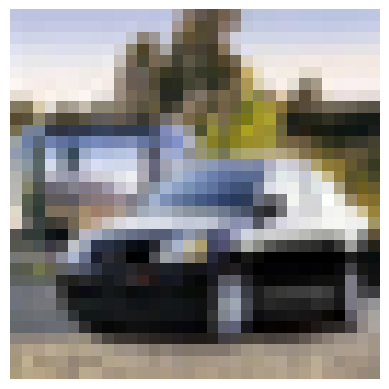

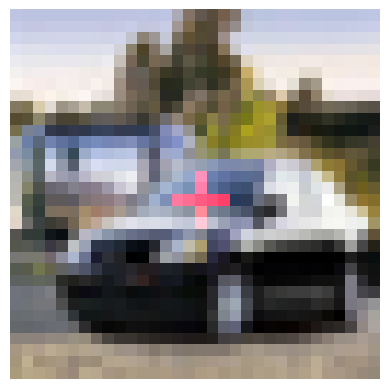

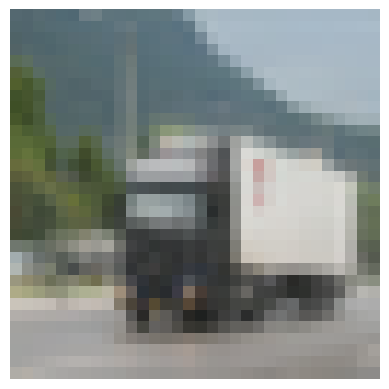

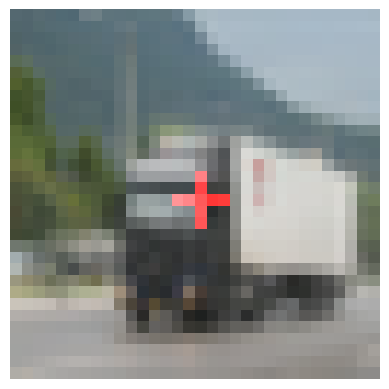

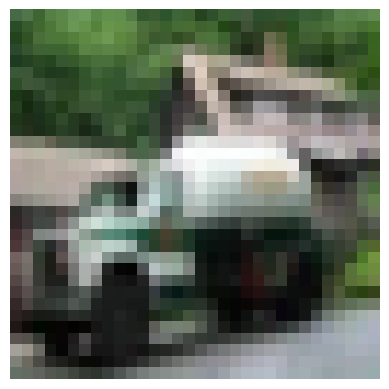

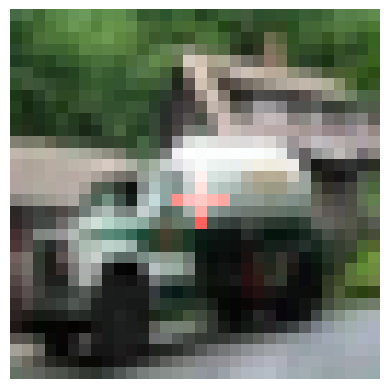

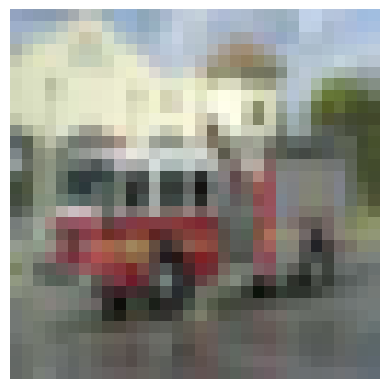

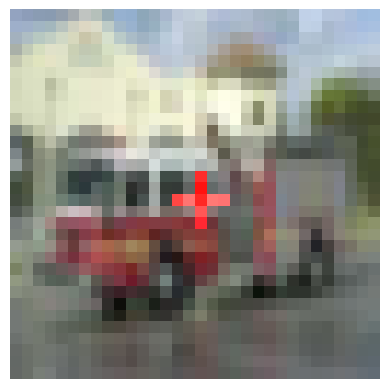

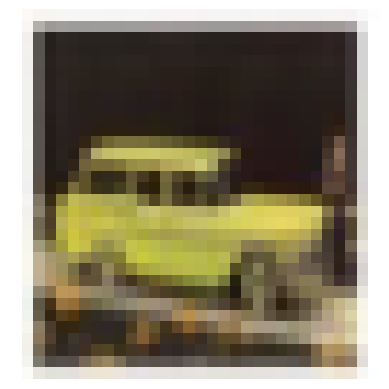

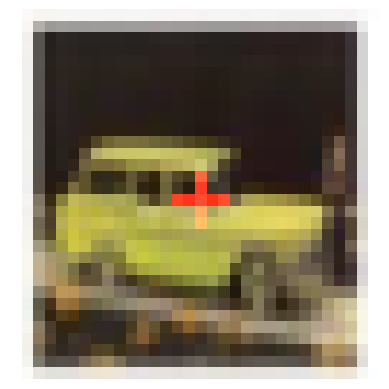

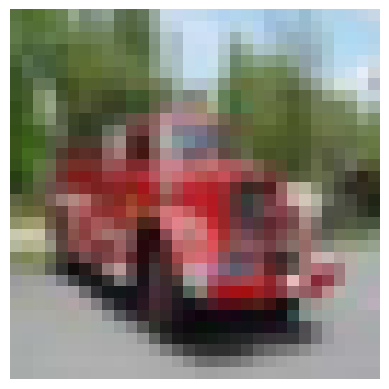

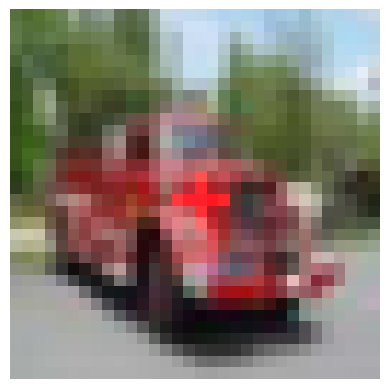

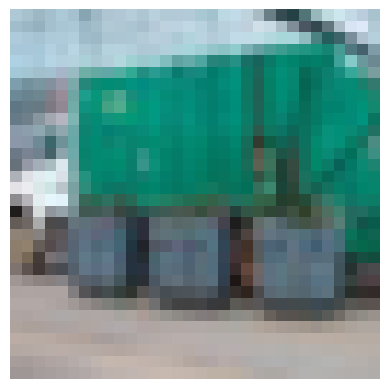

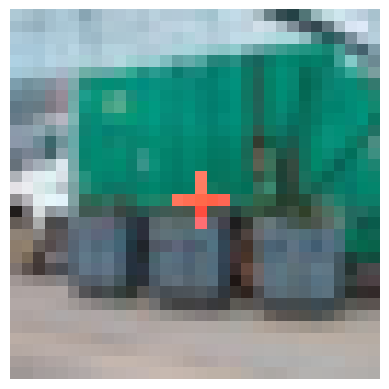

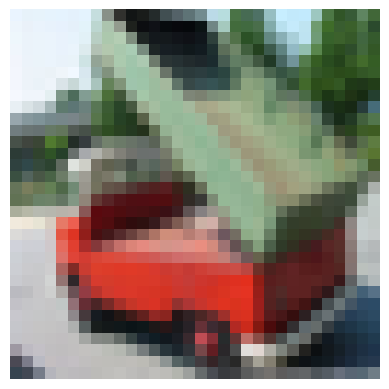

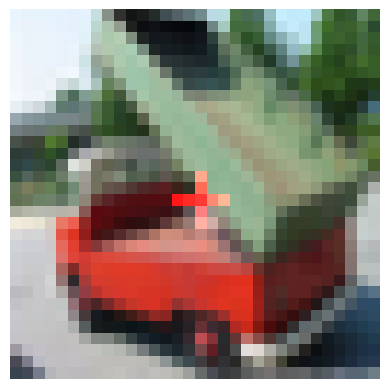

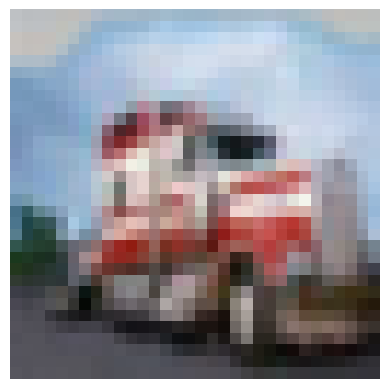

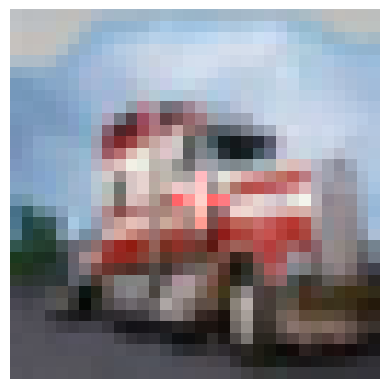

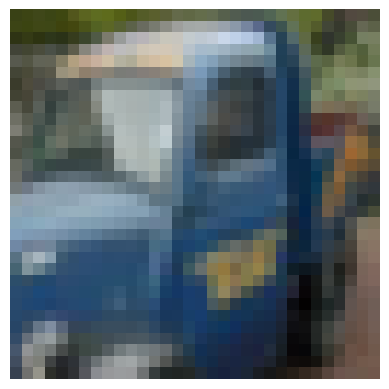

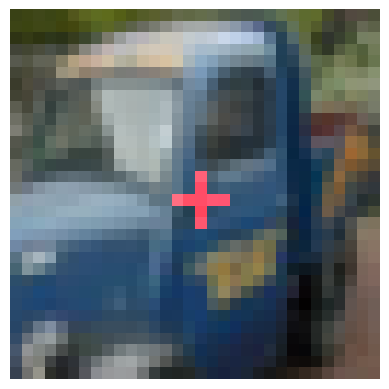

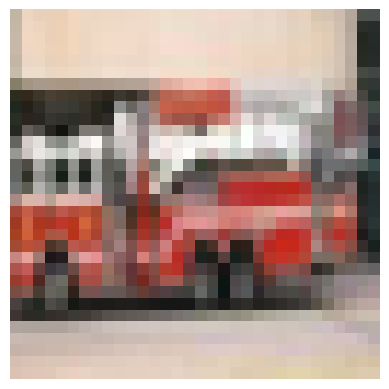

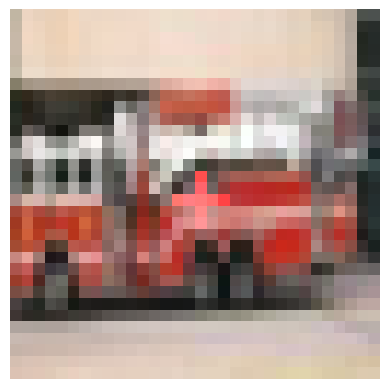

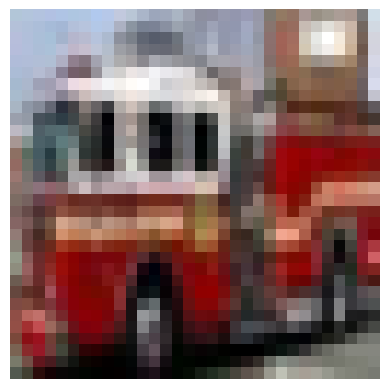

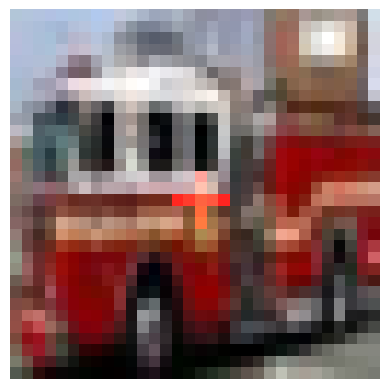

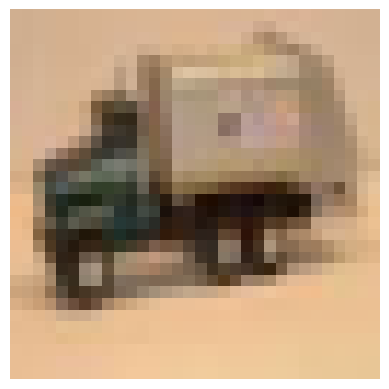

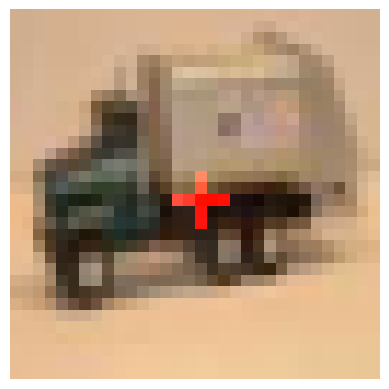

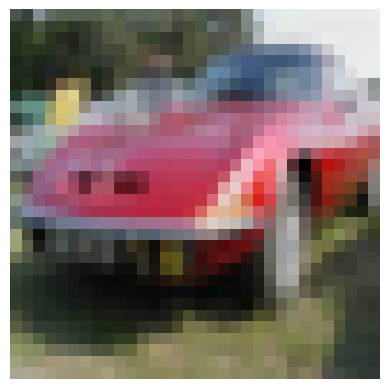

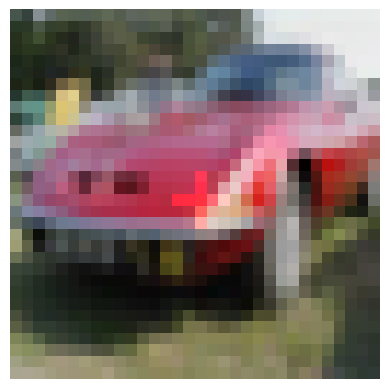

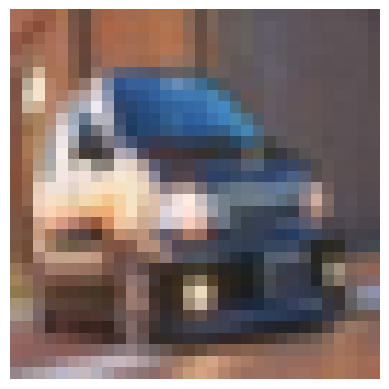

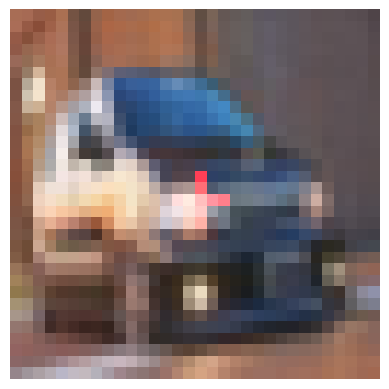

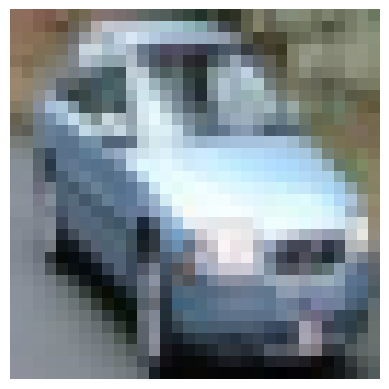

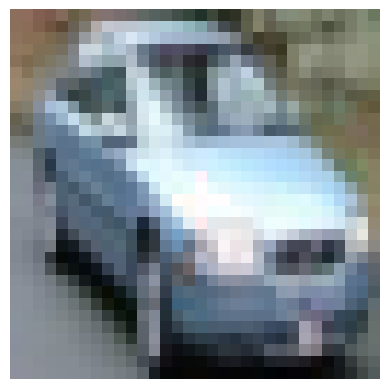

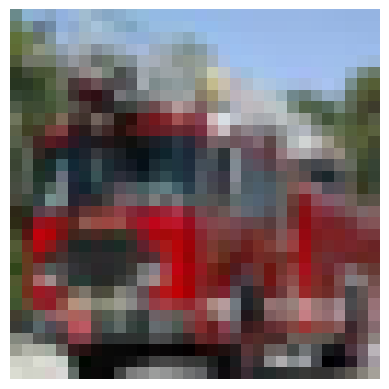

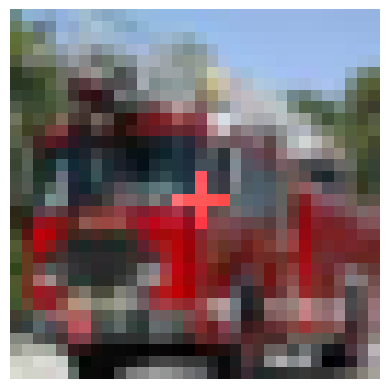

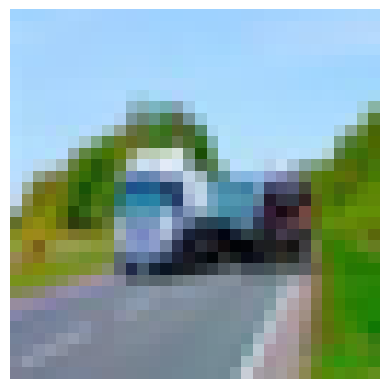

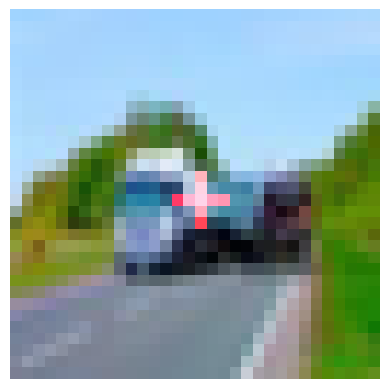

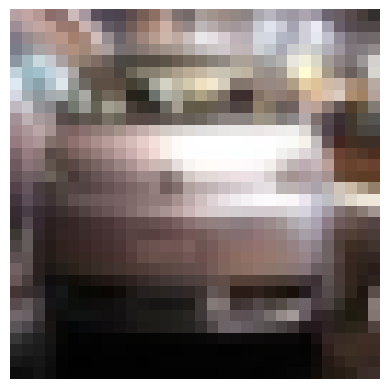

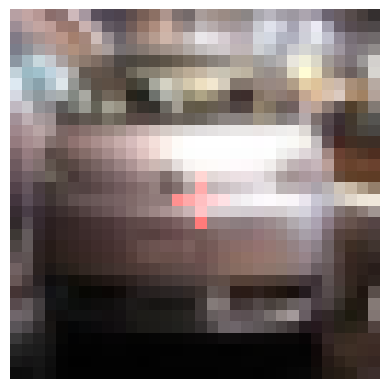

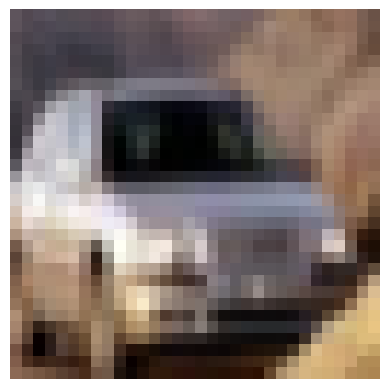

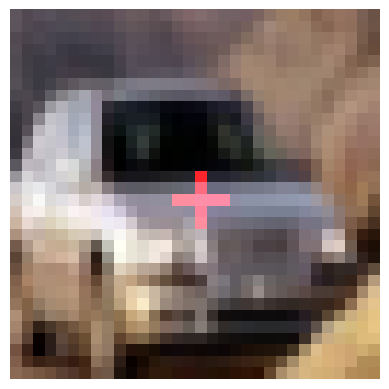

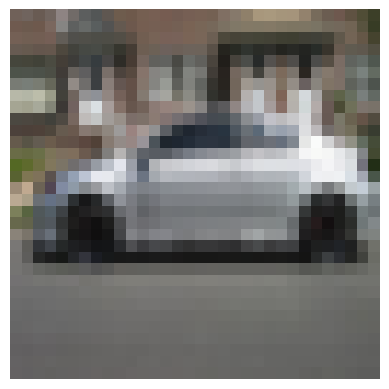

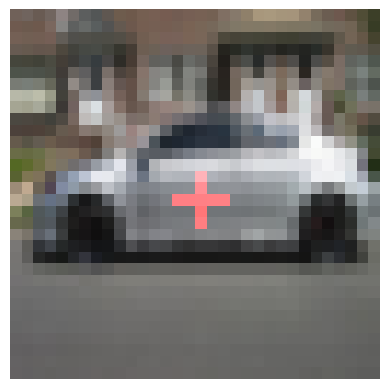

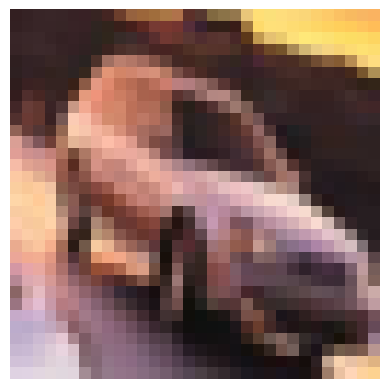

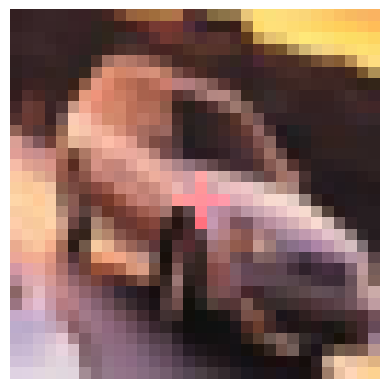

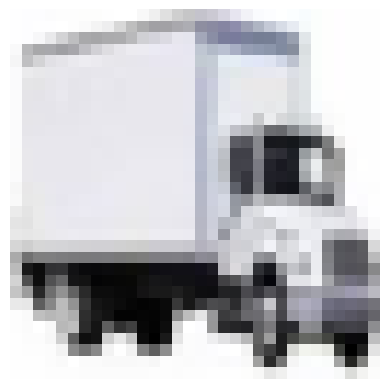

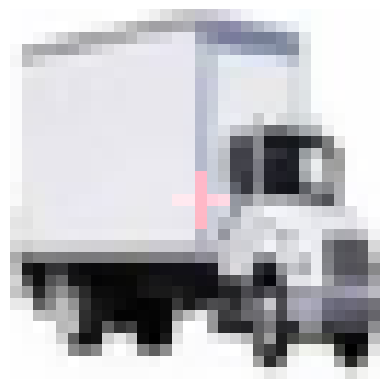

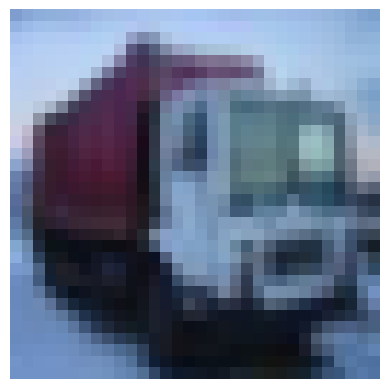

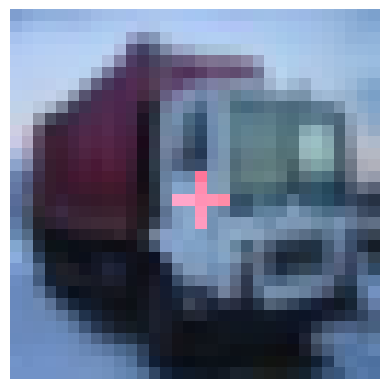

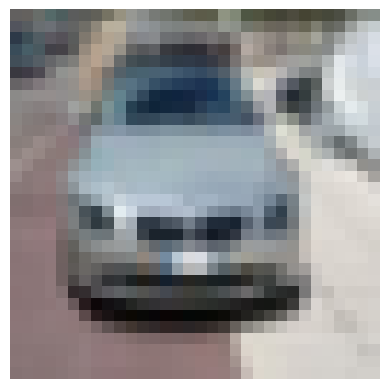

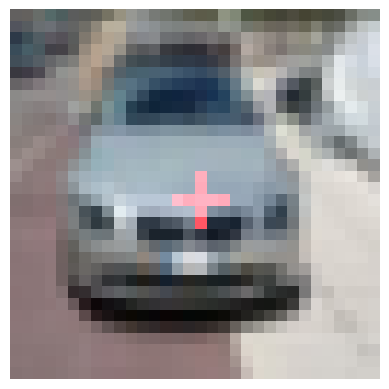

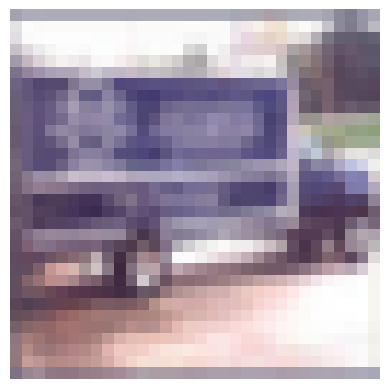

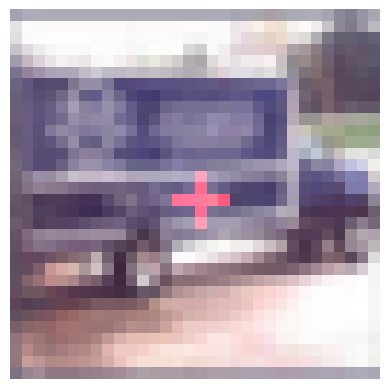

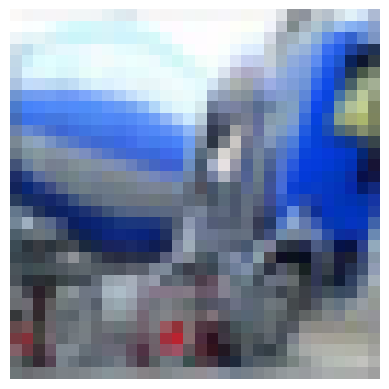

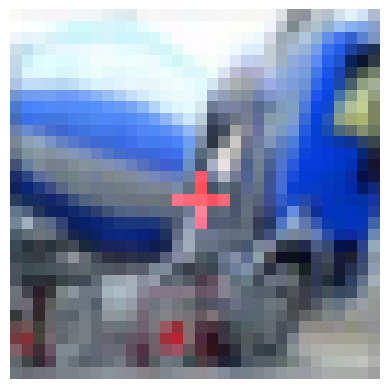

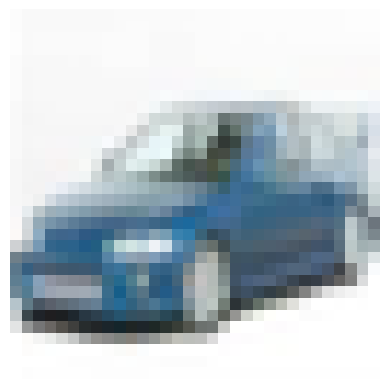

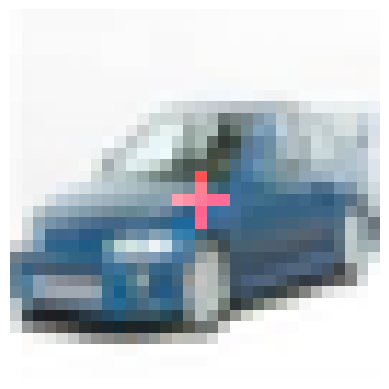

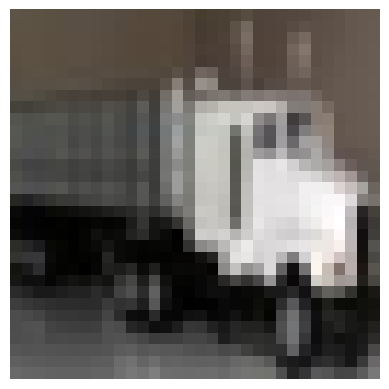

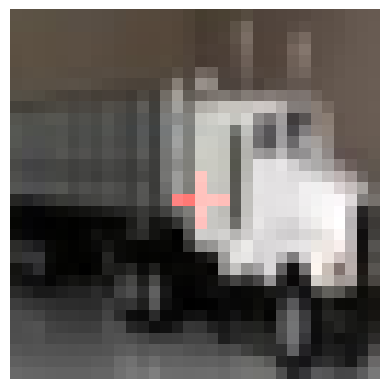

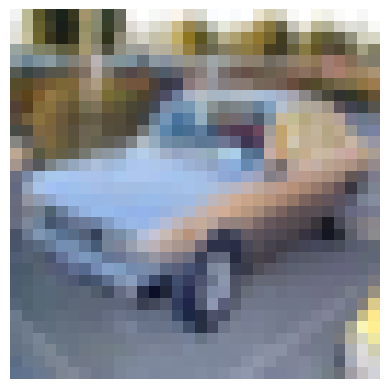

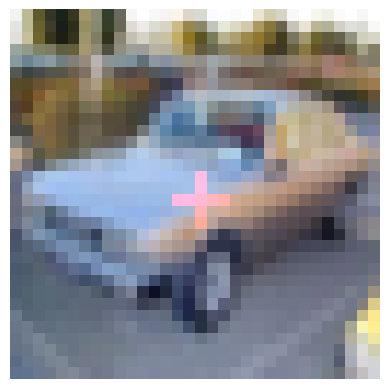

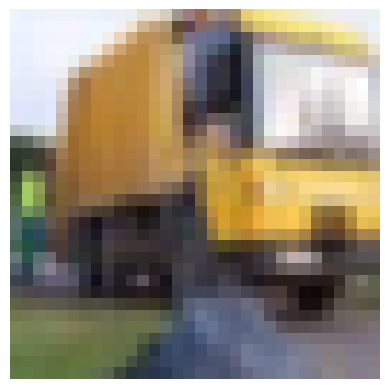

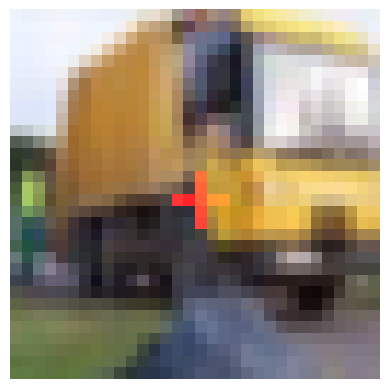

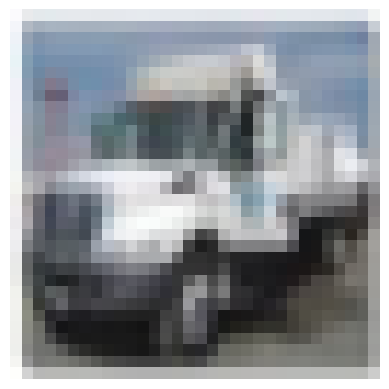

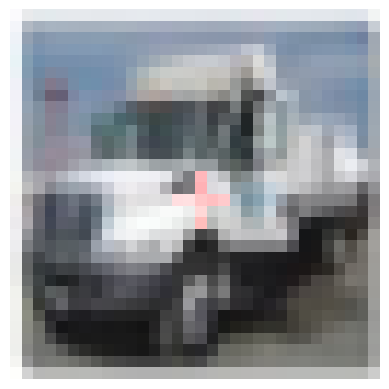

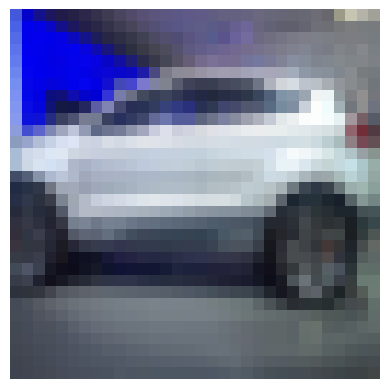

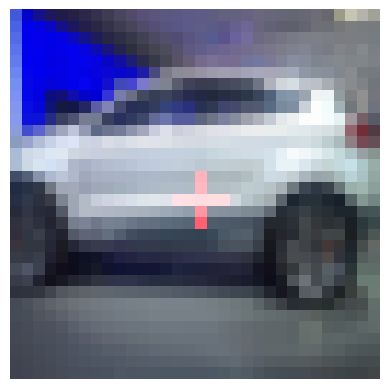

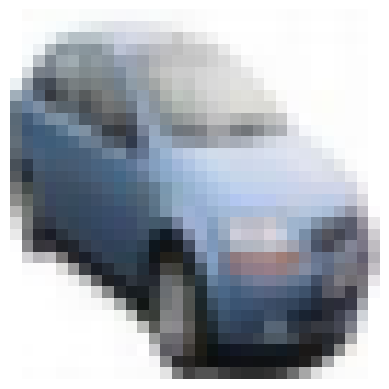

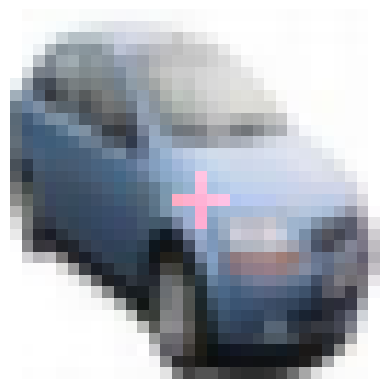

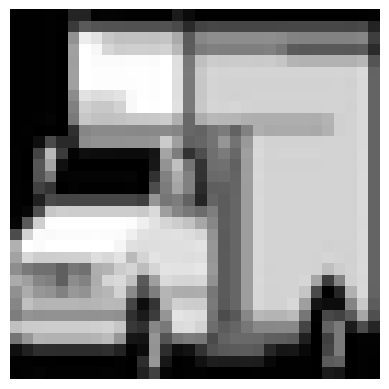

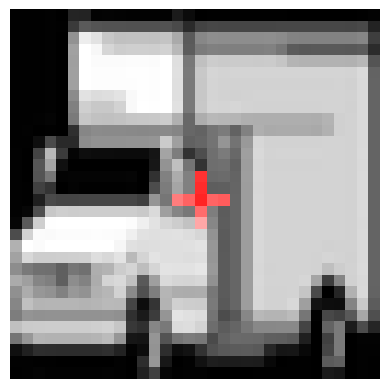

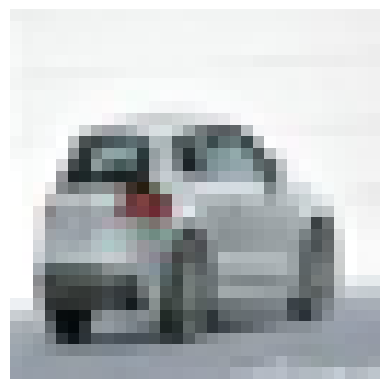

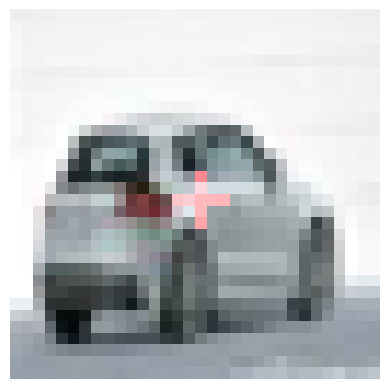

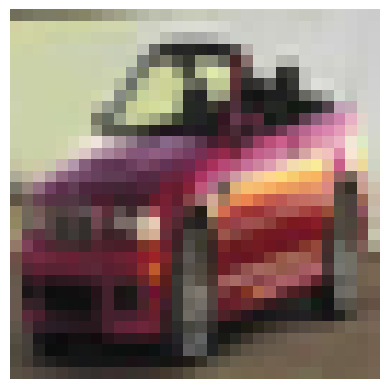

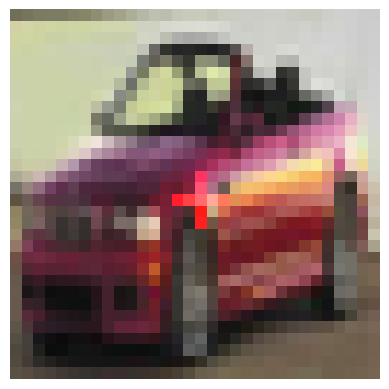

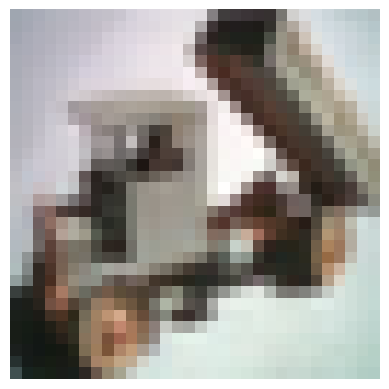

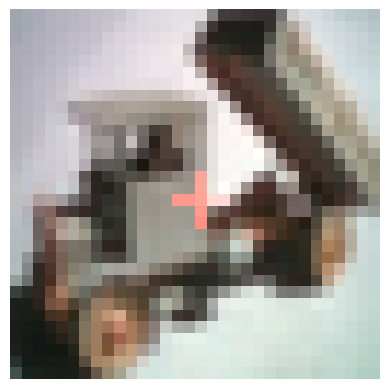

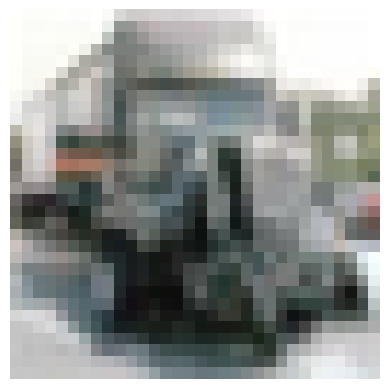

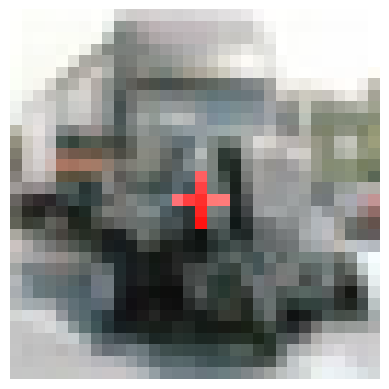

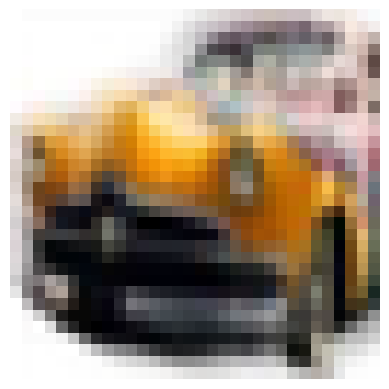

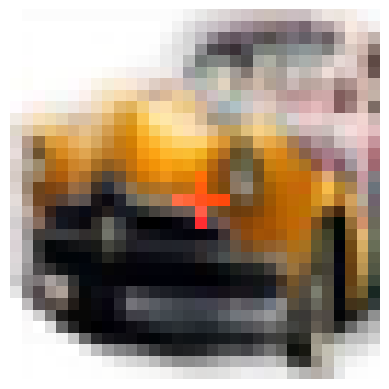

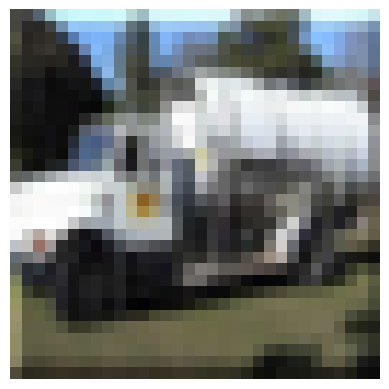

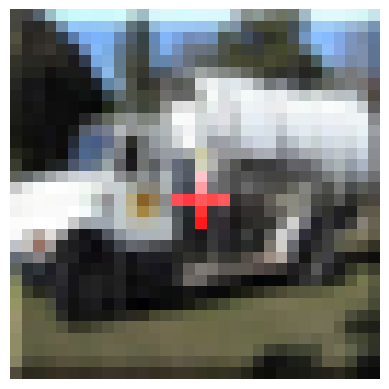

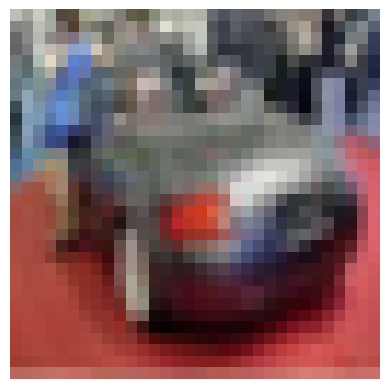

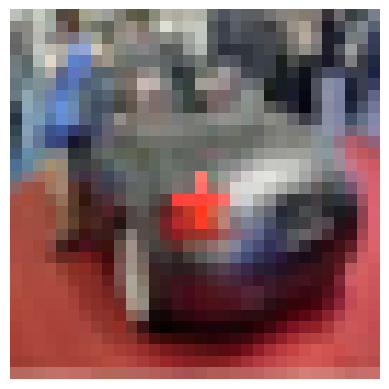

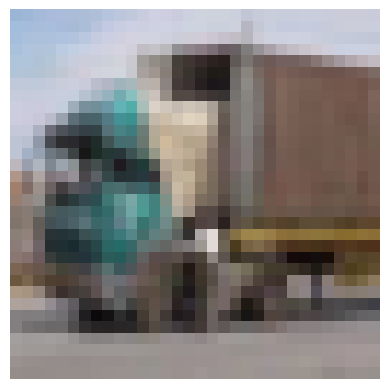

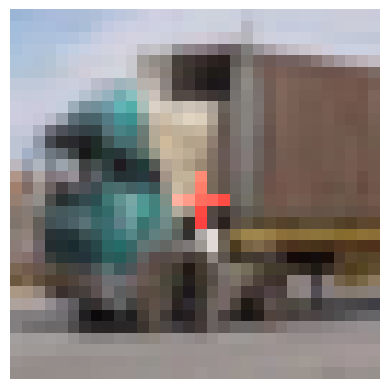

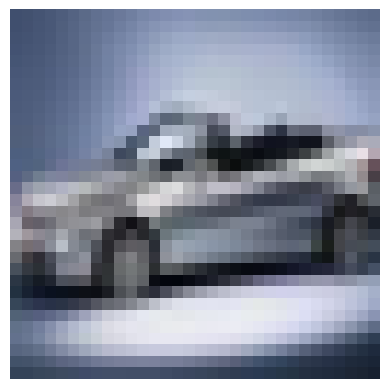

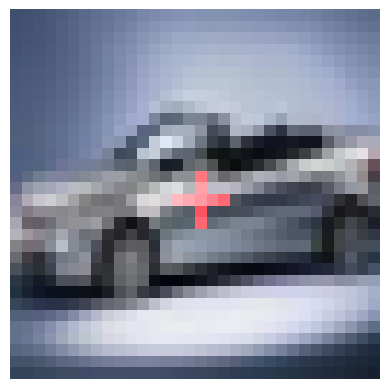

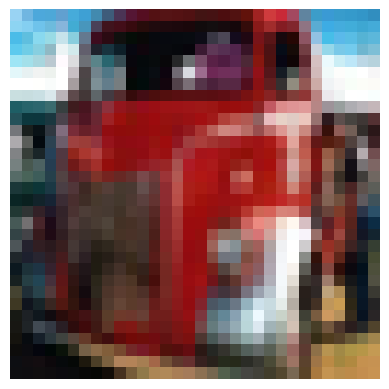

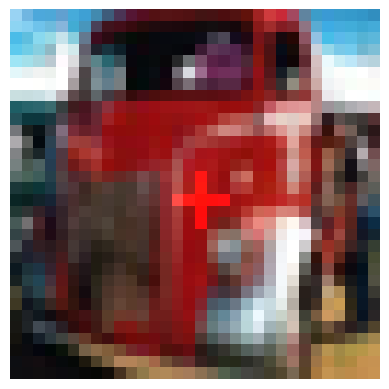

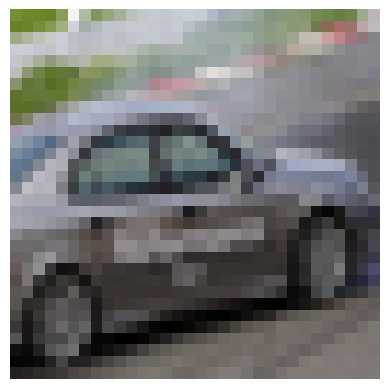

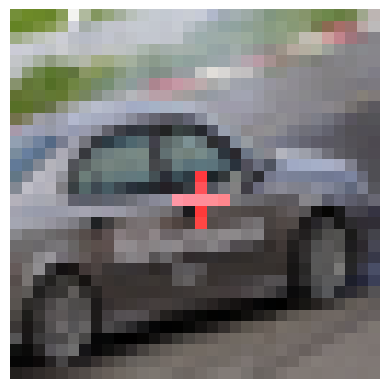

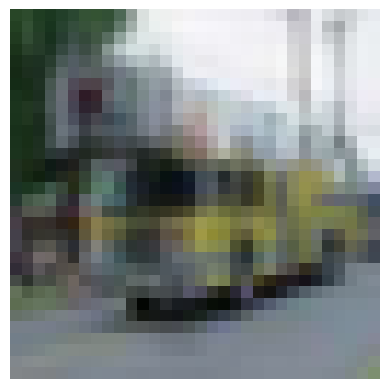

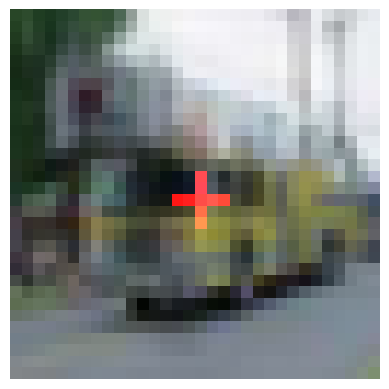

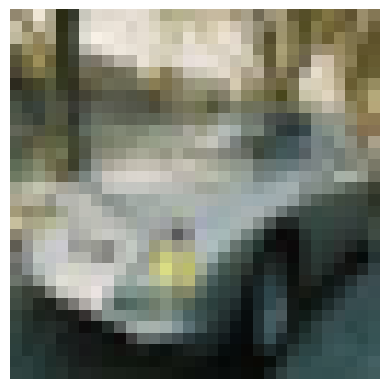

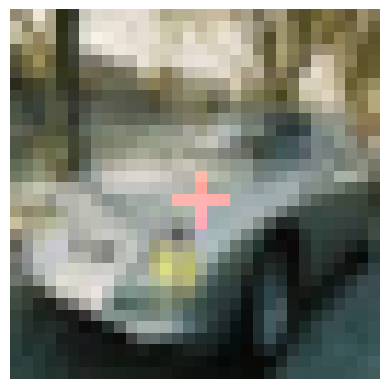

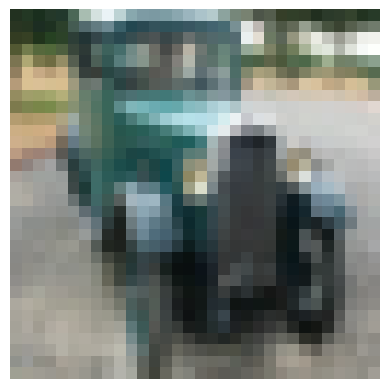

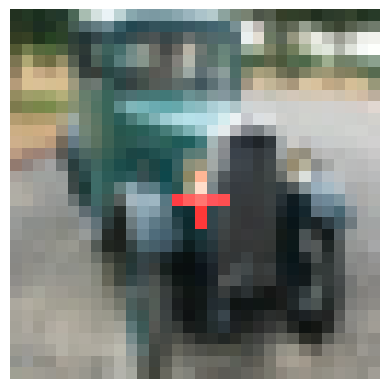

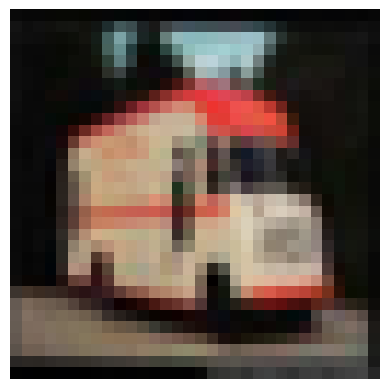

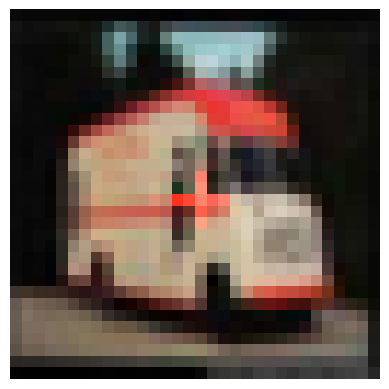

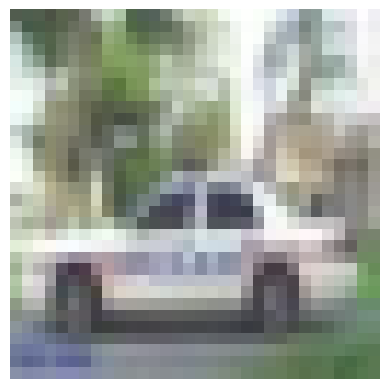

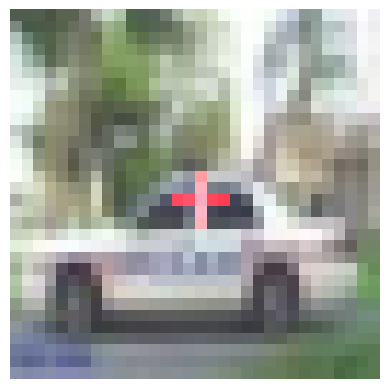

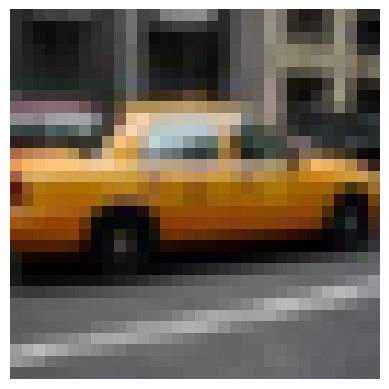

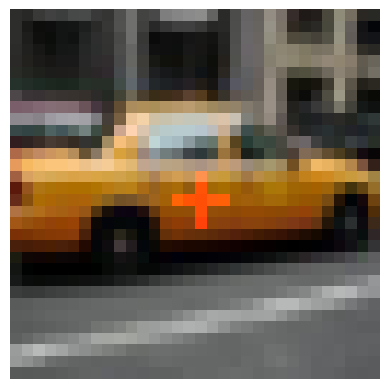

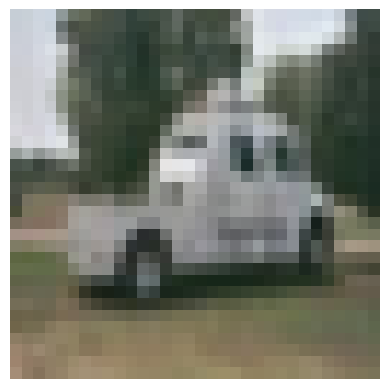

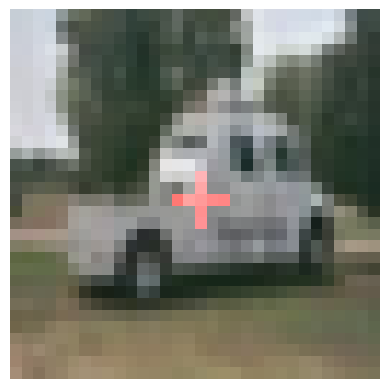

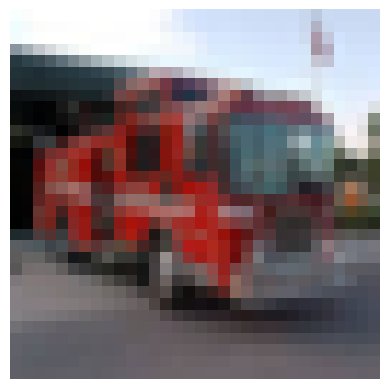

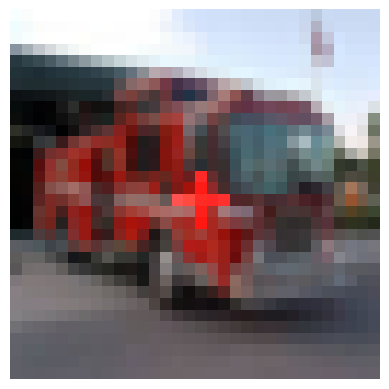

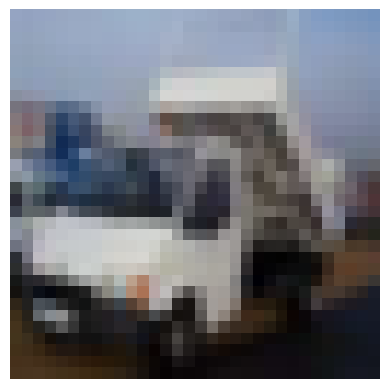

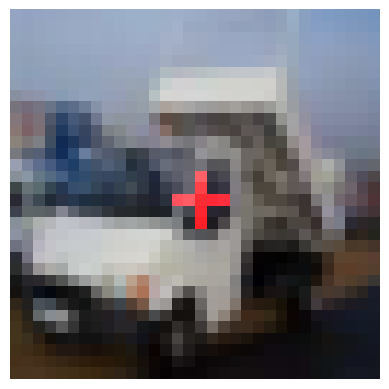

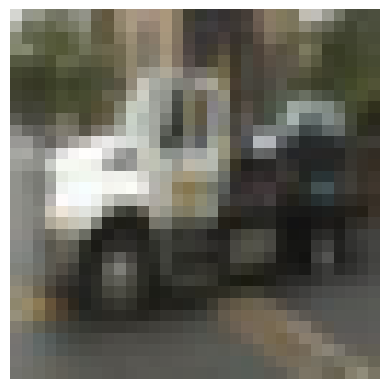

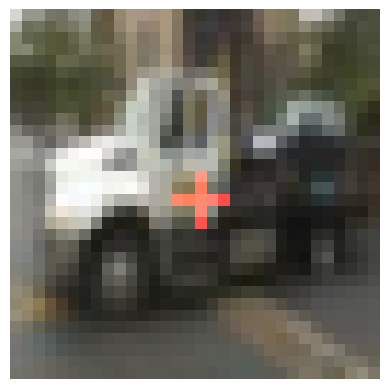

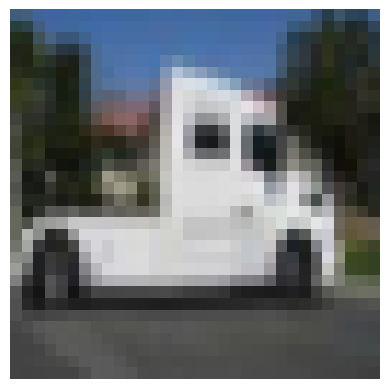

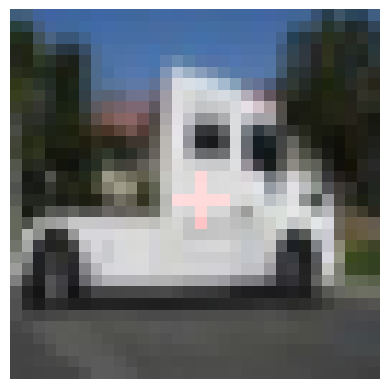

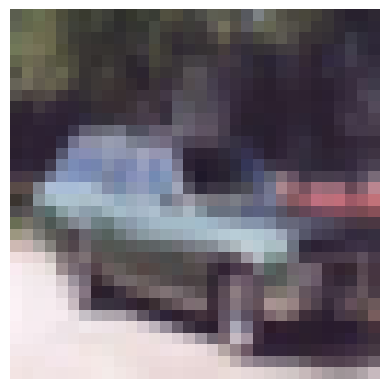

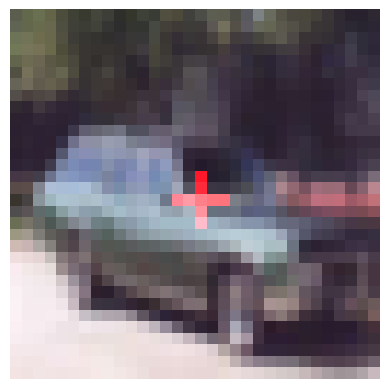

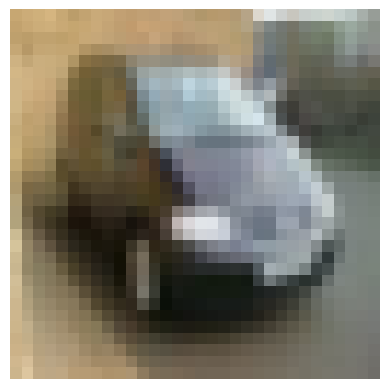

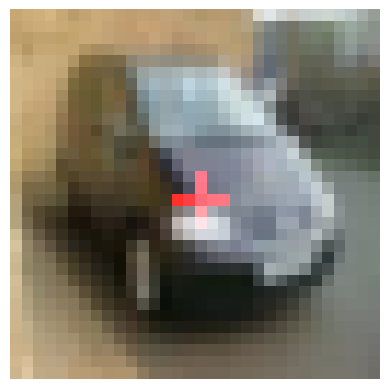

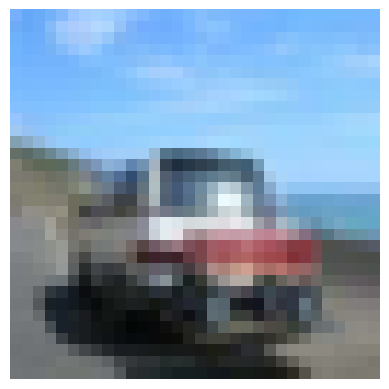

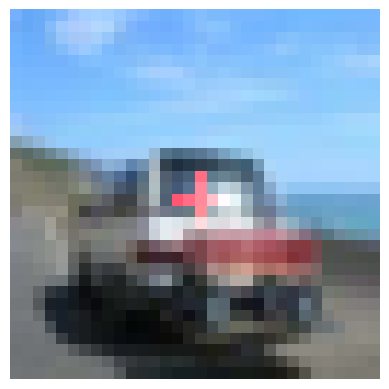

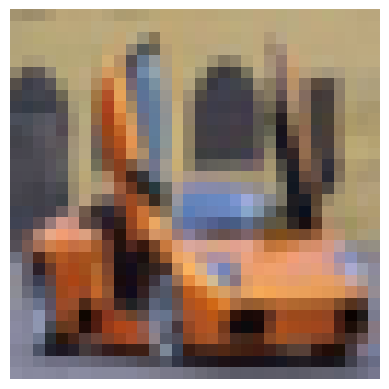

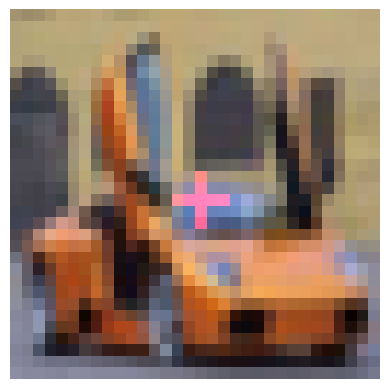

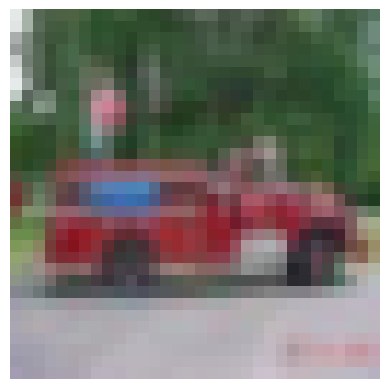

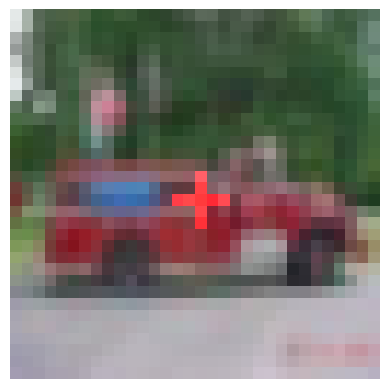

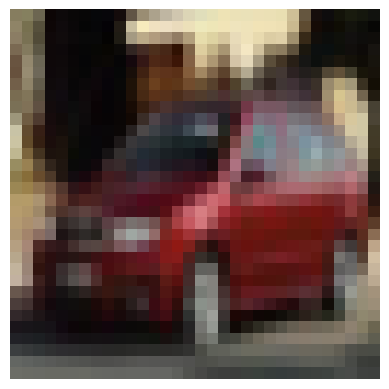

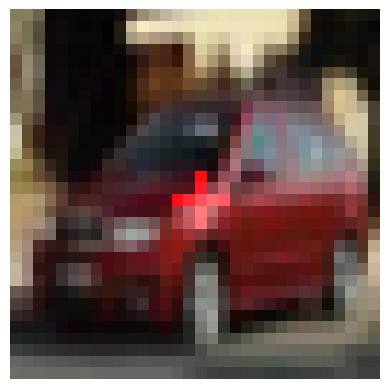

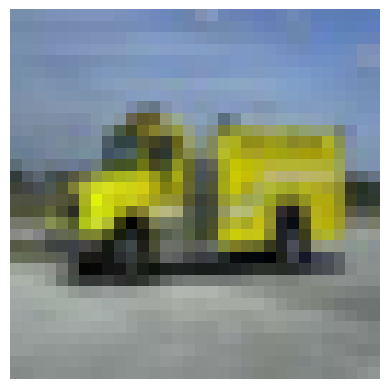

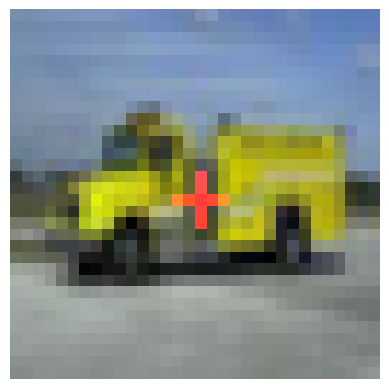

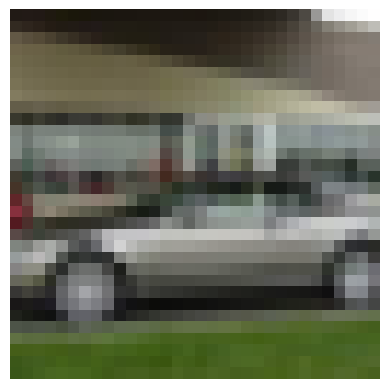

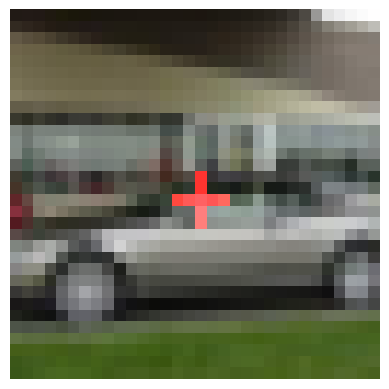

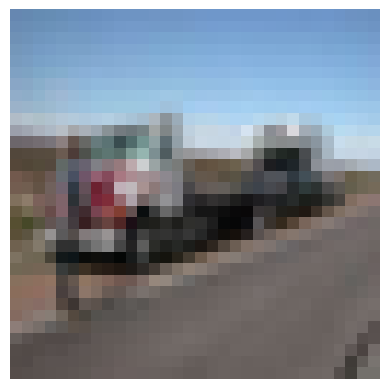

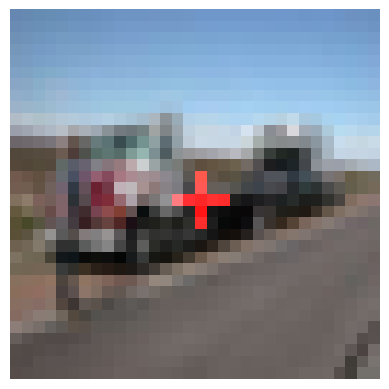

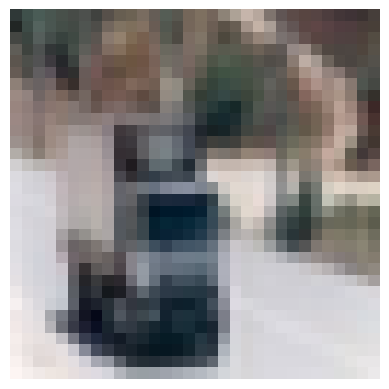

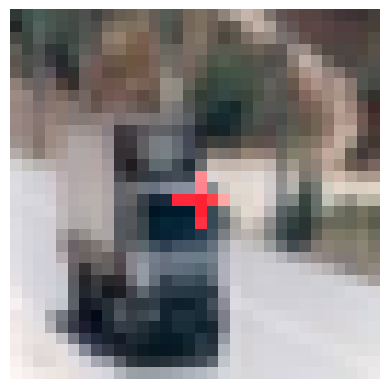

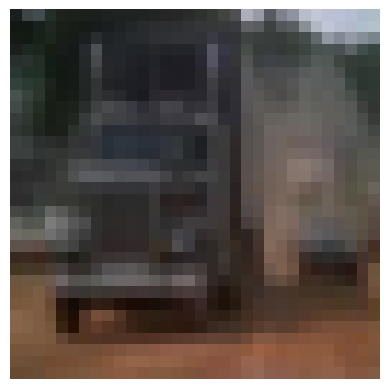

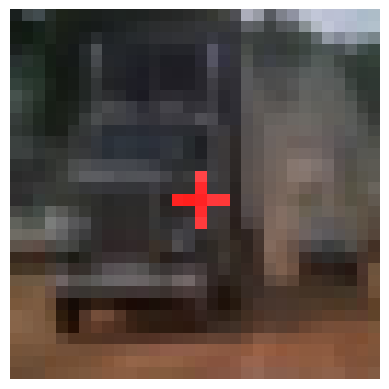

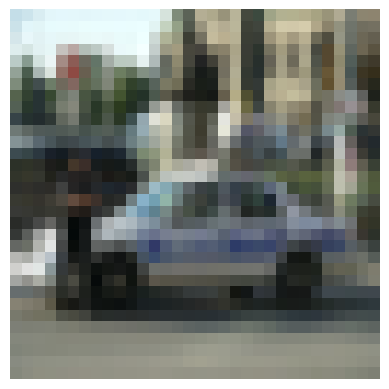

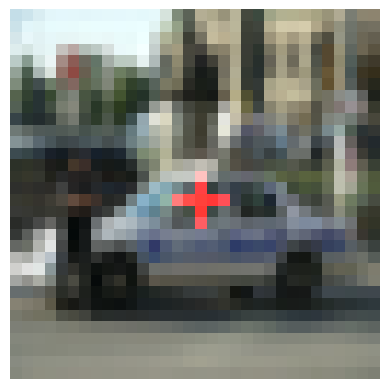

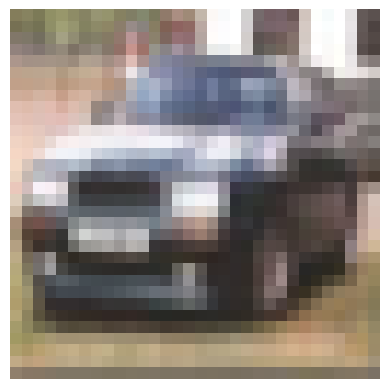

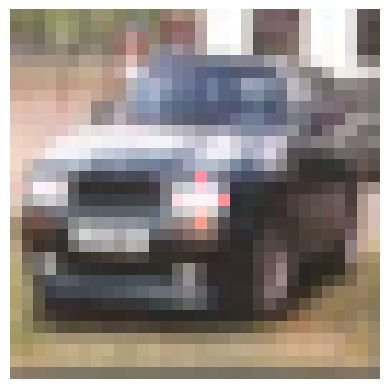

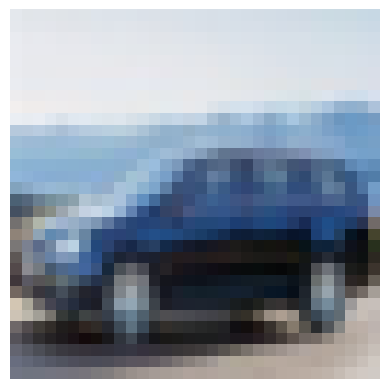

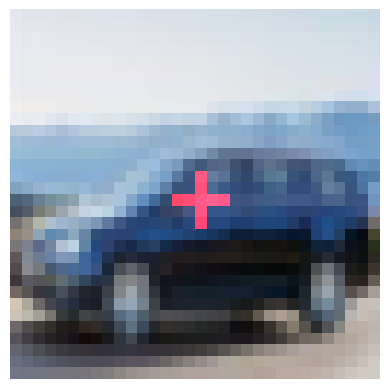

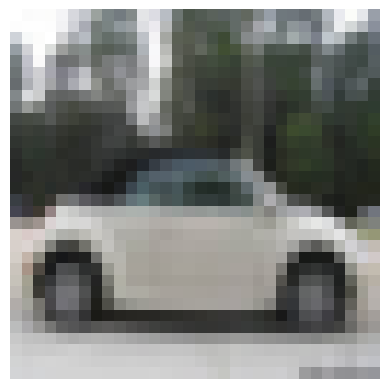

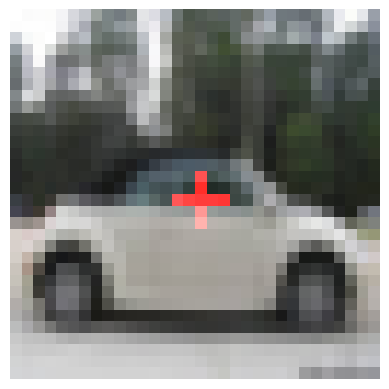

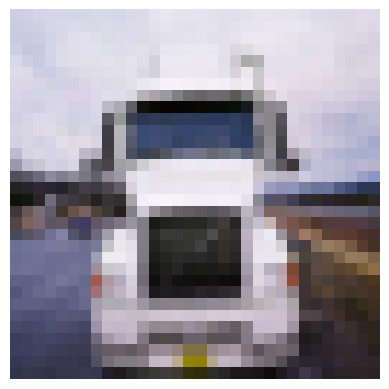

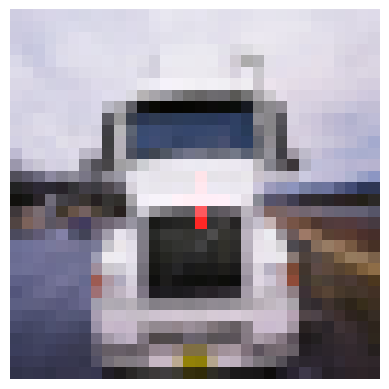

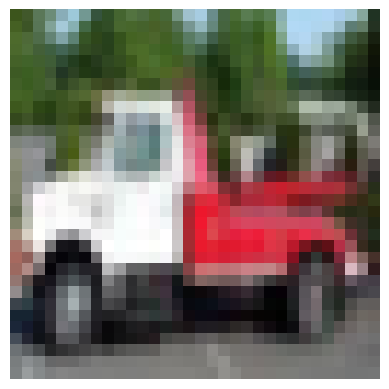

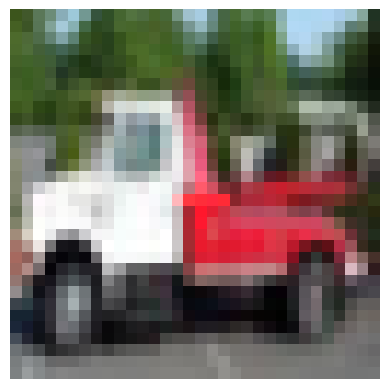

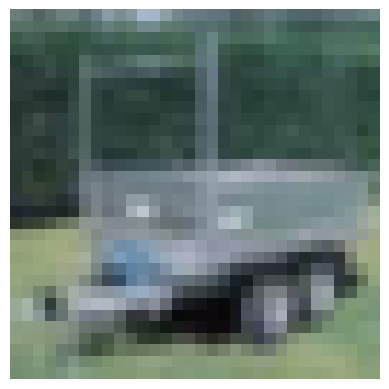

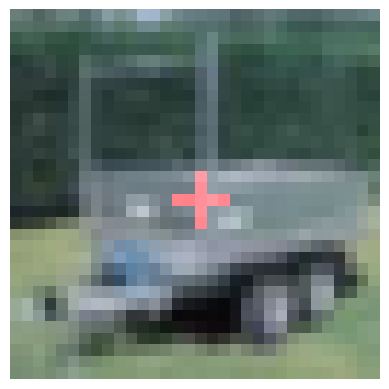

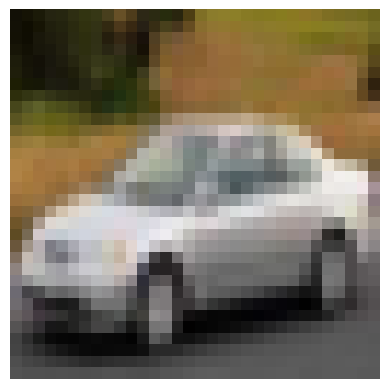

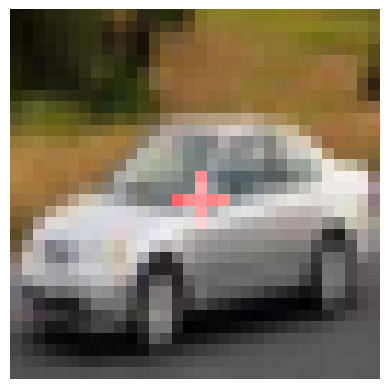

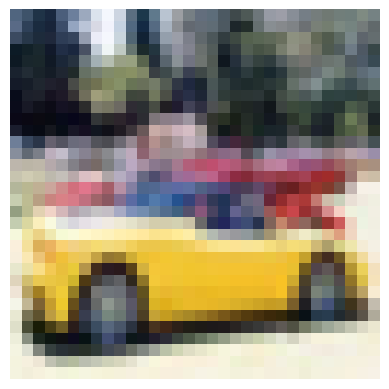

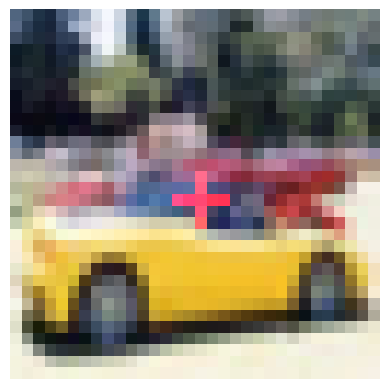

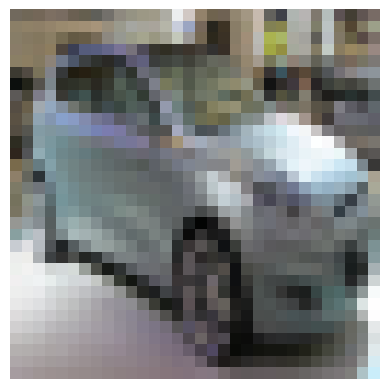

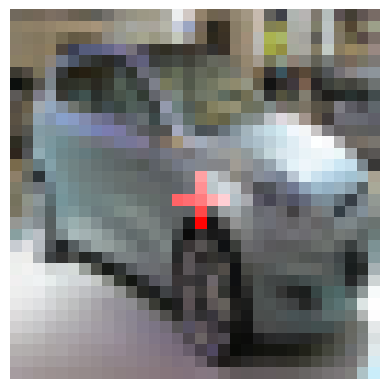

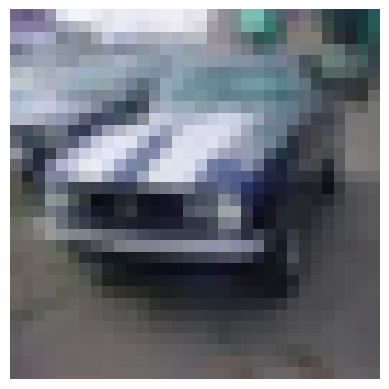

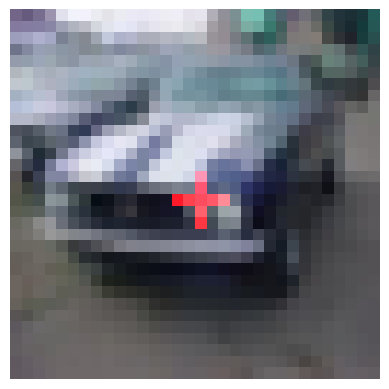

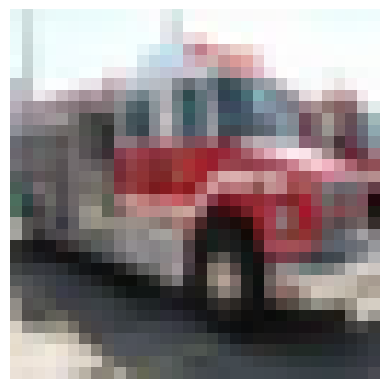

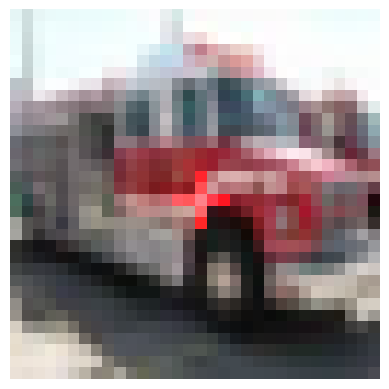

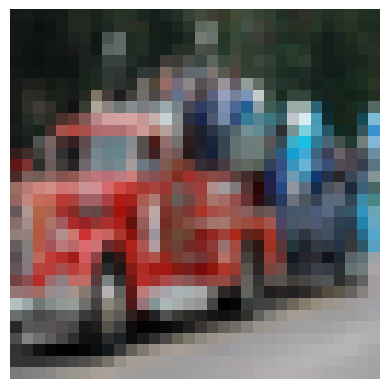

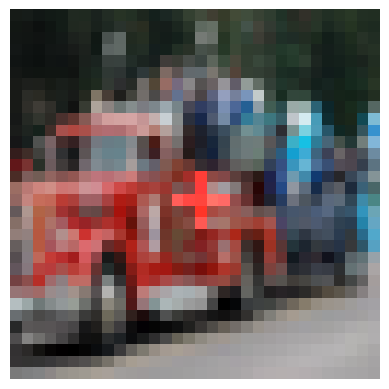

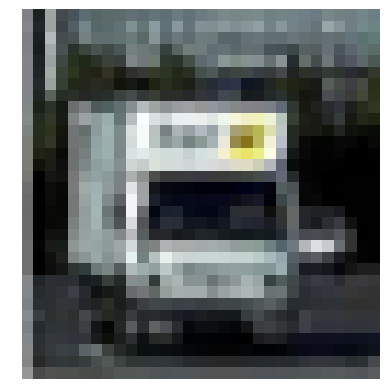

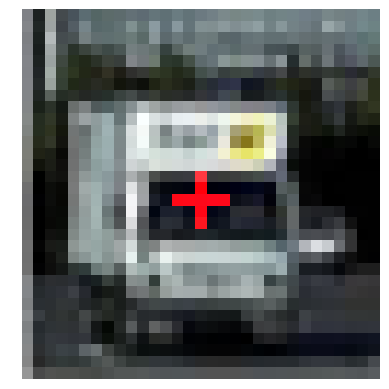

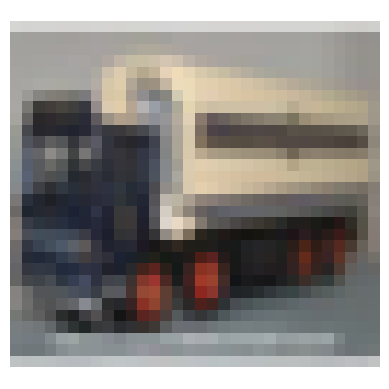

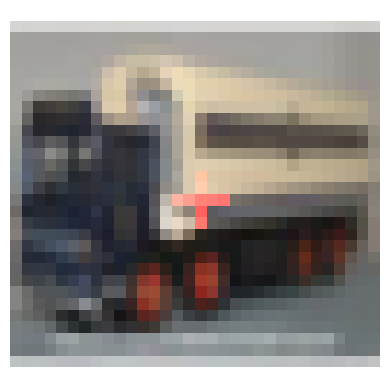

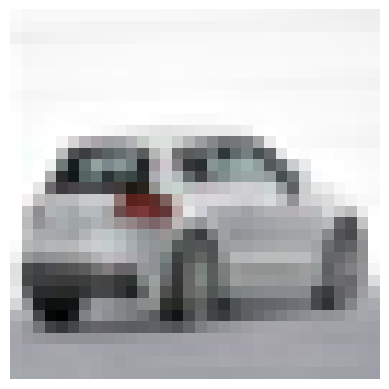

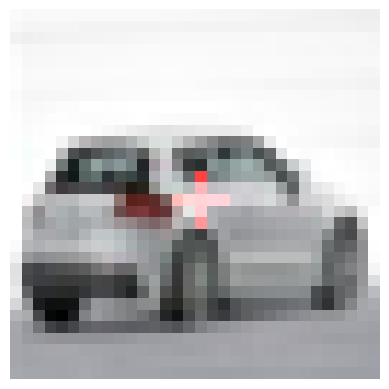

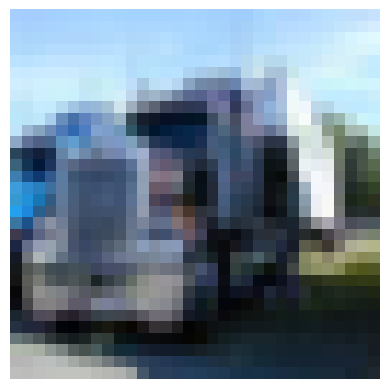

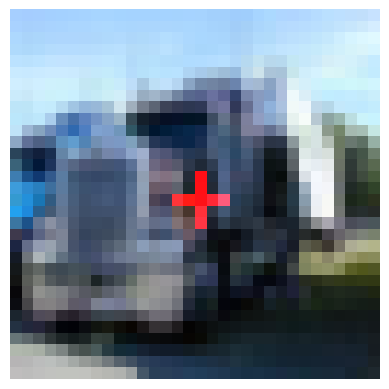

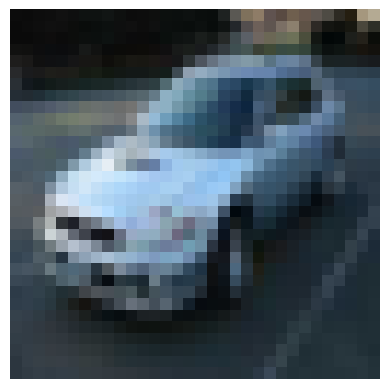

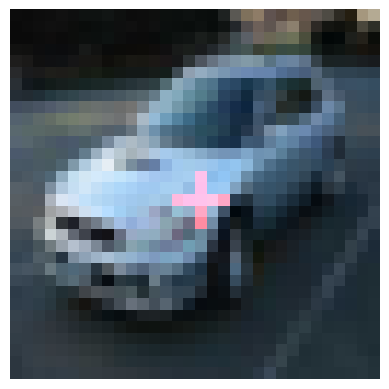

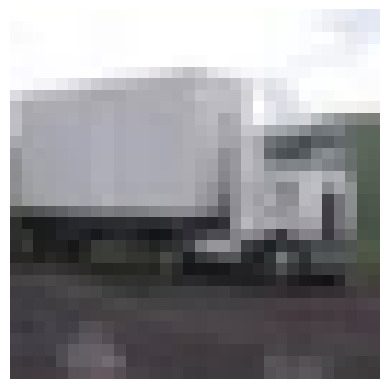

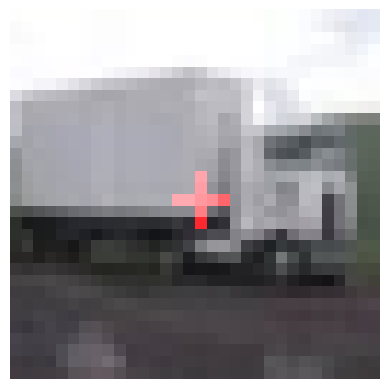

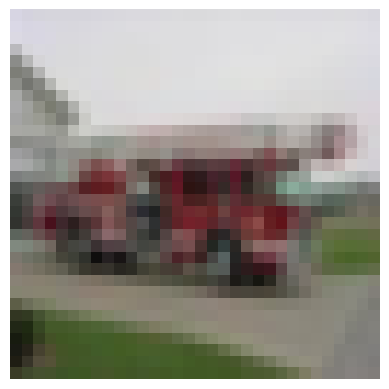

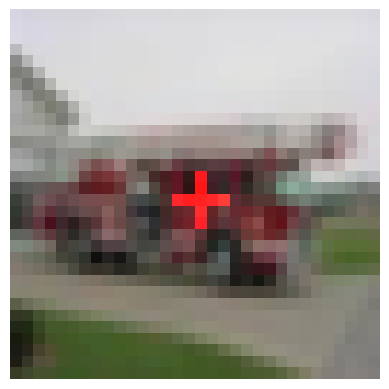

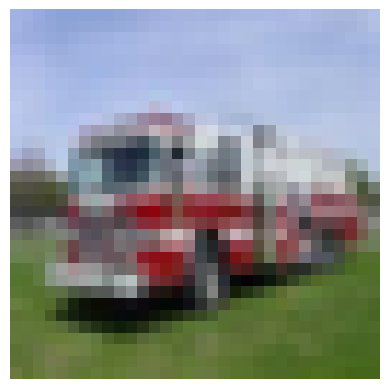

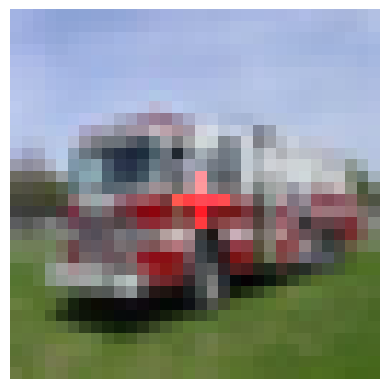

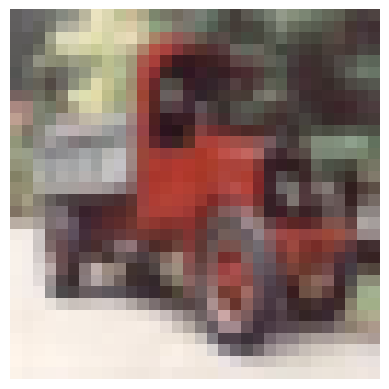

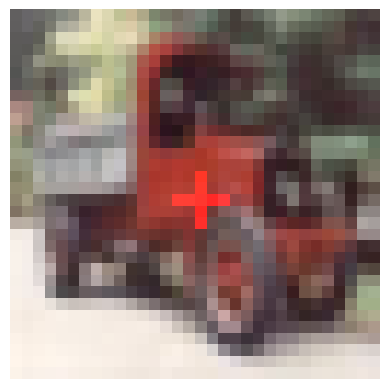

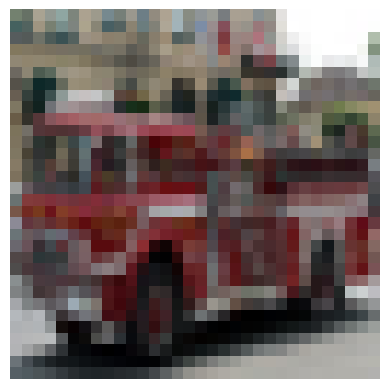

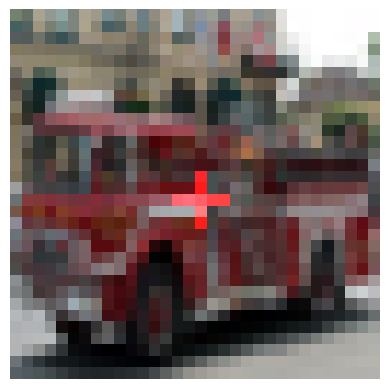

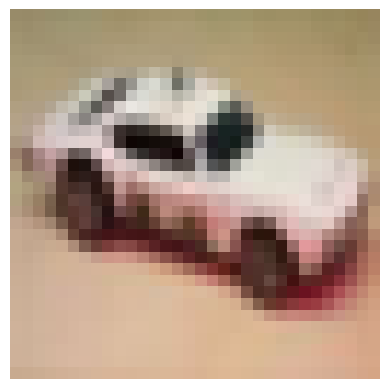

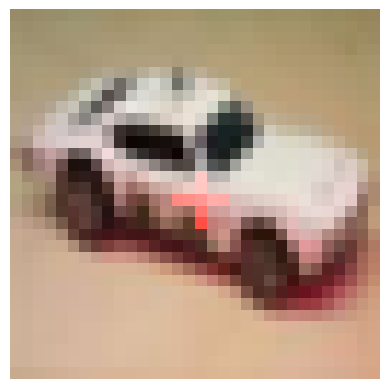

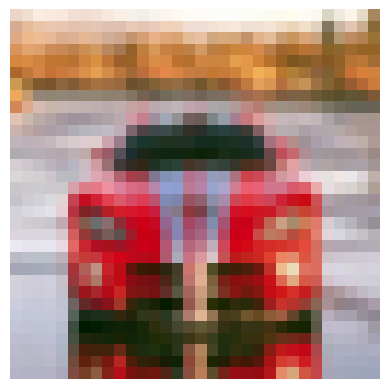

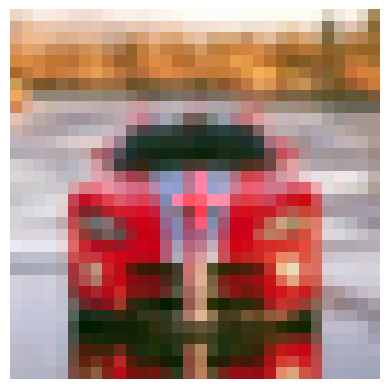

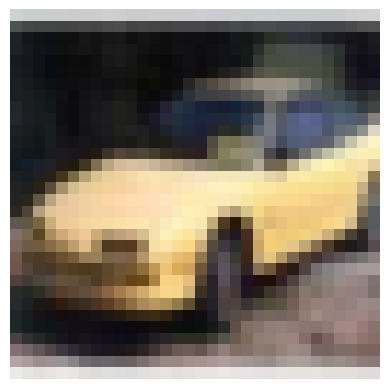

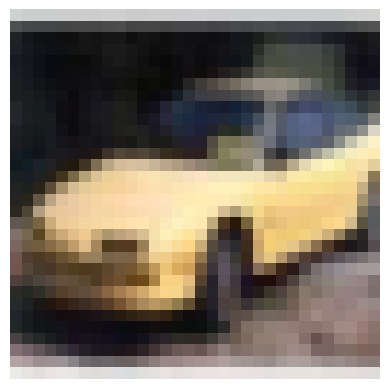

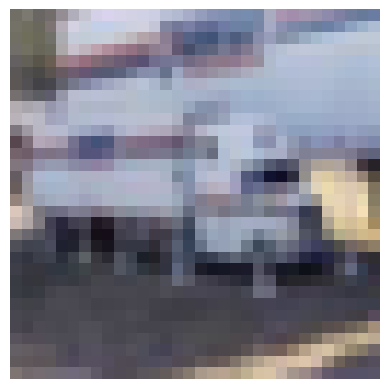

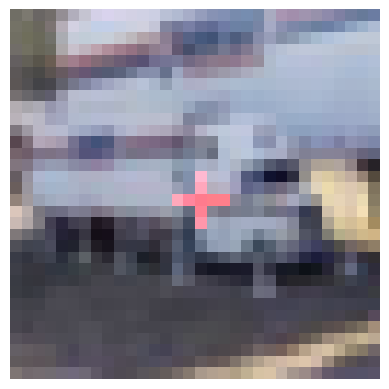

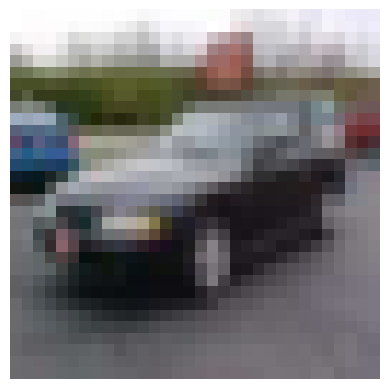

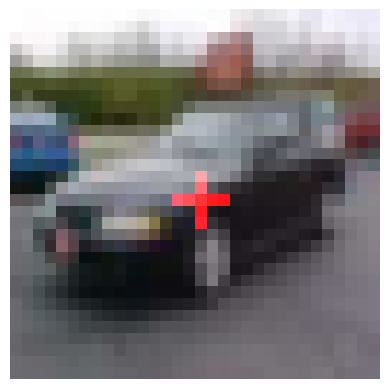

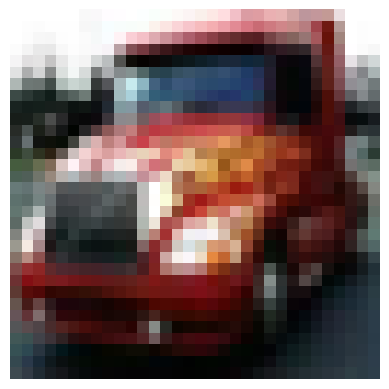

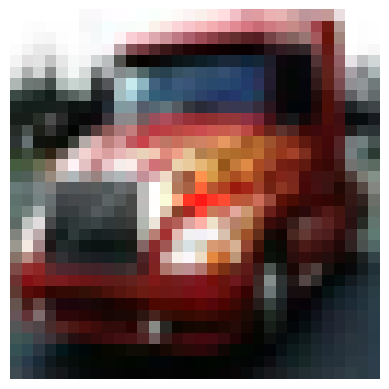

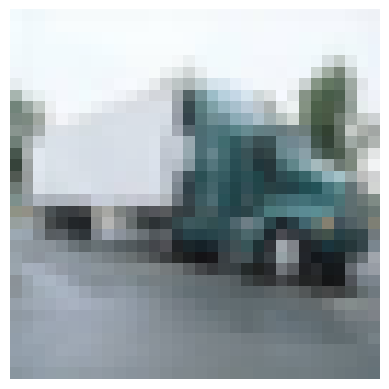

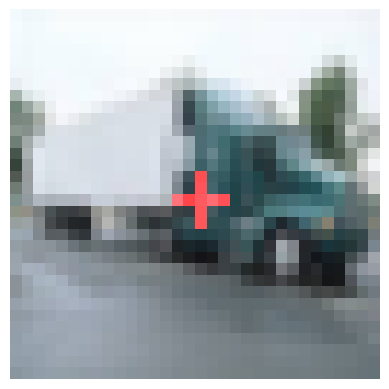

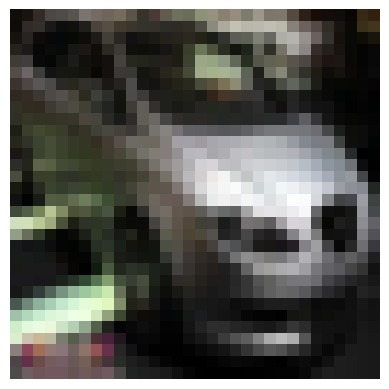

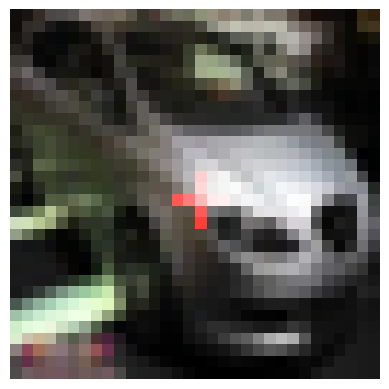

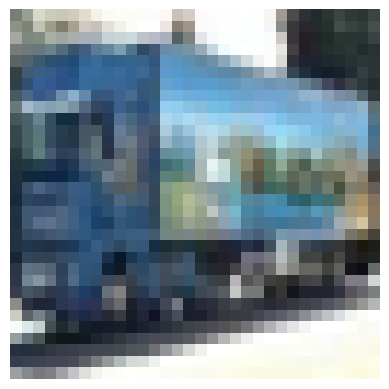

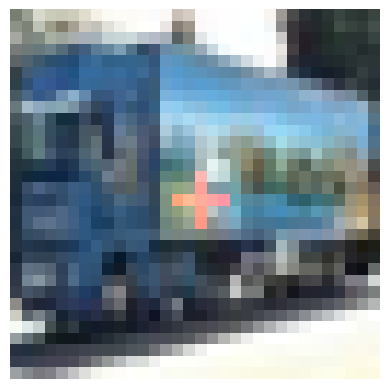

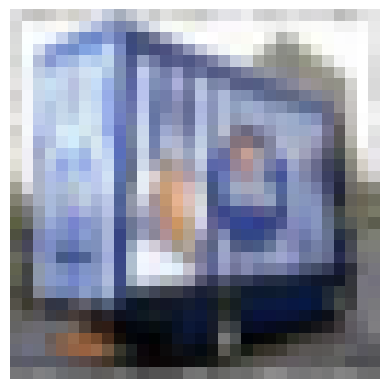

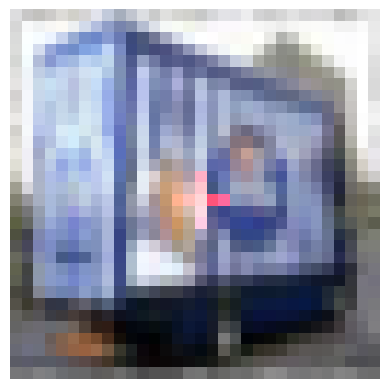

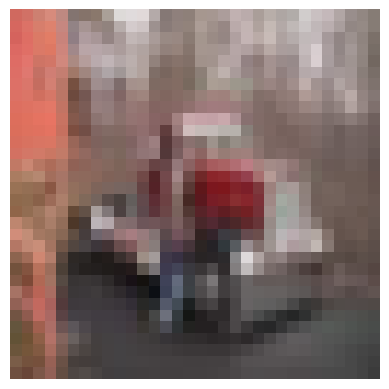

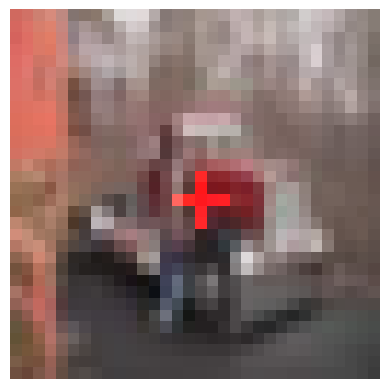

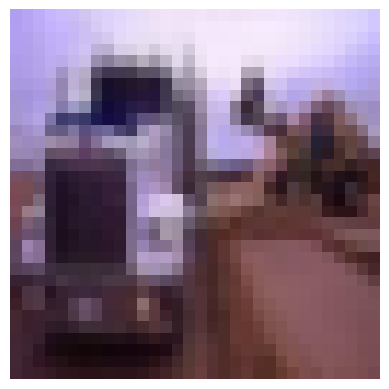

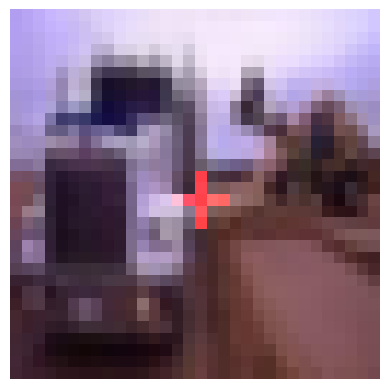

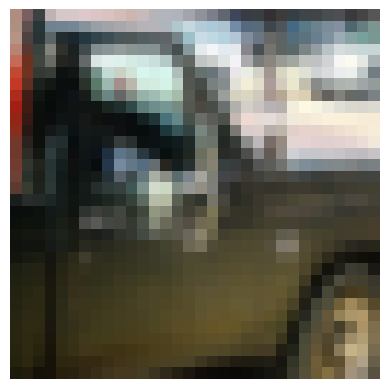

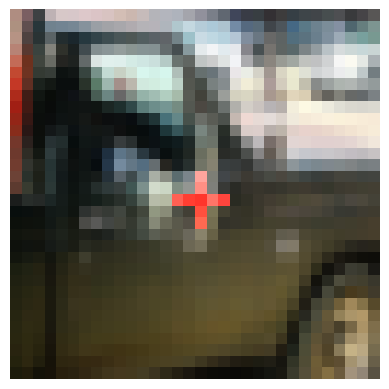

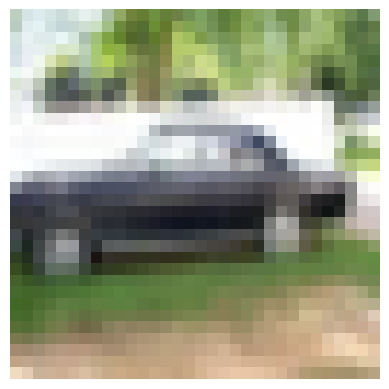

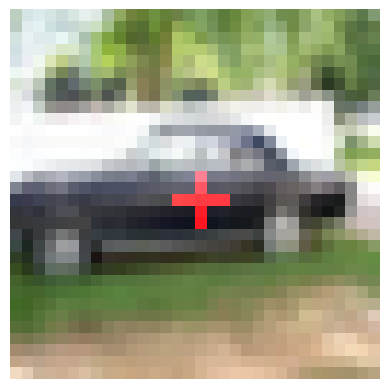

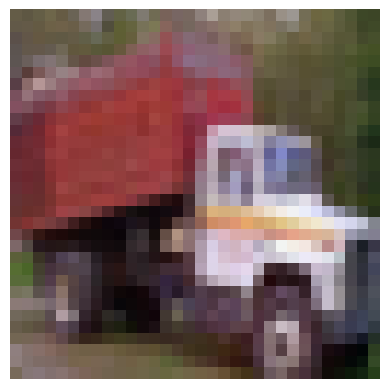

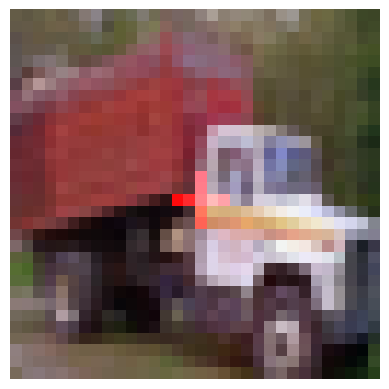

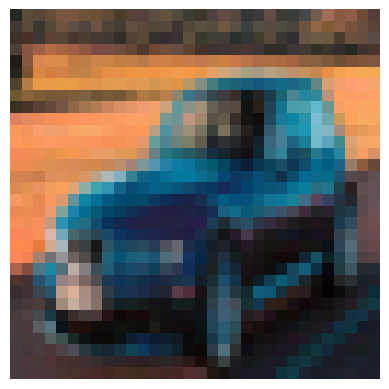

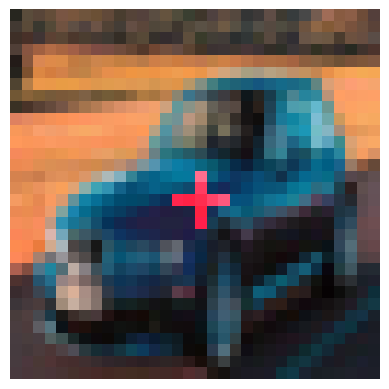

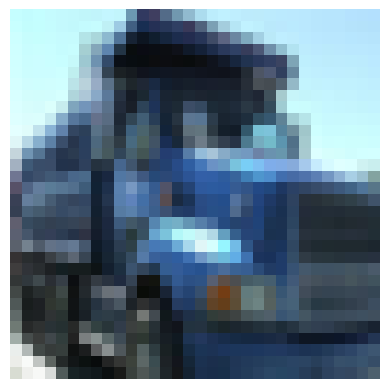

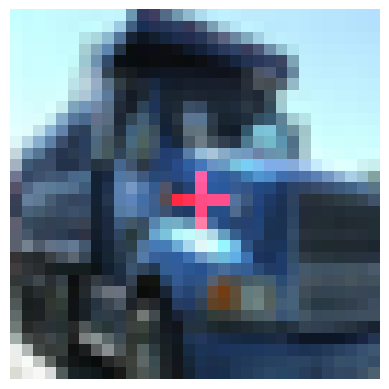

<ipython-input-73-b32645b10ed8>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images = torch.tensor(train_data['data']).float() / 255.0
<ipython-input-73-b32645b10ed8>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(train_images, torch.tensor(train_data['labels']))
<ipython-input-73-b32645b10ed8>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images = torch.tensor(test_data['data']).float() / 255.0


Overall Mean: tensor([0.4928, 0.4836, 0.4485])
Overall Std: tensor([0.2022, 0.1993, 0.2010])


<ipython-input-73-b32645b10ed8>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images = torch.tensor(train_data['data']).float() / 255.0
<ipython-input-73-b32645b10ed8>:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(normalized_train_images, torch.tensor(train_data['labels']))
<ipython-input-73-b32645b10ed8>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images = torch.tensor(test_data['data']).float() / 255.0


In [74]:
cifar10_path = '/content/drive/MyDrive/연구/cifar-10-batches-py'
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=50, num_epochs=100)
trainer.load_and_transform_data()


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

<ipython-input-2-b6bfec8560b8>:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images[i] = torch.tensor(self.add_red_cross(torch.tensor(images[i])))


Overall Mean: tensor([0.4928, 0.4836, 0.4485])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.369228
Epoch 1, Batch 200, Average Loss: 2.326217
Epoch 1, Batch 300, Average Loss: 2.293018
Epoch 1, Batch 400, Average Loss: 2.260528
Epoch 1, Batch 500, Average Loss: 2.229058
Epoch 1, Batch 600, Average Loss: 2.201616
Epoch 1, Batch 700, Average Loss: 2.173103
Epoch 2, Batch 100, Average Loss: 2.251183
Epoch 2, Batch 200, Average Loss: 2.102819
Epoch 2, Batch 300, Average Loss: 2.031002
Epoch 2, Batch 400, Average Loss: 1.960505
Epoch 2, Batch 500, Average Loss: 1.899999
Epoch 2, Batch 600, Average Loss: 1.850694
Epoch 2, Batch 700, Average Loss: 1.804516
Epoch 3, Batch 100, Average Loss: 1.453552
Epoch 3, Batch 200, Average Loss: 1.429593
Epoch 3, Batch 300, Average Loss: 1.412509
Epoch 3, Batch 400, Average Loss: 1.395489
Epoch 3, Batch 500, Average Loss: 1.380215
Epoch 3, Batch 600, Average Loss: 1.365462
Epoch 3, Batch 700, Average Loss: 1.358877
Epoc

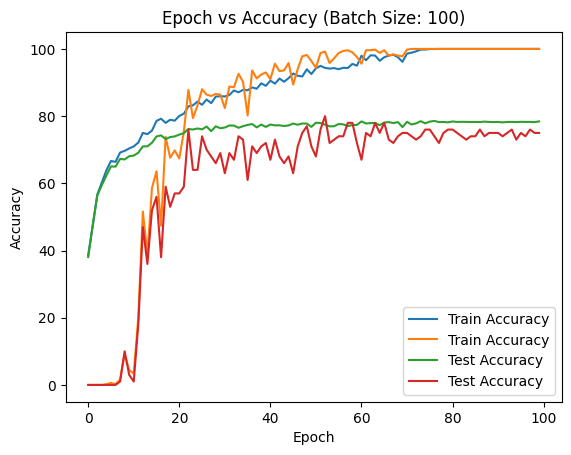

Train Accuracy: (100.0, 100.0), Test Accuracy: (78.41, 75.0)
Overall Mean: tensor([0.4928, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.365052
Epoch 1, Batch 200, Average Loss: 2.328733
Epoch 1, Batch 300, Average Loss: 2.296251
Epoch 1, Batch 400, Average Loss: 2.264160
Epoch 1, Batch 500, Average Loss: 2.235601
Epoch 1, Batch 600, Average Loss: 2.206972
Epoch 1, Batch 700, Average Loss: 2.180773
Epoch 2, Batch 100, Average Loss: 2.022861
Epoch 2, Batch 200, Average Loss: 1.895436
Epoch 2, Batch 300, Average Loss: 1.813076
Epoch 2, Batch 400, Average Loss: 1.735304
Epoch 2, Batch 500, Average Loss: 1.670175
Epoch 2, Batch 600, Average Loss: 1.609199
Epoch 2, Batch 700, Average Loss: 1.558441
Epoch 3, Batch 100, Average Loss: 1.118101
Epoch 3, Batch 200, Average Loss: 1.122228
Epoch 3, Batch 300, Average Loss: 1.103658
Epoch 3, Batch 400, Average Loss: 1.083490
Epoch 3, Batch 500, Average Loss: 1.071542
Epoch 3, Batch 600, Average L

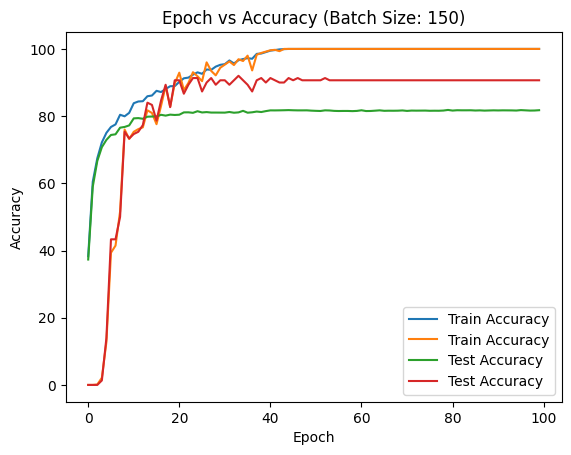

Train Accuracy: (100.0, 100.0), Test Accuracy: (81.76, 90.66666666666667)
Overall Mean: tensor([0.4928, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.371363
Epoch 1, Batch 200, Average Loss: 2.333743
Epoch 1, Batch 300, Average Loss: 2.298856
Epoch 1, Batch 400, Average Loss: 2.271784
Epoch 1, Batch 500, Average Loss: 2.241391
Epoch 1, Batch 600, Average Loss: 2.213302
Epoch 1, Batch 700, Average Loss: 2.186245
Epoch 2, Batch 100, Average Loss: 2.138421
Epoch 2, Batch 200, Average Loss: 2.005115
Epoch 2, Batch 300, Average Loss: 1.925135
Epoch 2, Batch 400, Average Loss: 1.851010
Epoch 2, Batch 500, Average Loss: 1.796723
Epoch 2, Batch 600, Average Loss: 1.746993
Epoch 2, Batch 700, Average Loss: 1.707089
Epoch 3, Batch 100, Average Loss: 1.354099
Epoch 3, Batch 200, Average Loss: 1.331024
Epoch 3, Batch 300, Average Loss: 1.312148
Epoch 3, Batch 400, Average Loss: 1.295258
Epoch 3, Batch 500, Average Loss: 1.271661
Epoch 3, Batch 6

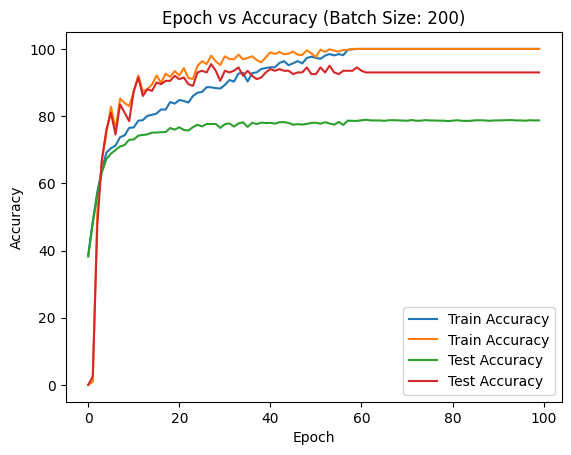

Train Accuracy: (100.0, 100.0), Test Accuracy: (78.73, 93.0)
Overall Mean: tensor([0.4928, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.369515
Epoch 1, Batch 200, Average Loss: 2.336576
Epoch 1, Batch 300, Average Loss: 2.308601
Epoch 1, Batch 400, Average Loss: 2.279456
Epoch 1, Batch 500, Average Loss: 2.254758
Epoch 1, Batch 600, Average Loss: 2.231943
Epoch 1, Batch 700, Average Loss: 2.209177
Epoch 2, Batch 100, Average Loss: 2.214515
Epoch 2, Batch 200, Average Loss: 2.069640
Epoch 2, Batch 300, Average Loss: 1.987263
Epoch 2, Batch 400, Average Loss: 1.919332
Epoch 2, Batch 500, Average Loss: 1.865102
Epoch 2, Batch 600, Average Loss: 1.813680
Epoch 2, Batch 700, Average Loss: 1.771658
Epoch 3, Batch 100, Average Loss: 1.418139
Epoch 3, Batch 200, Average Loss: 1.422502
Epoch 3, Batch 300, Average Loss: 1.410536
Epoch 3, Batch 400, Average Loss: 1.386046
Epoch 3, Batch 500, Average Loss: 1.372762
Epoch 3, Batch 600, Average L

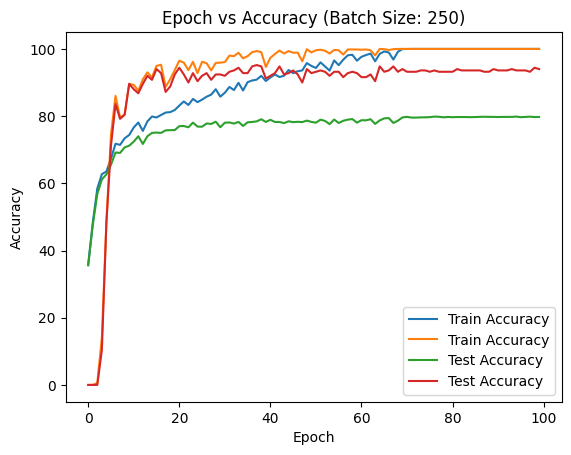

Train Accuracy: (100.0, 100.0), Test Accuracy: (79.75, 94.0)
Overall Mean: tensor([0.4928, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.373003
Epoch 1, Batch 200, Average Loss: 2.339532
Epoch 1, Batch 300, Average Loss: 2.308847
Epoch 1, Batch 400, Average Loss: 2.280651
Epoch 1, Batch 500, Average Loss: 2.253926
Epoch 1, Batch 600, Average Loss: 2.228648
Epoch 1, Batch 700, Average Loss: 2.204033
Epoch 2, Batch 100, Average Loss: 2.230777
Epoch 2, Batch 200, Average Loss: 2.095763
Epoch 2, Batch 300, Average Loss: 2.010745
Epoch 2, Batch 400, Average Loss: 1.955352
Epoch 2, Batch 500, Average Loss: 1.907297
Epoch 2, Batch 600, Average Loss: 1.872915
Epoch 2, Batch 700, Average Loss: 1.843234
Epoch 3, Batch 100, Average Loss: 1.555034
Epoch 3, Batch 200, Average Loss: 1.548491
Epoch 3, Batch 300, Average Loss: 1.520270
Epoch 3, Batch 400, Average Loss: 1.509327
Epoch 3, Batch 500, Average Loss: 1.488894
Epoch 3, Batch 600, Average L

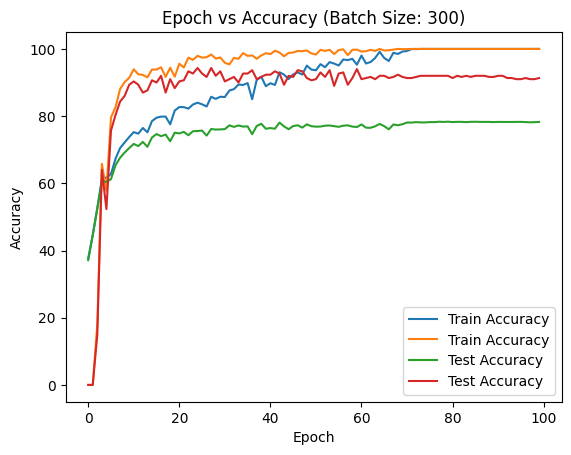

Train Accuracy: (100.0, 100.0), Test Accuracy: (78.27, 91.33333333333333)
Overall Mean: tensor([0.4928, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.371270
Epoch 1, Batch 200, Average Loss: 2.338562
Epoch 1, Batch 300, Average Loss: 2.308665
Epoch 1, Batch 400, Average Loss: 2.281827
Epoch 1, Batch 500, Average Loss: 2.253374
Epoch 1, Batch 600, Average Loss: 2.227566
Epoch 1, Batch 700, Average Loss: 2.201115
Epoch 2, Batch 100, Average Loss: 2.103064
Epoch 2, Batch 200, Average Loss: 1.962037
Epoch 2, Batch 300, Average Loss: 1.860739
Epoch 2, Batch 400, Average Loss: 1.781693
Epoch 2, Batch 500, Average Loss: 1.708963
Epoch 2, Batch 600, Average Loss: 1.656510
Epoch 2, Batch 700, Average Loss: 1.606358
Epoch 3, Batch 100, Average Loss: 1.218072
Epoch 3, Batch 200, Average Loss: 1.200152
Epoch 3, Batch 300, Average Loss: 1.172711
Epoch 3, Batch 400, Average Loss: 1.151924
Epoch 3, Batch 500, Average Loss: 1.135629
Epoch 3, Batch 6

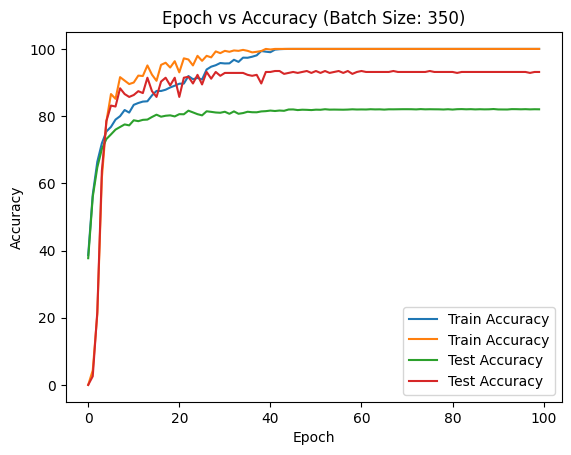

Train Accuracy: (100.0, 100.0), Test Accuracy: (82.03, 93.14285714285714)
Overall Mean: tensor([0.4927, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.376356
Epoch 1, Batch 200, Average Loss: 2.345412
Epoch 1, Batch 300, Average Loss: 2.316120
Epoch 1, Batch 400, Average Loss: 2.289531
Epoch 1, Batch 500, Average Loss: 2.263566
Epoch 1, Batch 600, Average Loss: 2.238547
Epoch 1, Batch 700, Average Loss: 2.213396
Epoch 2, Batch 100, Average Loss: 2.166183
Epoch 2, Batch 200, Average Loss: 2.036865
Epoch 2, Batch 300, Average Loss: 1.932846
Epoch 2, Batch 400, Average Loss: 1.854902
Epoch 2, Batch 500, Average Loss: 1.790450
Epoch 2, Batch 600, Average Loss: 1.743070
Epoch 2, Batch 700, Average Loss: 1.699328
Epoch 3, Batch 100, Average Loss: 1.326406
Epoch 3, Batch 200, Average Loss: 1.308478
Epoch 3, Batch 300, Average Loss: 1.296398
Epoch 3, Batch 400, Average Loss: 1.281046
Epoch 3, Batch 500, Average Loss: 1.268237
Epoch 3, Batch 6

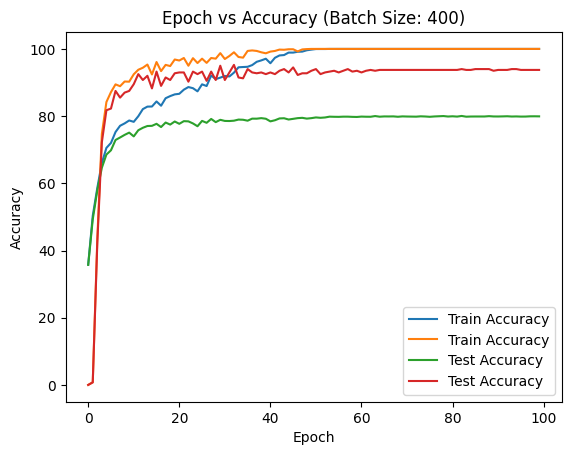

Train Accuracy: (100.0, 100.0), Test Accuracy: (79.93, 93.75)
Overall Mean: tensor([0.4927, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.374318
Epoch 1, Batch 200, Average Loss: 2.345336
Epoch 1, Batch 300, Average Loss: 2.313261
Epoch 1, Batch 400, Average Loss: 2.285887
Epoch 1, Batch 500, Average Loss: 2.260832
Epoch 1, Batch 600, Average Loss: 2.234976
Epoch 1, Batch 700, Average Loss: 2.211474
Epoch 2, Batch 100, Average Loss: 2.420328
Epoch 2, Batch 200, Average Loss: 2.232116
Epoch 2, Batch 300, Average Loss: 2.154623
Epoch 2, Batch 400, Average Loss: 2.086947
Epoch 2, Batch 500, Average Loss: 2.038228
Epoch 2, Batch 600, Average Loss: 2.003975
Epoch 2, Batch 700, Average Loss: 1.973143
Epoch 3, Batch 100, Average Loss: 1.703117
Epoch 3, Batch 200, Average Loss: 1.694264
Epoch 3, Batch 300, Average Loss: 1.688696
Epoch 3, Batch 400, Average Loss: 1.679761
Epoch 3, Batch 500, Average Loss: 1.666853
Epoch 3, Batch 600, Average 

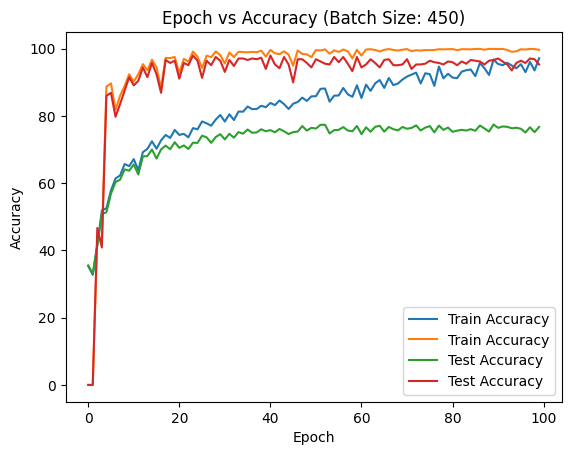

Train Accuracy: (97.19, 99.68888888888888), Test Accuracy: (76.74, 95.33333333333333)
Overall Mean: tensor([0.4927, 0.4836, 0.4484])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.374309
Epoch 1, Batch 200, Average Loss: 2.343549
Epoch 1, Batch 300, Average Loss: 2.315387
Epoch 1, Batch 400, Average Loss: 2.288966
Epoch 1, Batch 500, Average Loss: 2.264979
Epoch 1, Batch 600, Average Loss: 2.240841
Epoch 1, Batch 700, Average Loss: 2.217480
Epoch 2, Batch 100, Average Loss: 2.268230
Epoch 2, Batch 200, Average Loss: 2.130554
Epoch 2, Batch 300, Average Loss: 2.019135
Epoch 2, Batch 400, Average Loss: 1.950603
Epoch 2, Batch 500, Average Loss: 1.896142
Epoch 2, Batch 600, Average Loss: 1.846745
Epoch 2, Batch 700, Average Loss: 1.807360
Epoch 3, Batch 100, Average Loss: 1.493029
Epoch 3, Batch 200, Average Loss: 1.487859
Epoch 3, Batch 300, Average Loss: 1.470910
Epoch 3, Batch 400, Average Loss: 1.455177
Epoch 3, Batch 500, Average Loss: 1.444360
Epoc

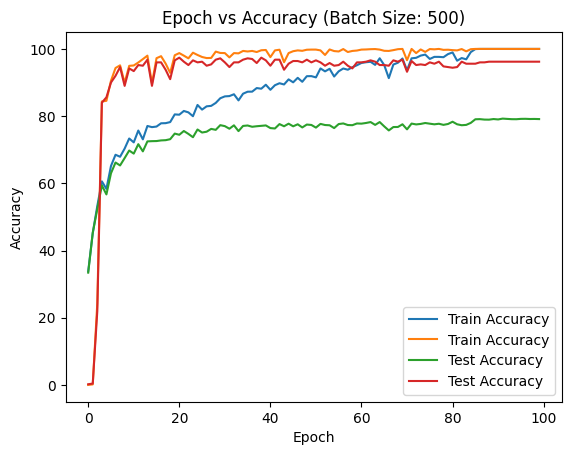

Train Accuracy: (100.0, 100.0), Test Accuracy: (79.12, 96.2)


In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
cifar10_path = '/content/drive/MyDrive/연구/cifar-10-batches-py'

#trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=50, num_epochs=100)
#trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=100, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=150, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=200, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=250, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=300, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=350, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=400, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=450, num_epochs=100)
trainer.run()
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=500, num_epochs=100)
trainer.run()
#trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=50, num_epochs=100)
#trainer.run()

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

<ipython-input-2-b6bfec8560b8>:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images[i] = torch.tensor(self.add_red_cross(torch.tensor(images[i])))


Overall Mean: tensor([0.4928, 0.4836, 0.4485])
Overall Std: tensor([0.2022, 0.1993, 0.2011])
Epoch 1, Batch 100, Average Loss: 2.366882
Epoch 1, Batch 200, Average Loss: 2.328695
Epoch 1, Batch 300, Average Loss: 2.291995
Epoch 1, Batch 400, Average Loss: 2.255879
Epoch 1, Batch 500, Average Loss: 2.222645
Epoch 1, Batch 600, Average Loss: 2.190599
Epoch 1, Batch 700, Average Loss: 2.159317
Epoch 2, Batch 100, Average Loss: 2.171906
Epoch 2, Batch 200, Average Loss: 2.008166
Epoch 2, Batch 300, Average Loss: 1.900758
Epoch 2, Batch 400, Average Loss: 1.814512
Epoch 2, Batch 500, Average Loss: 1.755854
Epoch 2, Batch 600, Average Loss: 1.702992
Epoch 2, Batch 700, Average Loss: 1.662198
Epoch 3, Batch 100, Average Loss: 1.350122
Epoch 3, Batch 200, Average Loss: 1.321639
Epoch 3, Batch 300, Average Loss: 1.306939
Epoch 3, Batch 400, Average Loss: 1.291592
Epoch 3, Batch 500, Average Loss: 1.281140
Epoch 3, Batch 600, Average Loss: 1.264880
Epoch 3, Batch 700, Average Loss: 1.251268
Epoc

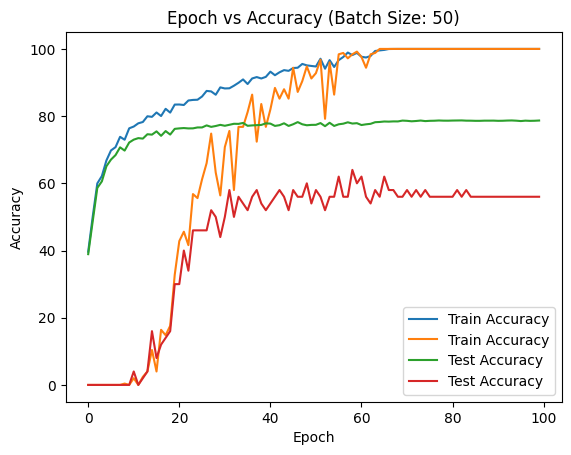

Train Accuracy: (100.0, 100.0), Test Accuracy: (78.69, 56.0)


In [ ]:
cifar10_path = '/content/drive/MyDrive/연구/cifar-10-batches-py'
trainer = CIFAR10Trainer(cifar10_path, num_samples_per_batch=50, num_epochs=100)
trainer.run()

In [ ]:
# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# CIFAR-10 데이터셋 경로 설정 및 프로세스 실행
cifar10_path = '/content/drive/MyDrive/연구/cifar-10-batches-py'
train_and_evaluate_process(cifar10_path)